# IXI brain 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The [IXI](https://brain-development.org/ixi-dataset/) Tiny dataset can be downloaded from https://www.dropbox.com/s/ogxjwjxdv5mieah/ixi_tiny.zip?dl=1.

Target: Brain  
Modality: MRI  
Size: 566 3D volumes

## Setup environment

In [1]:
%pip install -qU "monai[gdown, nibabel]"

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\dev\monai\pyenv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install -qU matplotlib
%matplotlib inline

You should consider upgrading via the 'c:\dev\monai\pyenv\scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [10]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    Orientationd,
    DivisiblePadd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Spacingd,
    ToTensord,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0.3.0
Python version: 3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]
OS version: Windows (10)
Numpy version: 1.19.1
Pytorch version: 1.4.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.1
scikit-image version: 0.17.2
Pillow version: 7.2.0
Tensorboard version: 2.3.0
gdown version: 3.12.2
TorchVision version: 0.5.0+cpu
ITK version: 5.1.0
tqdm version: 4.48.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [11]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Dev\MONAI\Data


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from https://torchio.readthedocs.io/_modules/torchio/datasets/ixi.html.

In [12]:
resource = "https://www.dropbox.com/s/ogxjwjxdv5mieah/ixi_tiny.zip?dl=1"
md5 = "bfb60f4074283d78622760230bfa1f98"

compressed_file = os.path.join(root_dir, "ixi_tiny.zip")
data_dir = os.path.join(root_dir, "ixi_tiny")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set the dataset path

In [13]:
train_images = sorted(glob.glob(os.path.join(data_dir, "image", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "label", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-300], data_dicts[-300:]

## Set deterministic training for reproducibility

In [14]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadNiftid` loads the images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `ToTensord` converts the numpy array to PyTorch Tensor for further steps.

In [15]:
train_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(2.18, 4.13, 3.95), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        
        DivisiblePadd(keys=["image", "label"], k=32, mode="edge"),
        # user can also add other random transforms
        # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
        #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(2.18, 4.13, 3.95), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        DivisiblePadd(keys=["image", "label"], k=32, mode="edge"),
        ToTensord(keys=["image", "label"]),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([64, 64, 96]), label shape: torch.Size([64, 64, 96])


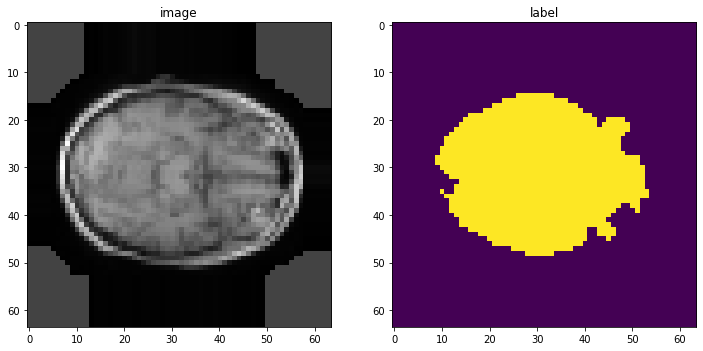

In [16]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 32]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 32], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 32])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [17]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

Load and cache transformed data: 100%|███████████████████████████████████████████████| 300/300 [00:05<00:00, 59.77it/s]


## Create Model, Loss, Optimizer

In [27]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
model_path = os.path.join(root_dir, "best_metric_model_ixi_tiny.pth")
if (os.path.exists(model_path)):
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model from file '{model_path}'")
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

Loaded model from file 'C:\Dev\MONAI\Data\best_metric_model_ixi_tiny.pth'


## Execute a typical PyTorch training process

In [28]:
epoch_num = 60
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        print(f"batch_data image: {batch_data['image'].shape}")
        print(f"batch_data label: {batch_data['label'].shape}")
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (96, 96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                    to_onehot_y=True,
                    mutually_exclusive=True,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), model_path)
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

----------
epoch 1/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.3426
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.3454
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.3421
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.3403
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.3409
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.3394
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.3386
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/

7/13, train_loss: 0.3004
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.3001
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.2998
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.2974
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.2974
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.2975
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.2978
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.2940
epoch 5 average loss: 0.3001
----------
epoch 6/100
batch_data image: torch.Size([20, 1, 64, 64, 

14/13, train_loss: 0.2627
epoch 9 average loss: 0.2663
----------
epoch 10/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.2616
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.2613
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.2608
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.2607
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.2617
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.2592
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.2574
batch_data image: torch.Size([20, 1, 64, 64, 9

6/13, train_loss: 0.2309
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.2283
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.2286
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.2281
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.2272
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.2291
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.2257
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.2264
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96]

12/13, train_loss: 0.1974
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.1976
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.1984
epoch 18 average loss: 0.2003
saved new best metric model
current epoch: 18 current mean dice: 0.6650
best mean dice: 0.6650 at epoch: 18
----------
epoch 19/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.1955
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.1965
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.1951
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.1951
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data l

3/13, train_loss: 0.1716
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.1703
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.1688
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.1697
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.1690
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.1668
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.1673
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.1688
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])

10/13, train_loss: 0.1476
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.1467
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.1446
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.1447
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.1447
epoch 27 average loss: 0.1471
----------
epoch 28/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.1435
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.1436
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.1447
batch_data image: torch.Size([20, 1, 64, 64

2/13, train_loss: 0.1257
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.1260
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.1250
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.1245
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.1257
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.1249
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.1228
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.1227
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])


9/13, train_loss: 0.1076
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.1068
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.1078
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.1072
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.1082
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.1078
epoch 36 average loss: 0.1083
current epoch: 36 current mean dice: 0.7390
best mean dice: 0.7431 at epoch: 24
----------
epoch 37/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.1077
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 6

1/13, train_loss: 0.0925
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.0934
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.0932
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.0918
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.0925
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.0918
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.0919
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.0915
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])


8/13, train_loss: 0.0803
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.0803
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.0810
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.0801
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.0796
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.0793
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.0800
epoch 45 average loss: 0.0808
----------
epoch 46/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.0801
batch_data image: torch.Size([20, 1, 64, 64

1/13, train_loss: 0.0708
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.0705
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.0701
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.0698
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.0694
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.0690
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.0691
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.0687
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])


8/13, train_loss: 0.0608
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.0622
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.0616
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.0616
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.0616
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.0613
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.0613
epoch 54 average loss: 0.0617
current epoch: 54 current mean dice: 0.7324
best mean dice: 0.7485 at epoch: 46
----------
epoch 55/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 6

current epoch: 58 current mean dice: 0.7539
best mean dice: 0.7647 at epoch: 56
----------
epoch 59/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.0541
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.0545
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.0540
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.0537
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.0536
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.0543
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.0537
batch_data image: tor

6/13, train_loss: 0.0478
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.0484
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.0484
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.0481
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.0481
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.0486
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.0480
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.0484
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96]

13/13, train_loss: 0.0437
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.0437
epoch 67 average loss: 0.0438
----------
epoch 68/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.0431
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.0429
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.0430
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.0426
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.0429
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.0430
batch_data image: torch.Size([20, 1, 64, 64, 9

6/13, train_loss: 0.0388
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.0388
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.0388
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.0385
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.0387
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.0390
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.0387
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.0388
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96]

13/13, train_loss: 0.0357
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.0363
epoch 76 average loss: 0.0357
current epoch: 76 current mean dice: 0.7553
best mean dice: 0.7647 at epoch: 56
----------
epoch 77/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.0355
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.0352
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.0349
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.0350
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.0352
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 

5/13, train_loss: 0.0324
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.0321
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.0320
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.0317
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.0318
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.0317
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.0321
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.0318
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96

12/13, train_loss: 0.0293
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.0291
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.0297
epoch 85 average loss: 0.0295
----------
epoch 86/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.0291
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.0292
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.0289
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.0293
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.0291
batch_data image: torch.Size([20, 1, 64, 64, 

4/13, train_loss: 0.0268
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.0269
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.0269
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.0269
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.0269
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.0268
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.0264
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
11/13, train_loss: 0.0265
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96]

11/13, train_loss: 0.0250
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
12/13, train_loss: 0.0248
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
13/13, train_loss: 0.0248
batch_data image: torch.Size([6, 1, 64, 64, 96])
batch_data label: torch.Size([6, 1, 64, 64, 96])
14/13, train_loss: 0.0253
epoch 94 average loss: 0.0250
current epoch: 94 current mean dice: 0.7467
best mean dice: 0.7647 at epoch: 56
----------
epoch 95/100
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
1/13, train_loss: 0.0250
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
2/13, train_loss: 0.0246
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
3/13, train_loss: 0.0246
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64

3/13, train_loss: 0.0232
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
4/13, train_loss: 0.0230
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
5/13, train_loss: 0.0231
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
6/13, train_loss: 0.0231
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
7/13, train_loss: 0.0229
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
8/13, train_loss: 0.0233
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
9/13, train_loss: 0.0231
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])
10/13, train_loss: 0.0228
batch_data image: torch.Size([20, 1, 64, 64, 96])
batch_data label: torch.Size([20, 1, 64, 64, 96])

In [29]:
print(f"train completed, best_metric: {best_metric:.4f}  at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7647  at epoch: 56


## Plot the loss and metric

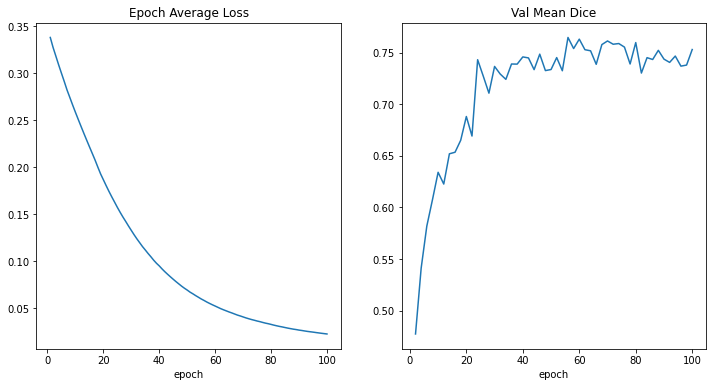

In [30]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

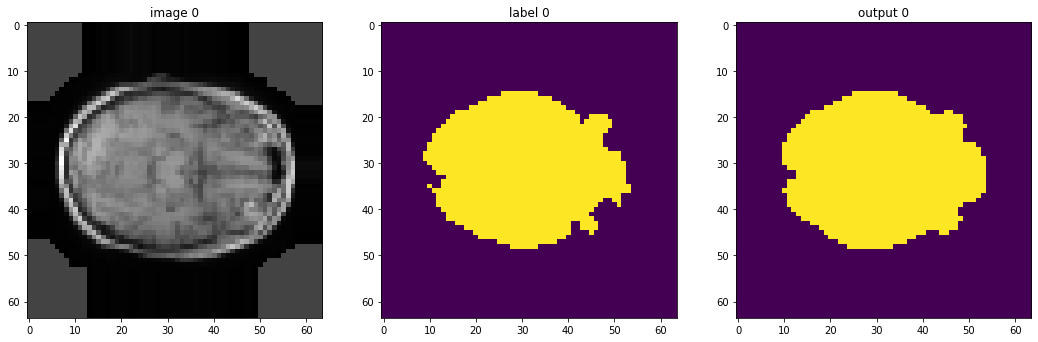

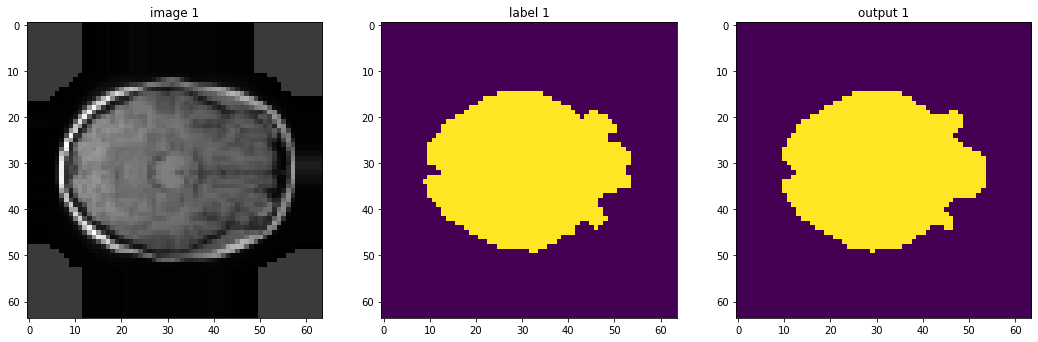

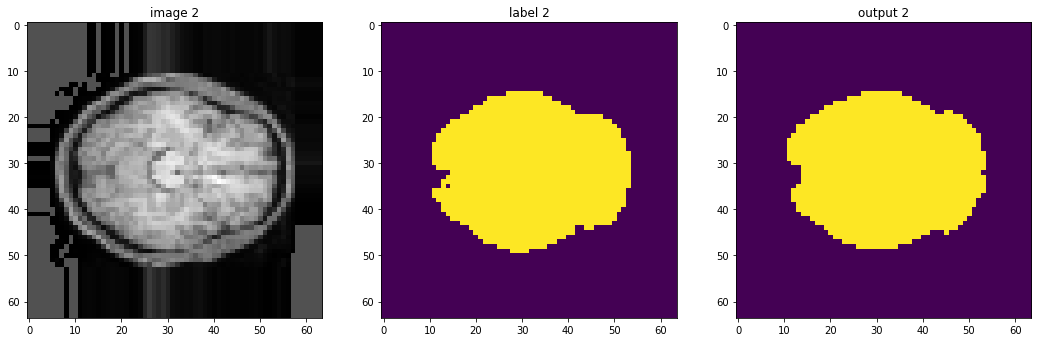

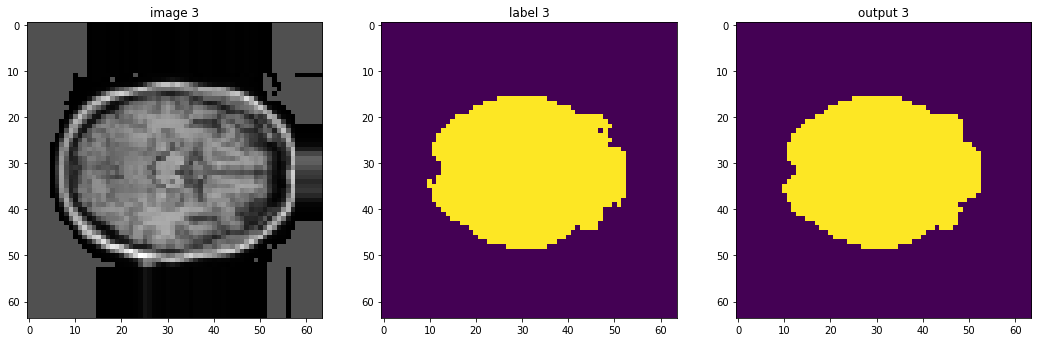

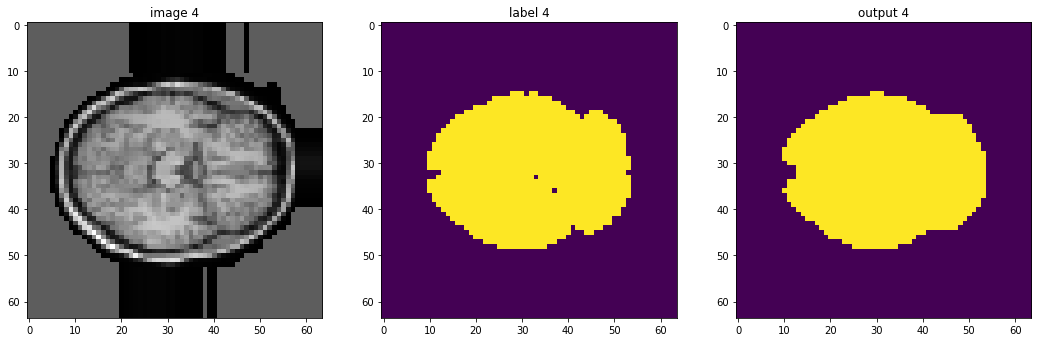

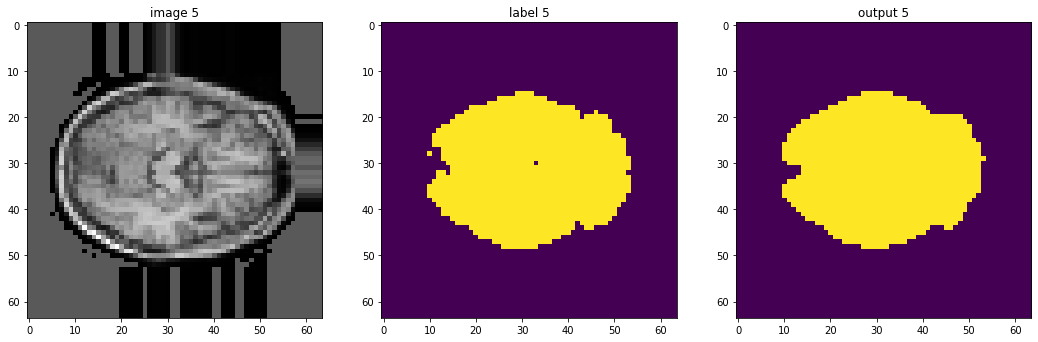

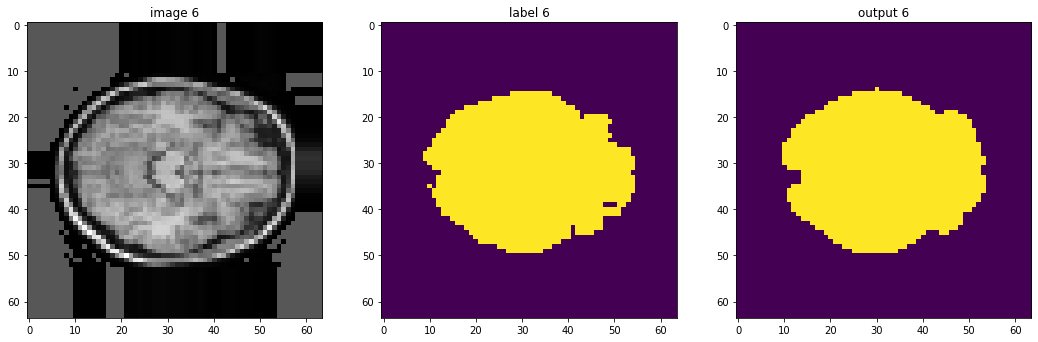

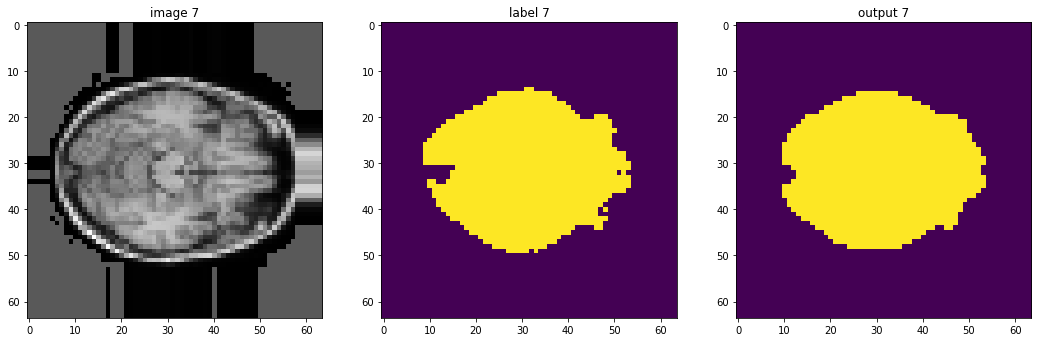

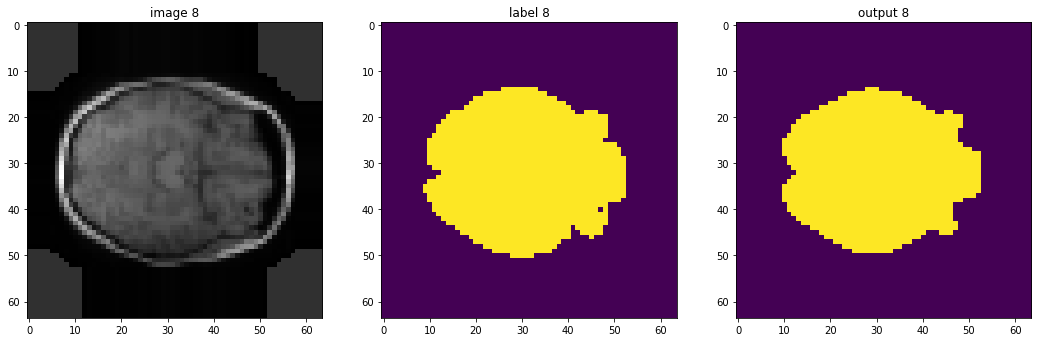

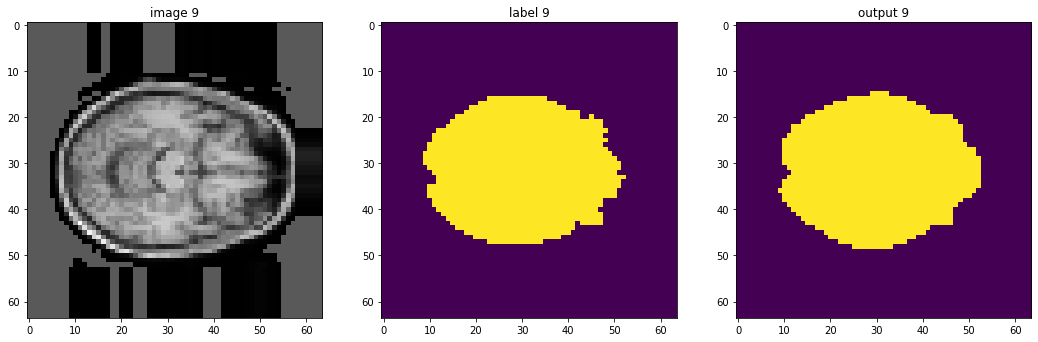

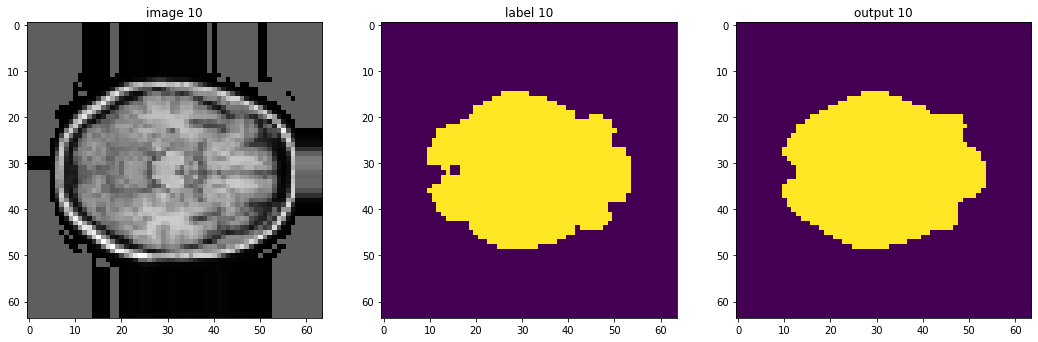

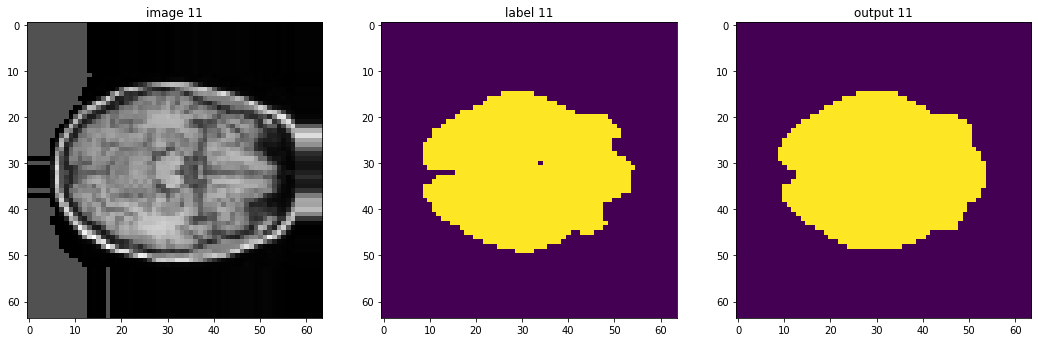

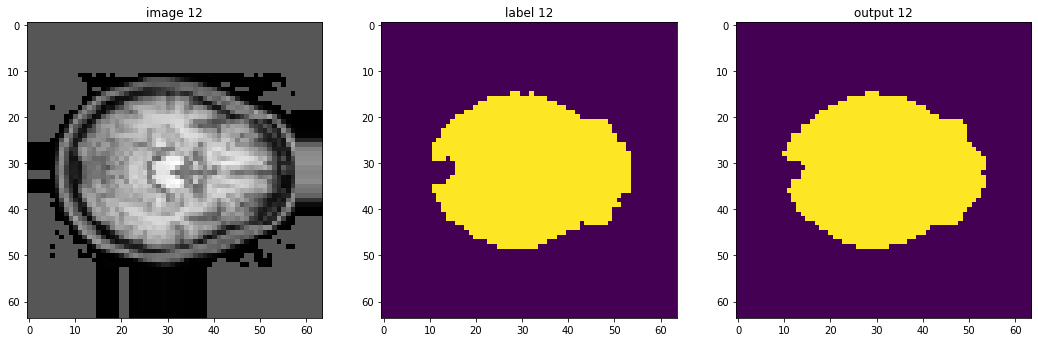

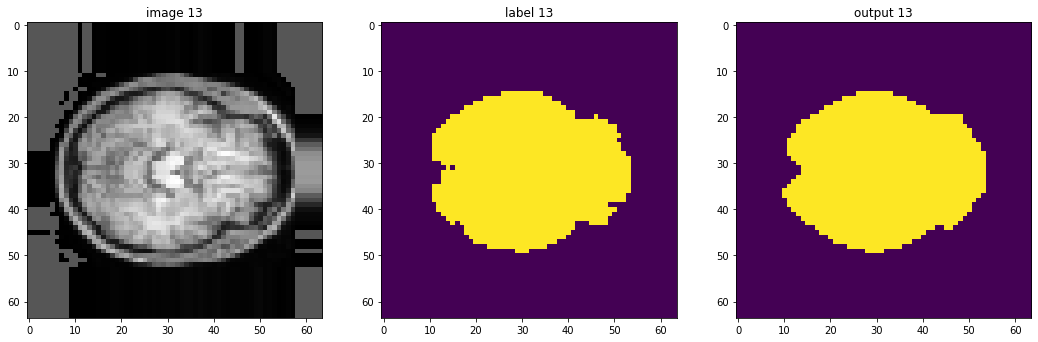

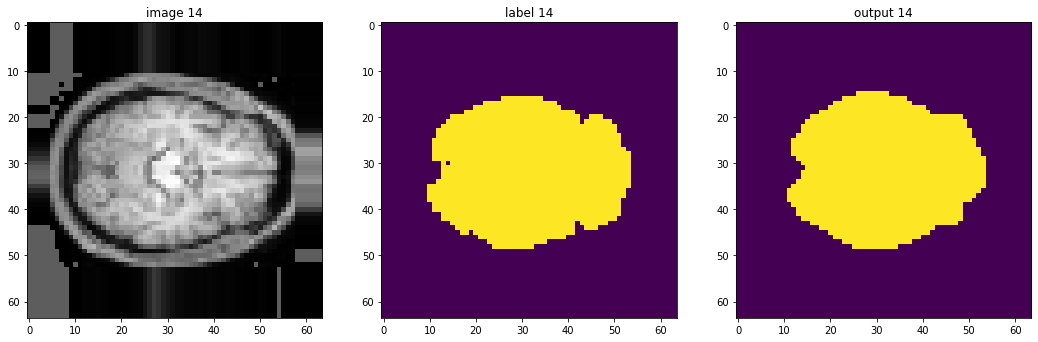

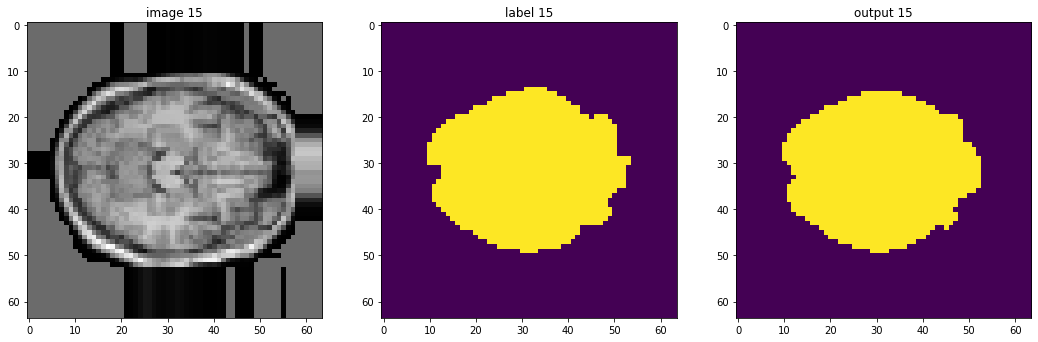

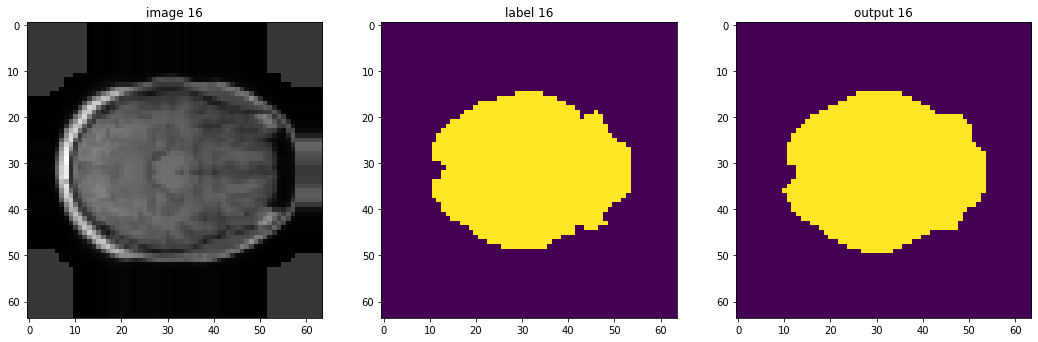

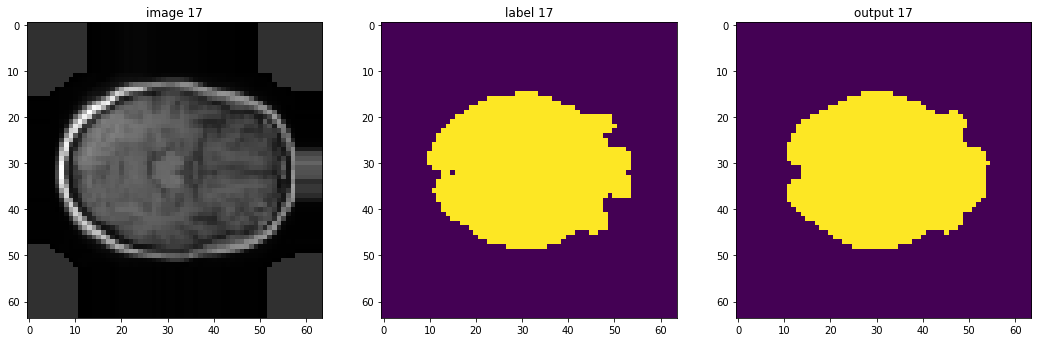

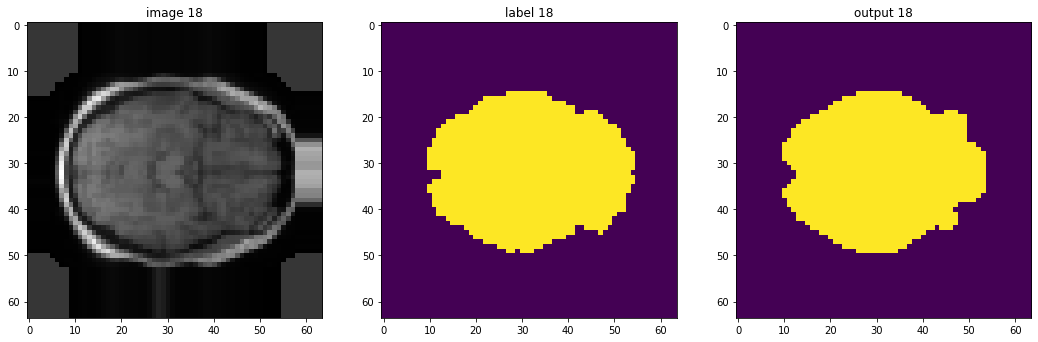

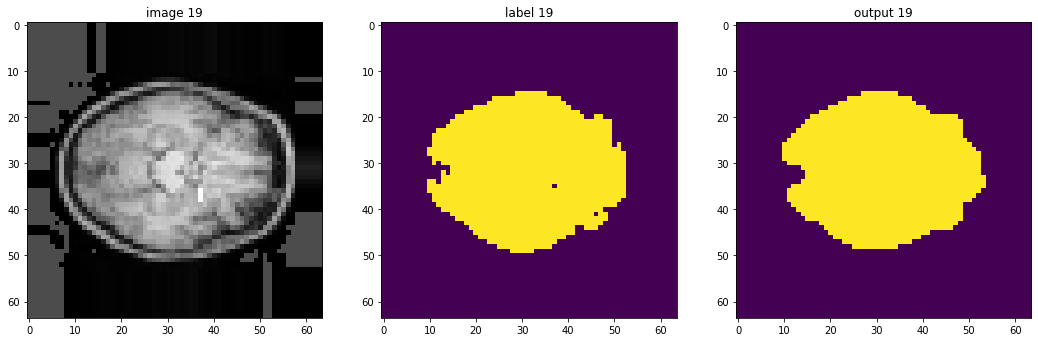

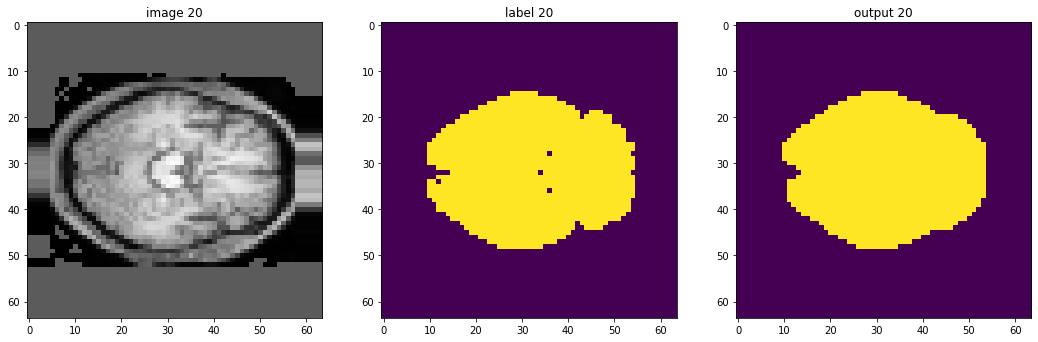

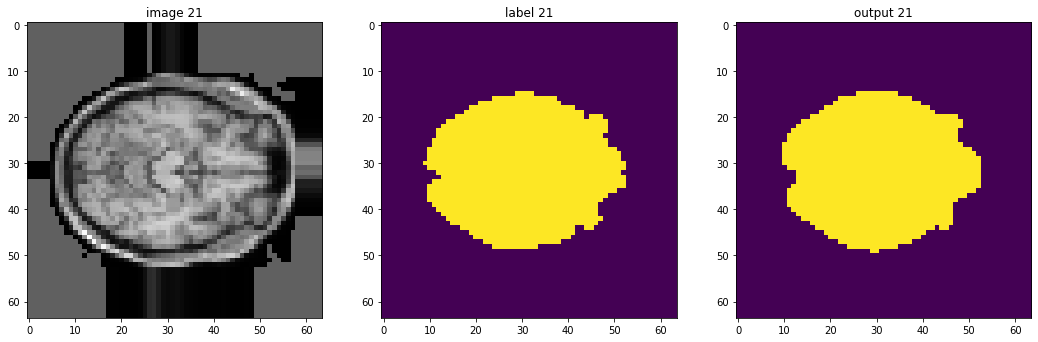

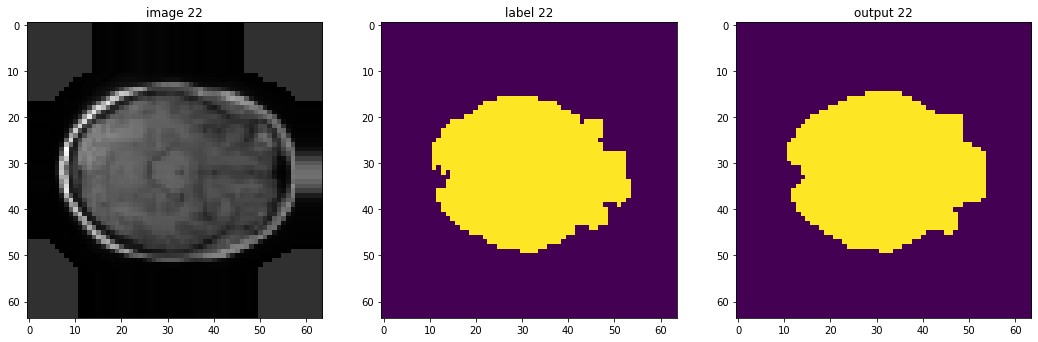

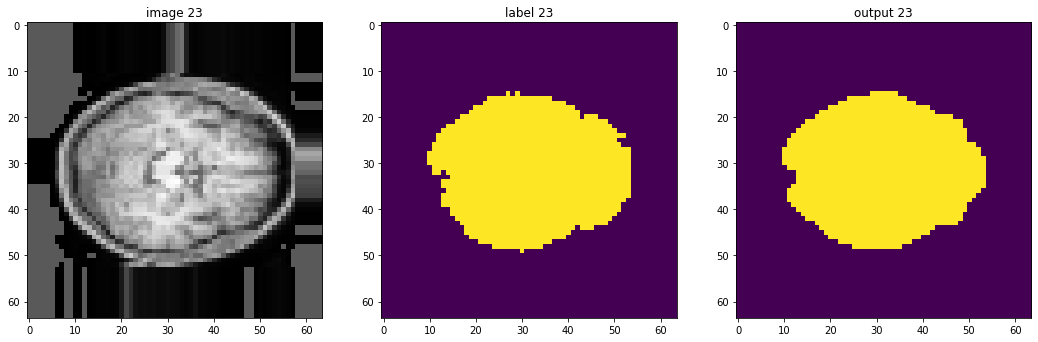

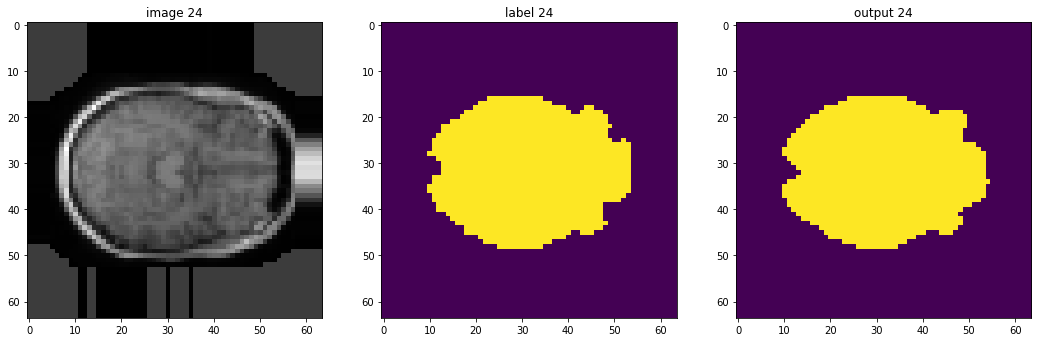

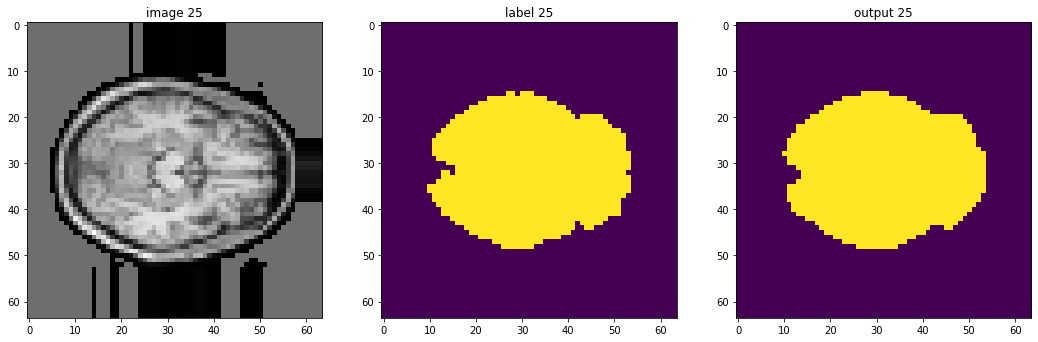

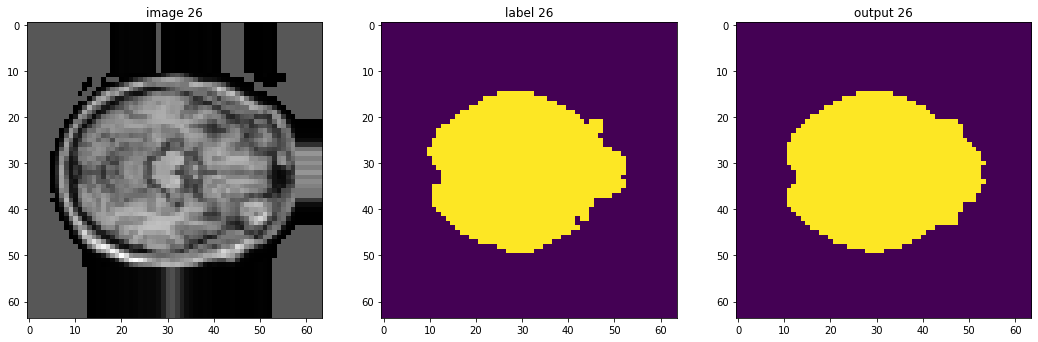

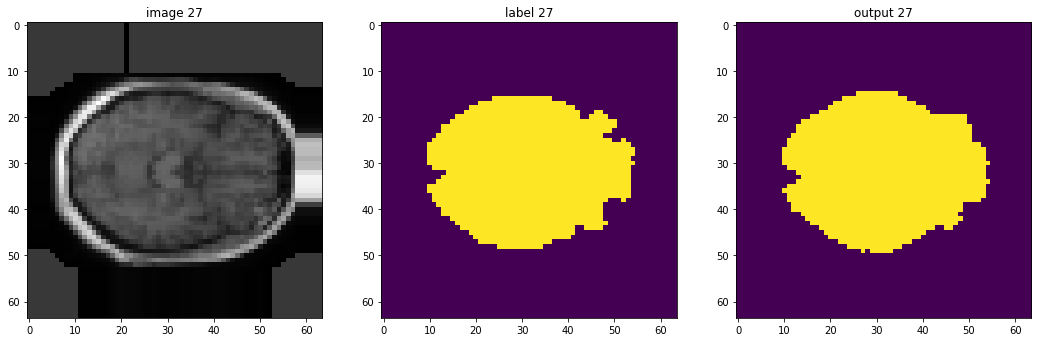

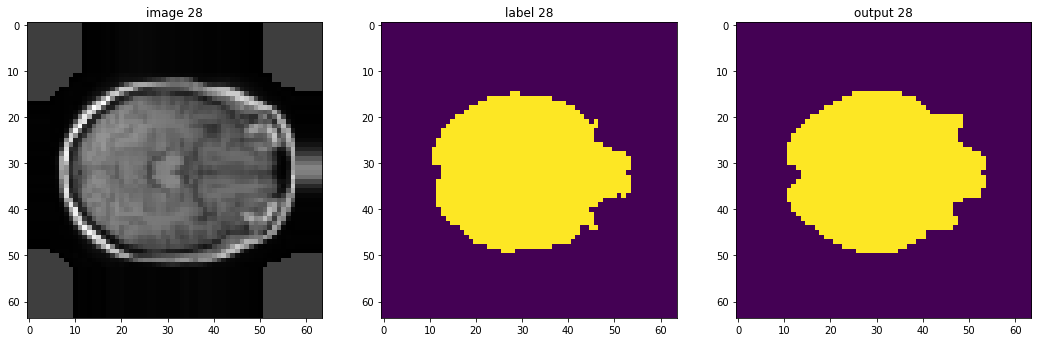

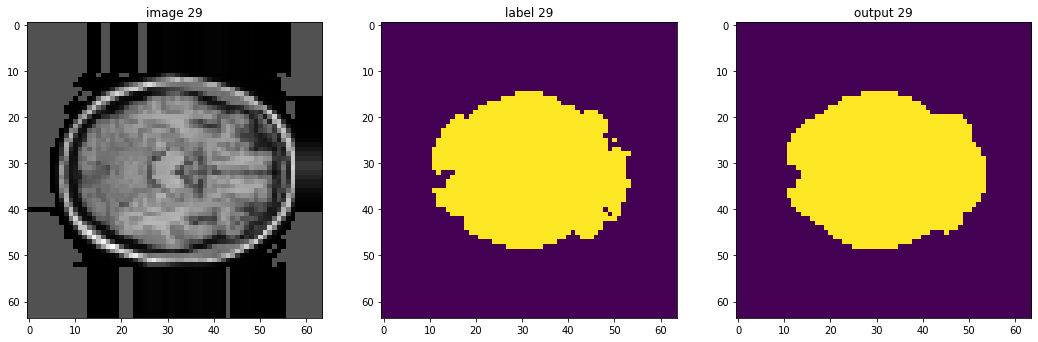

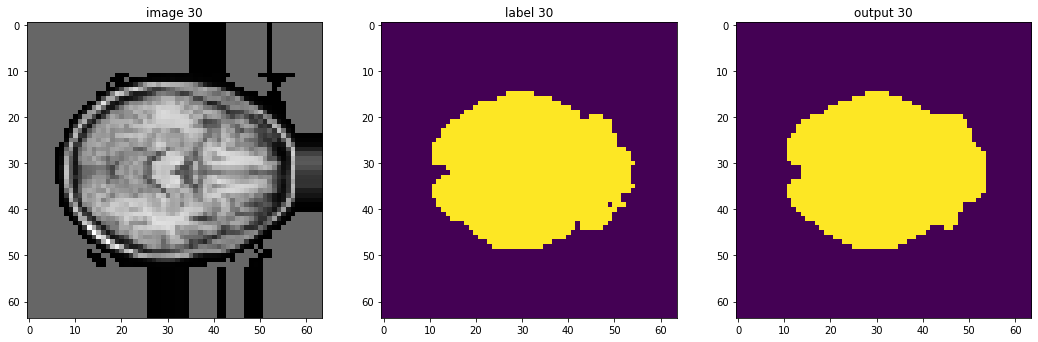

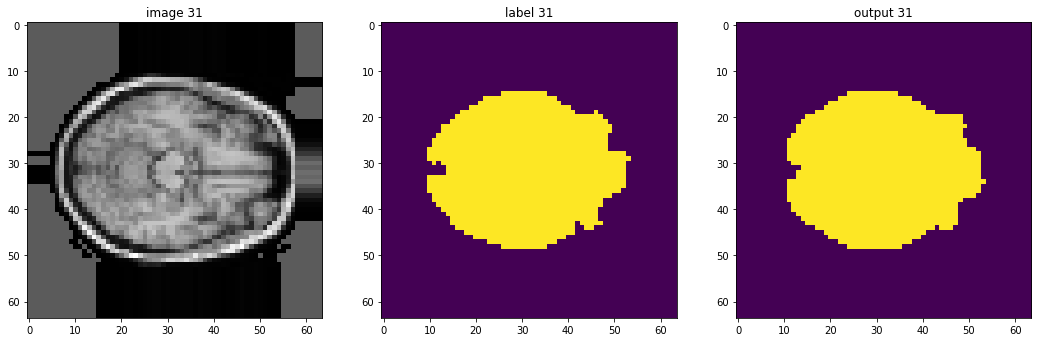

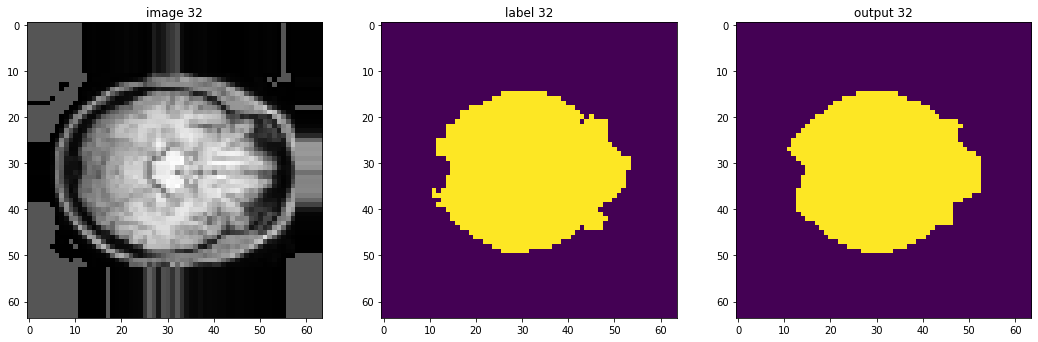

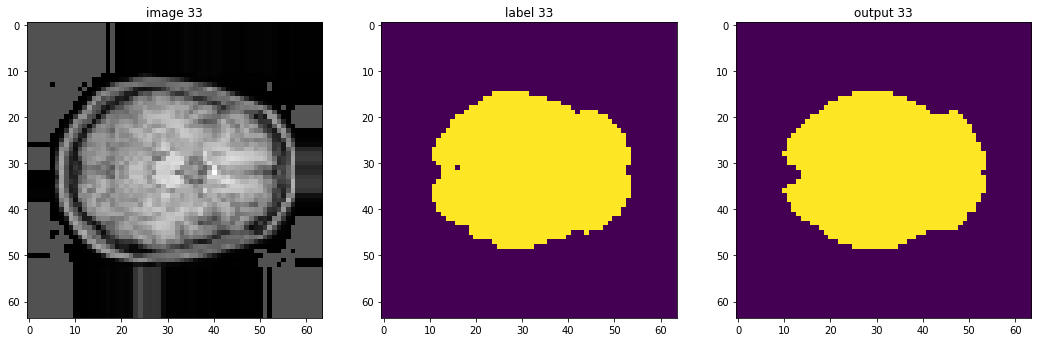

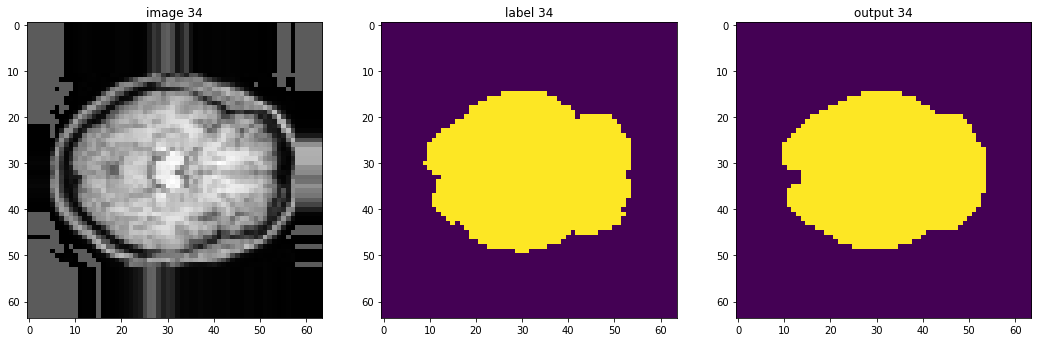

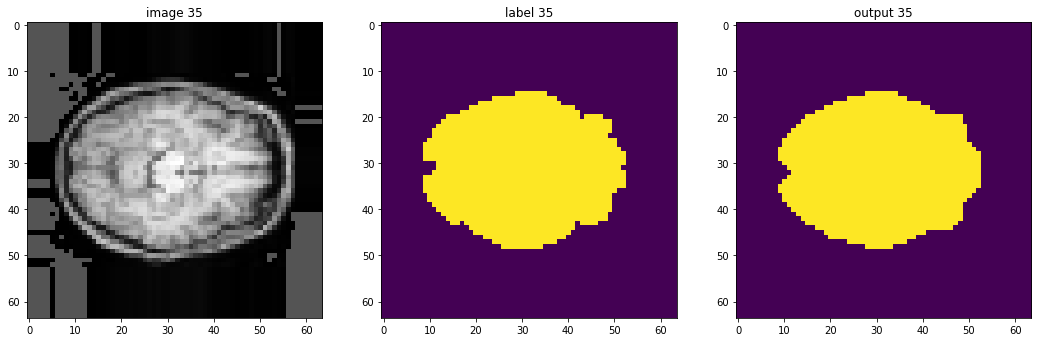

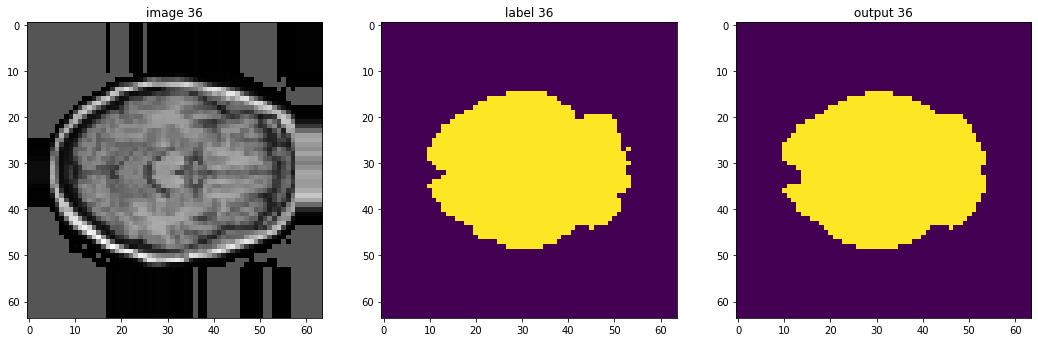

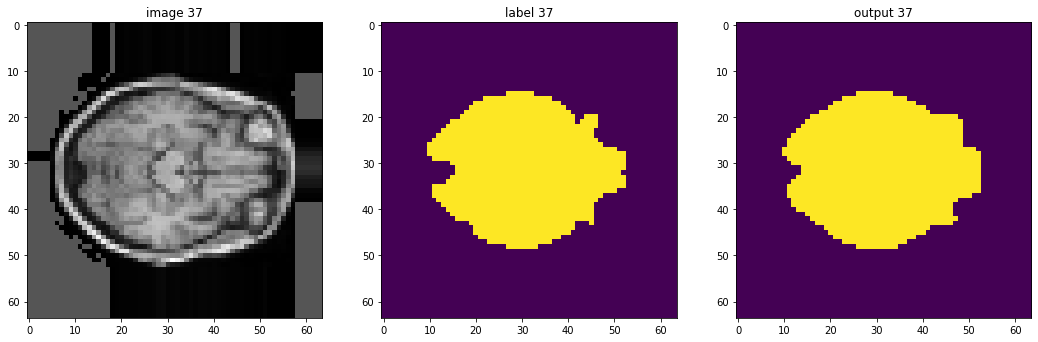

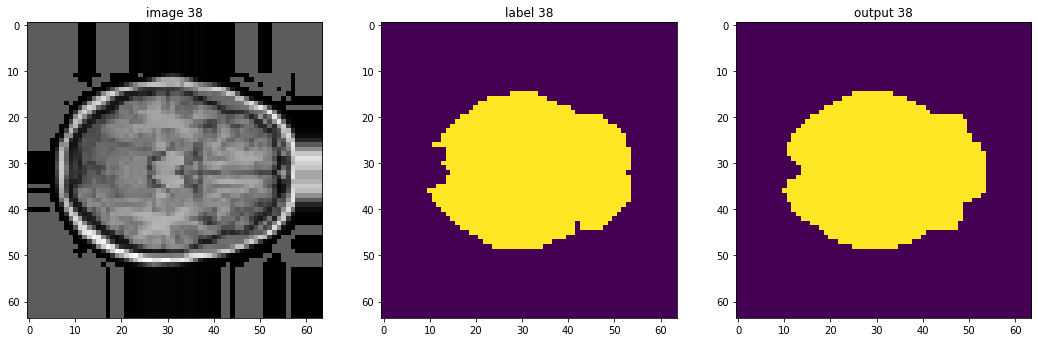

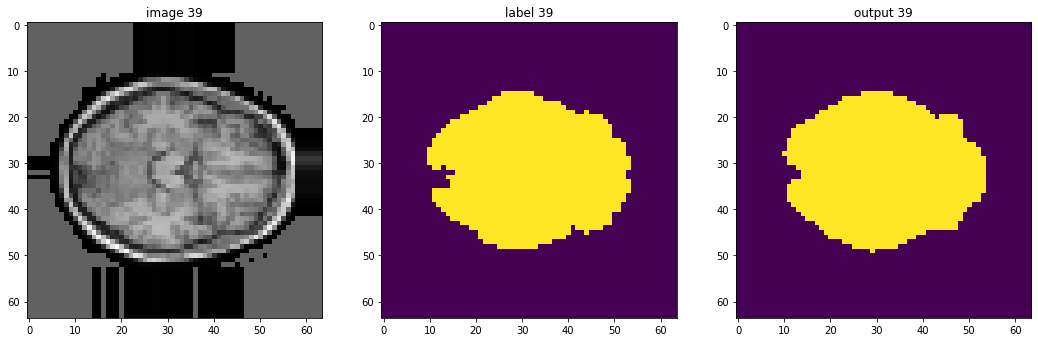

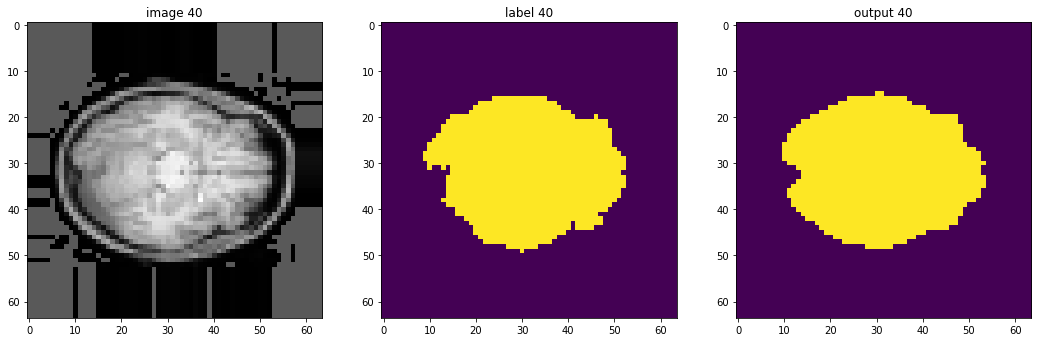

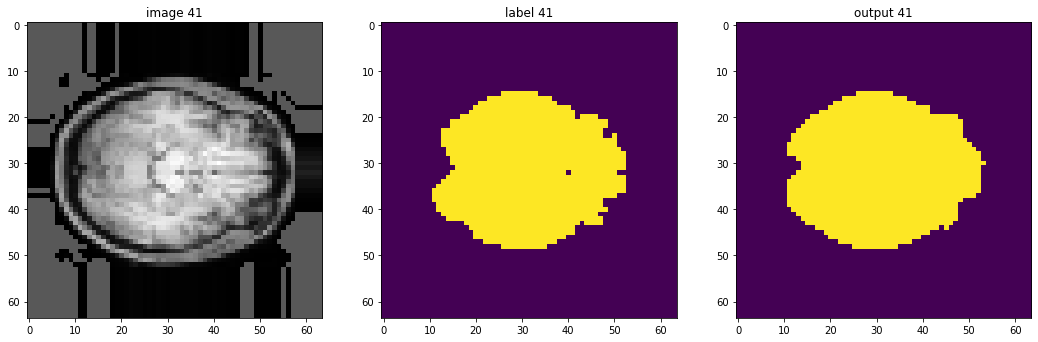

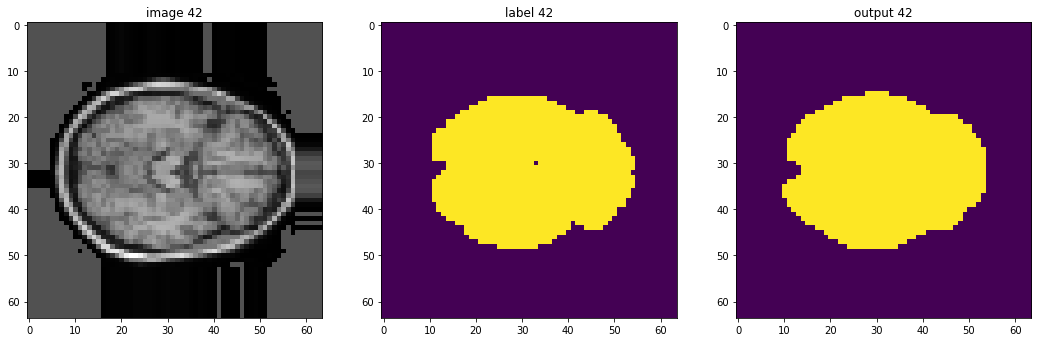

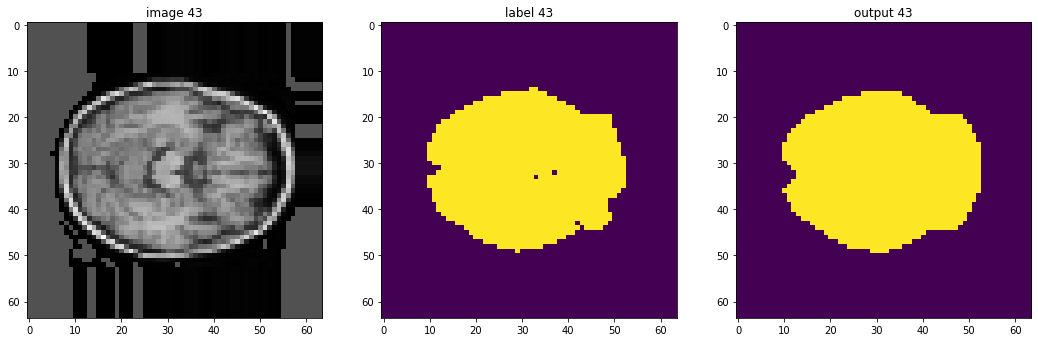

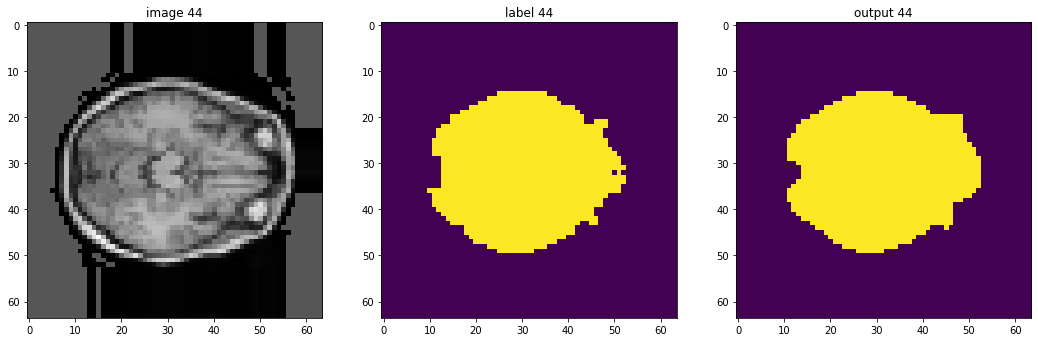

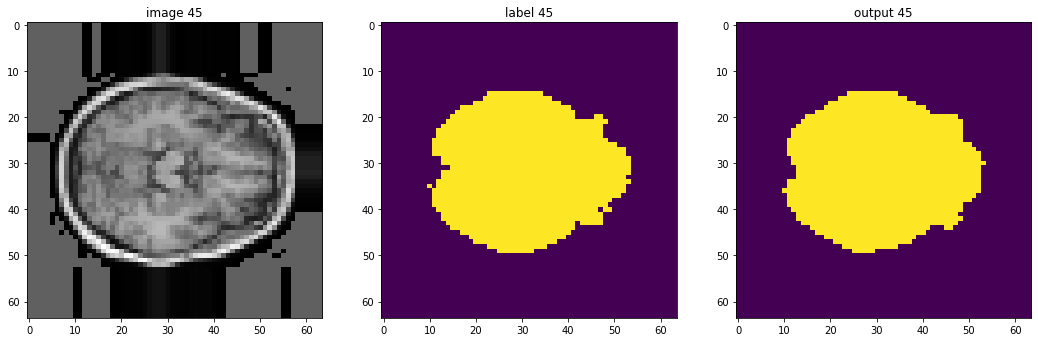

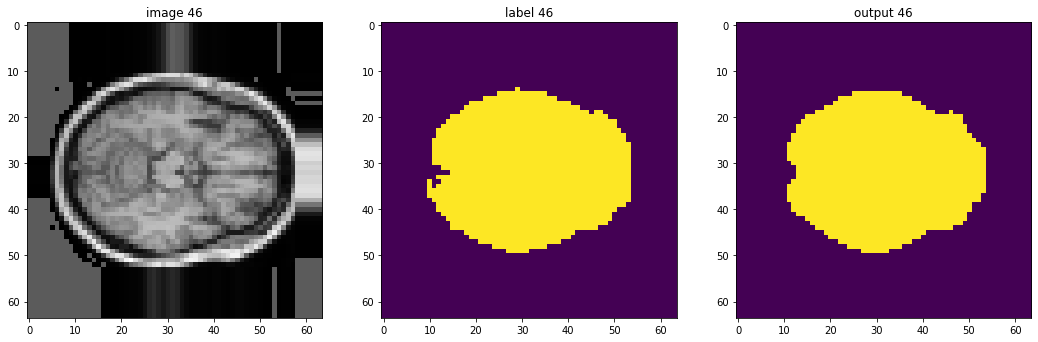

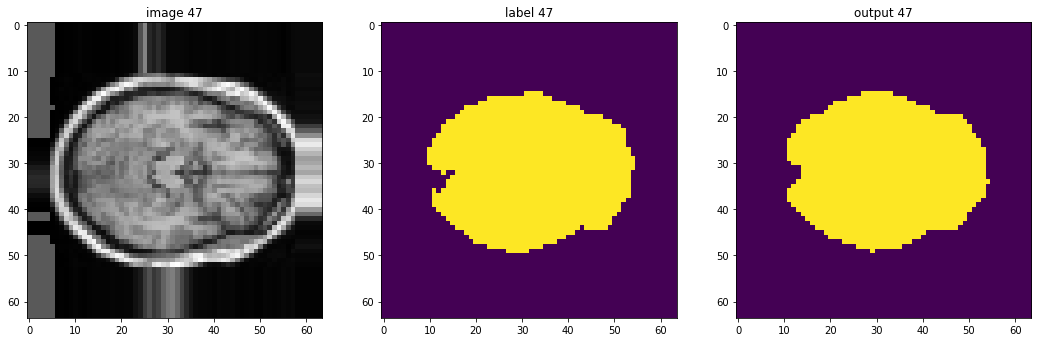

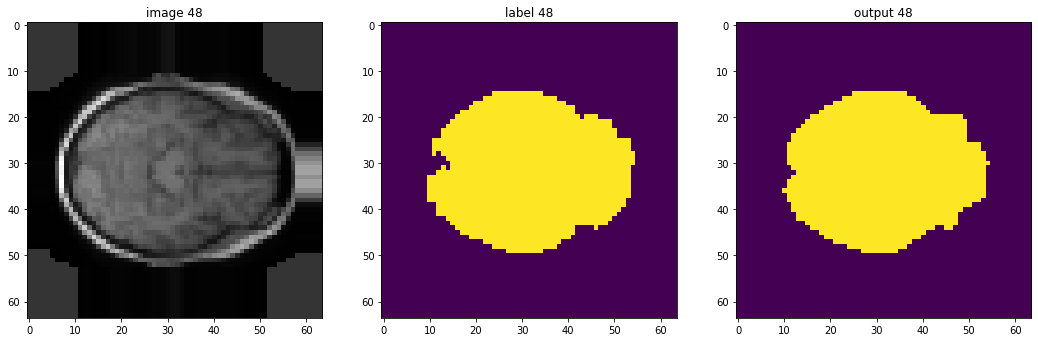

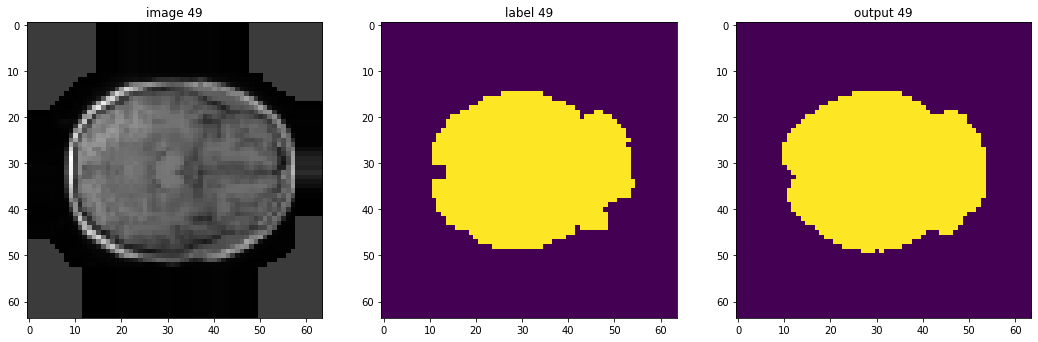

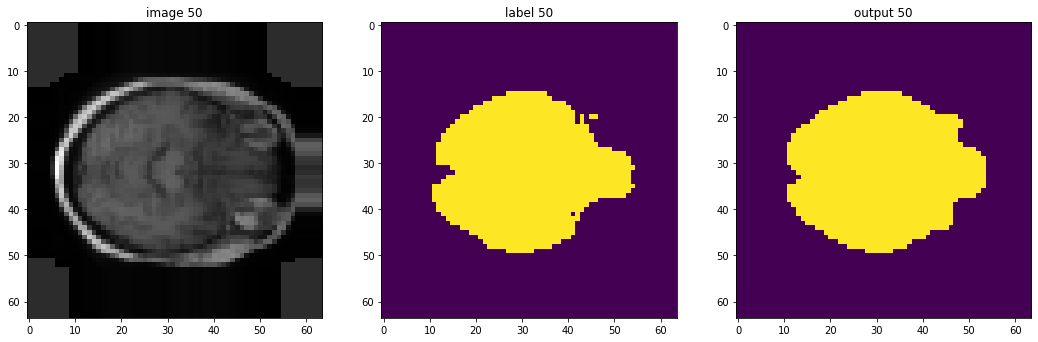

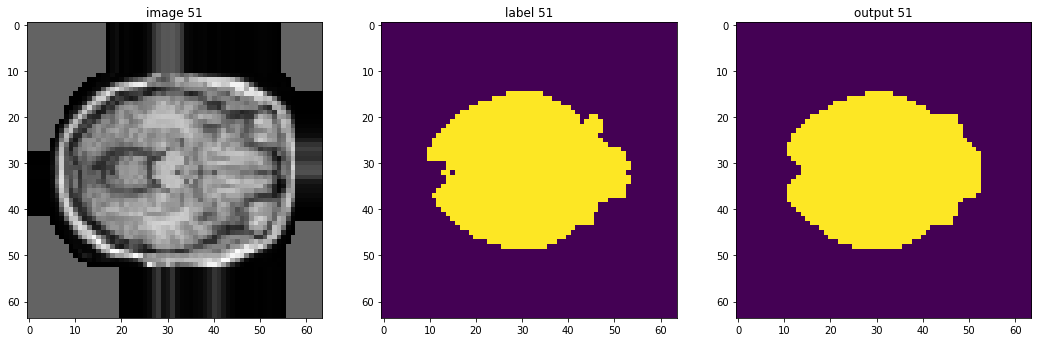

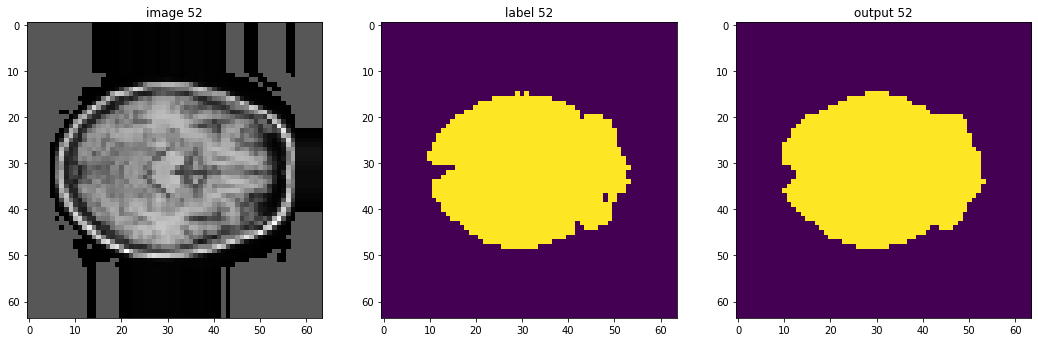

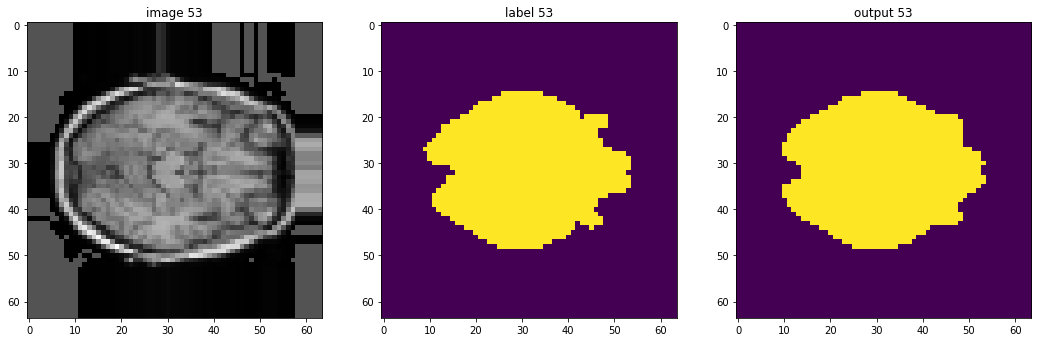

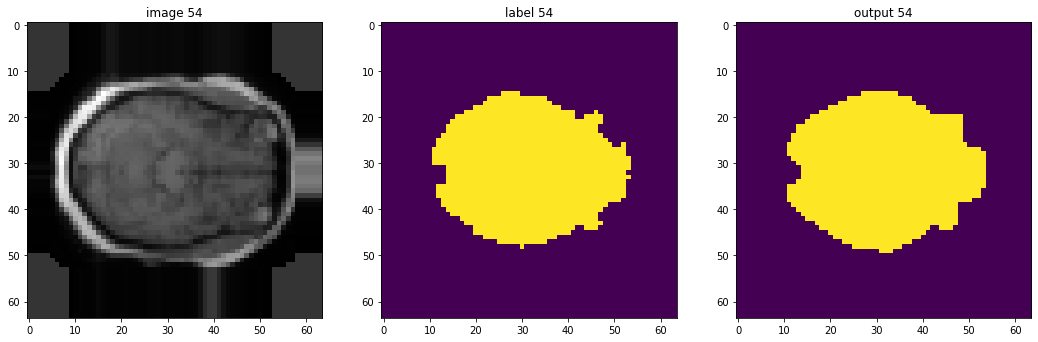

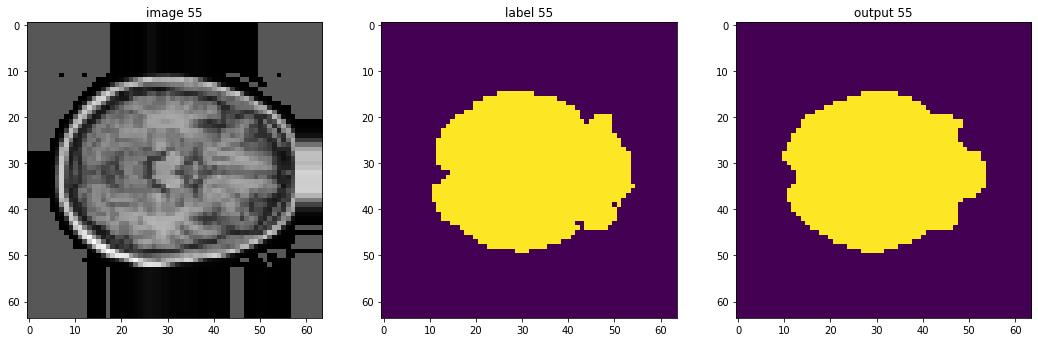

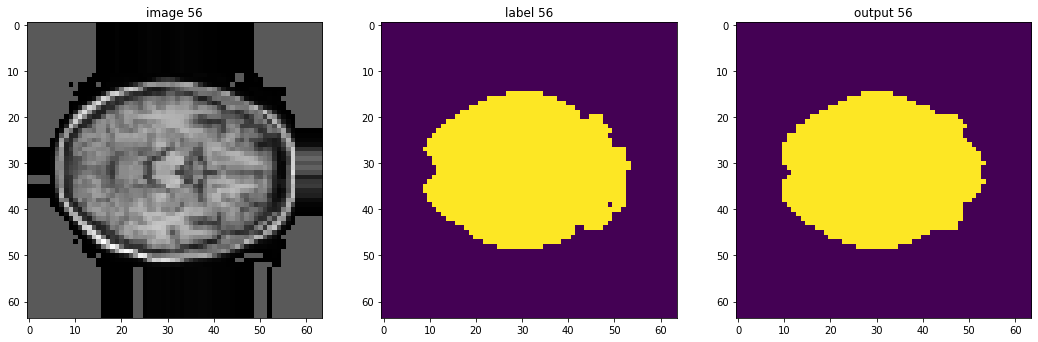

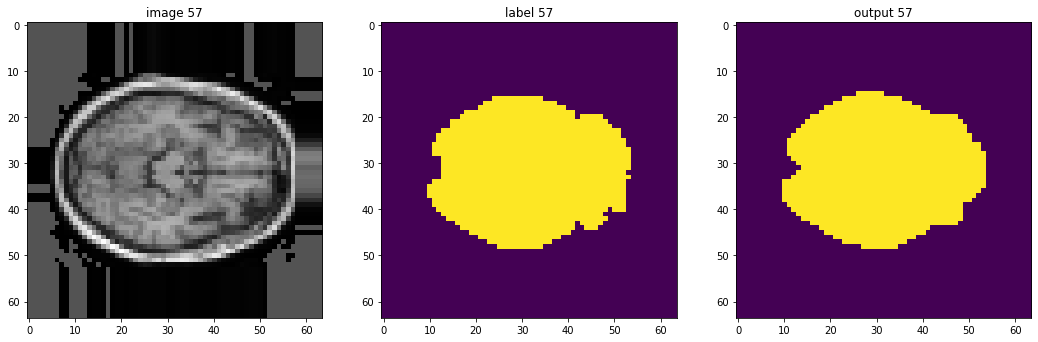

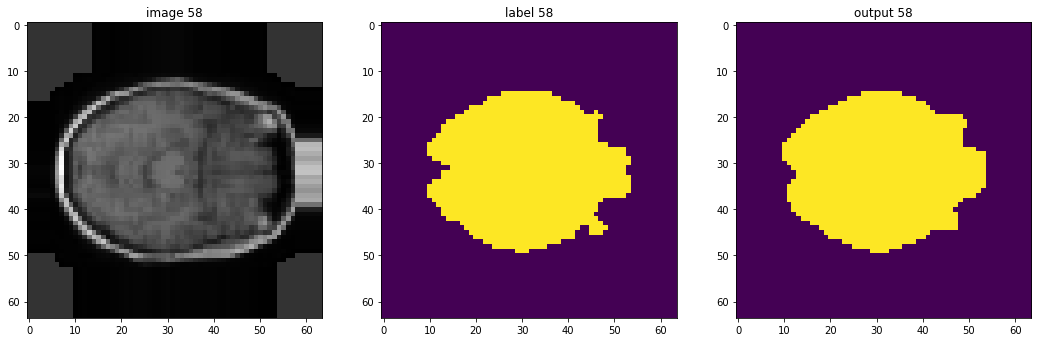

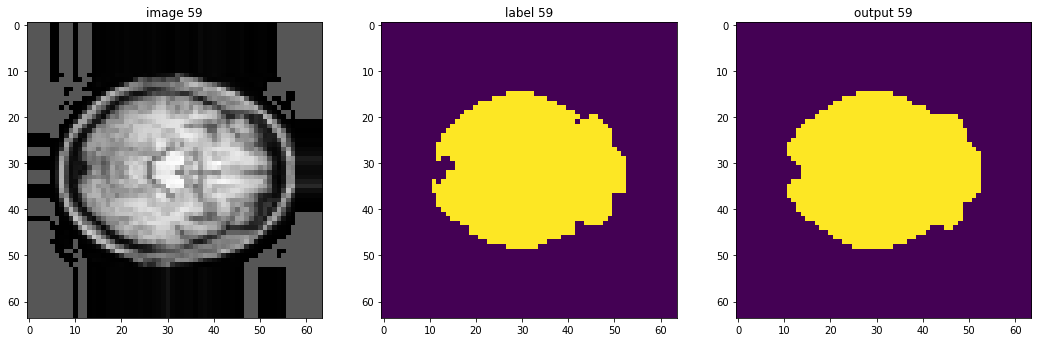

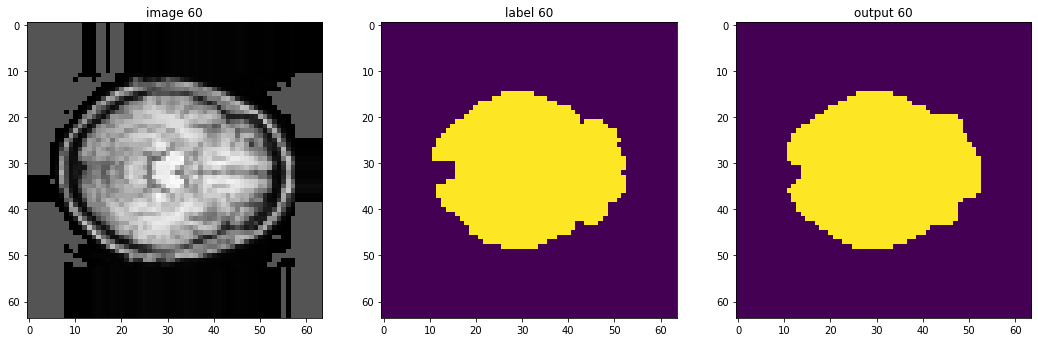

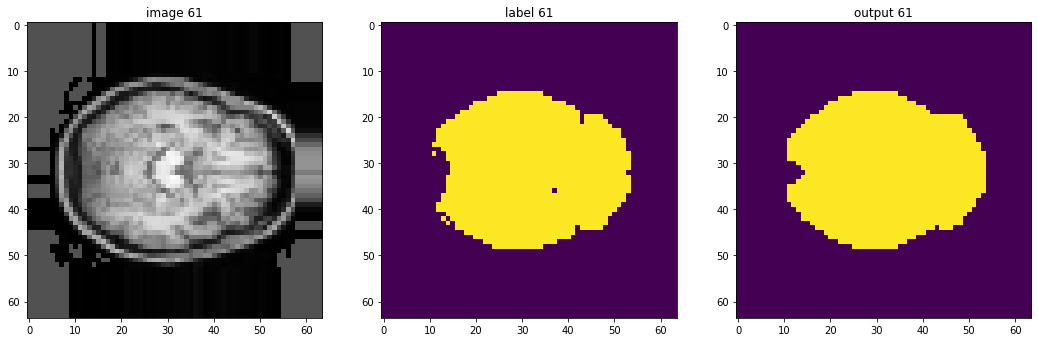

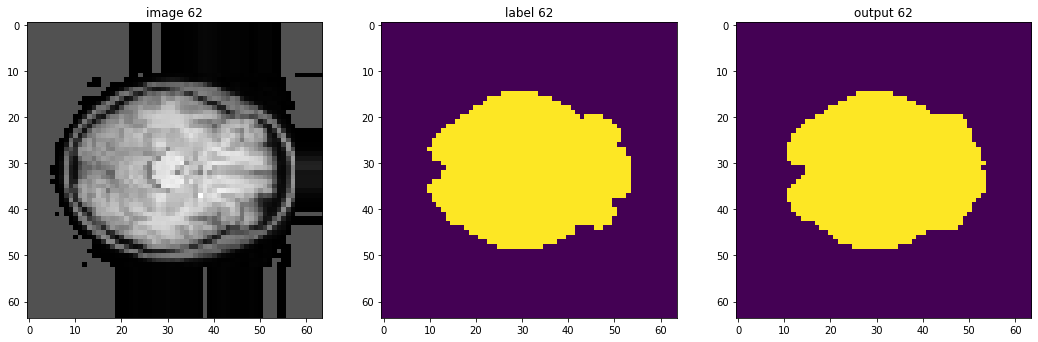

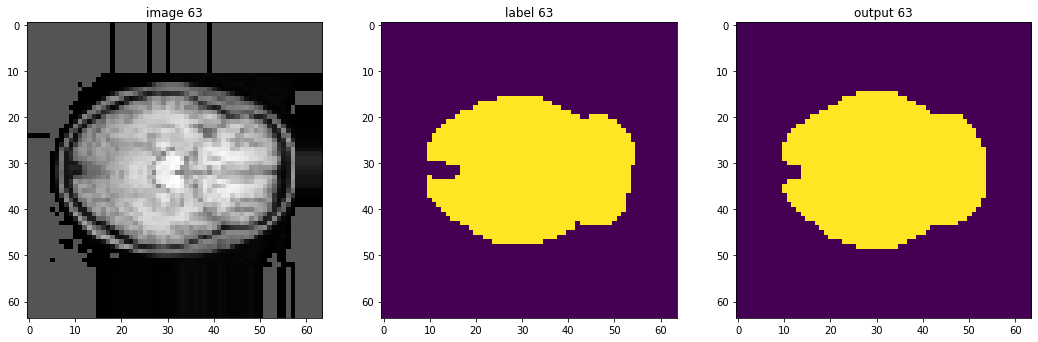

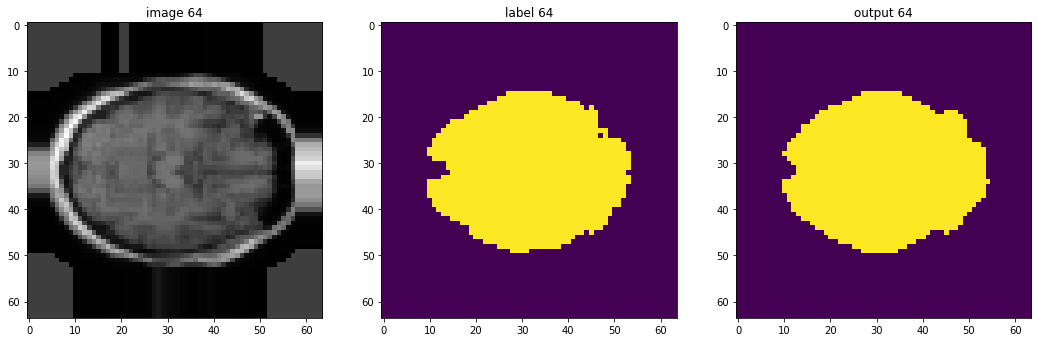

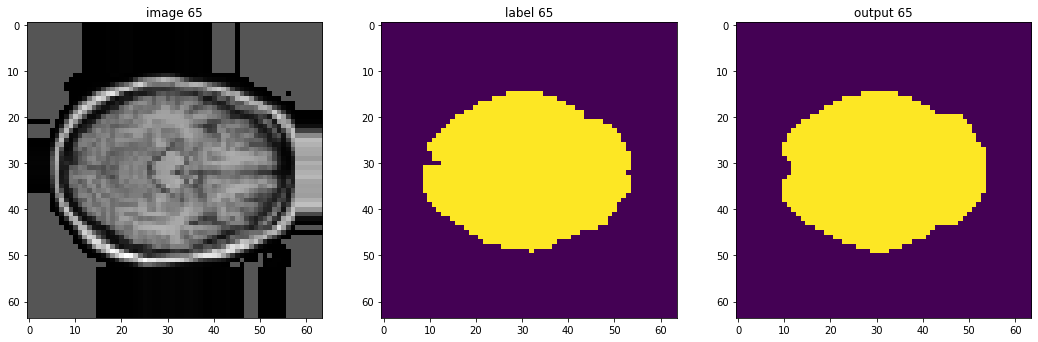

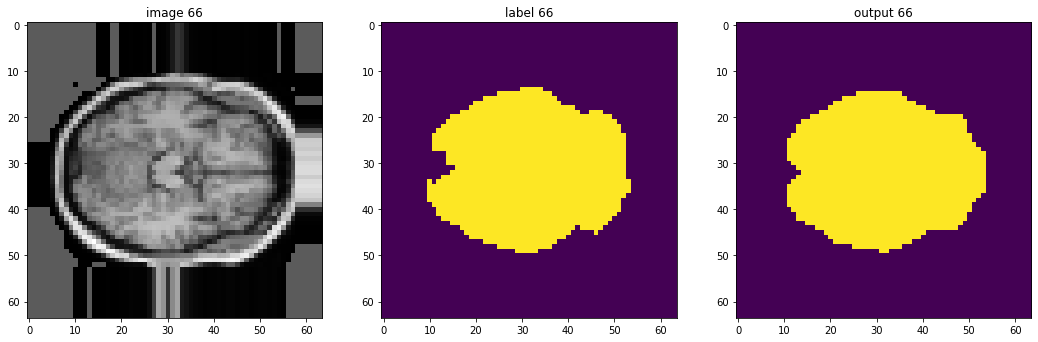

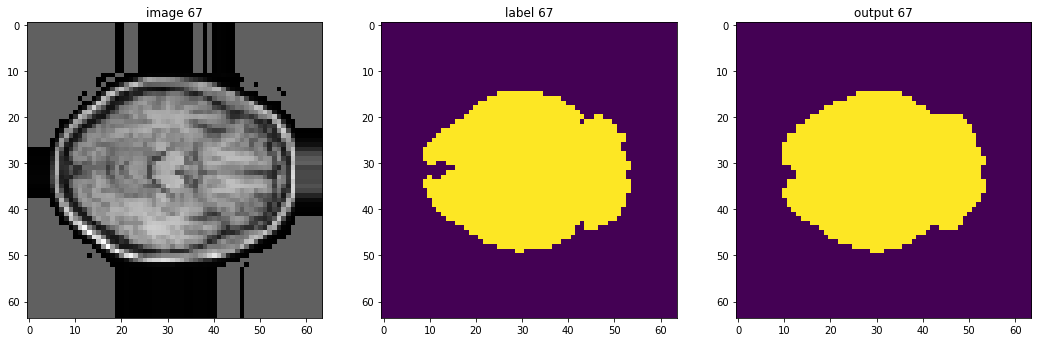

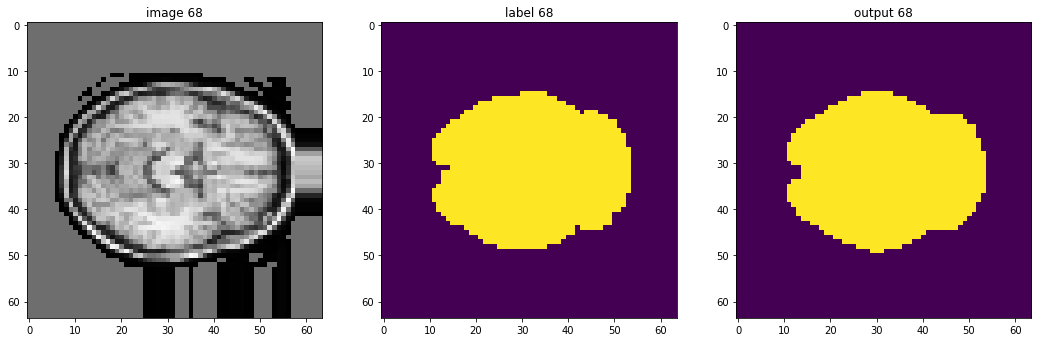

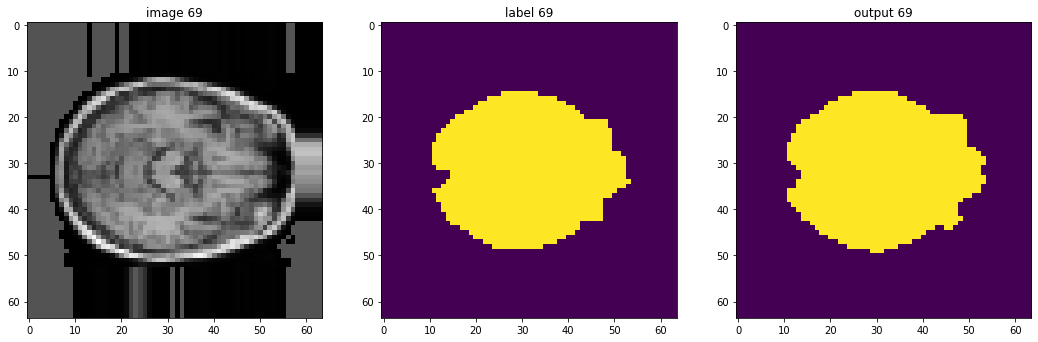

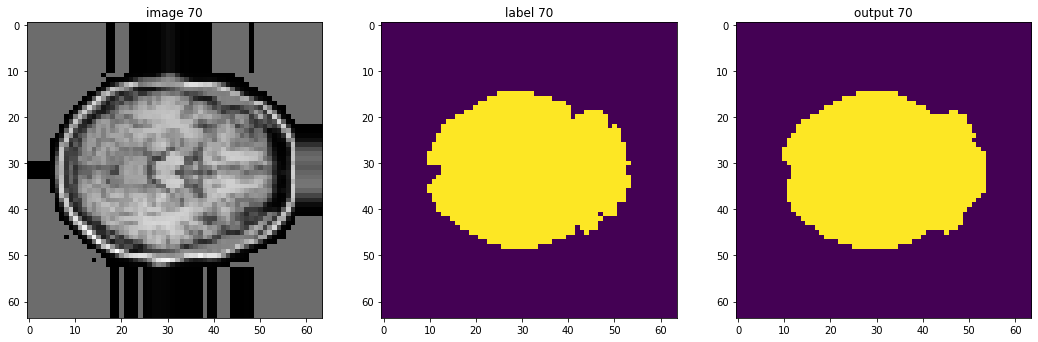

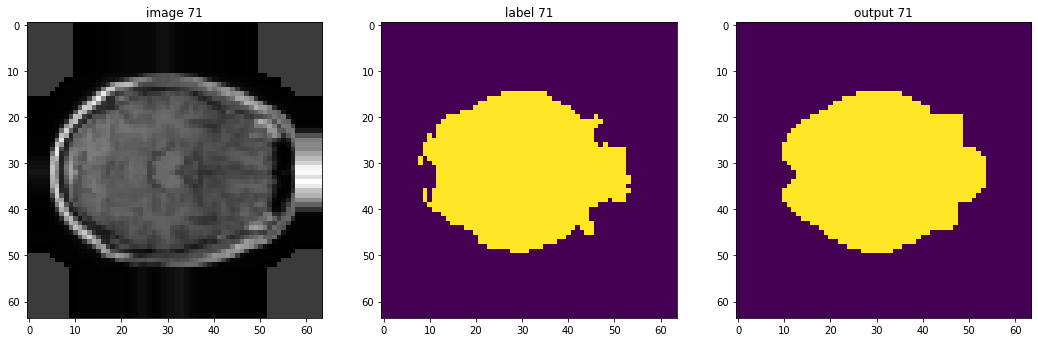

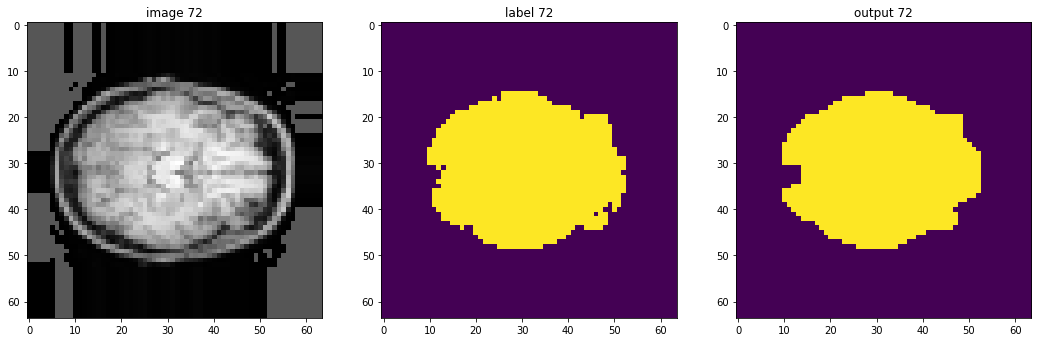

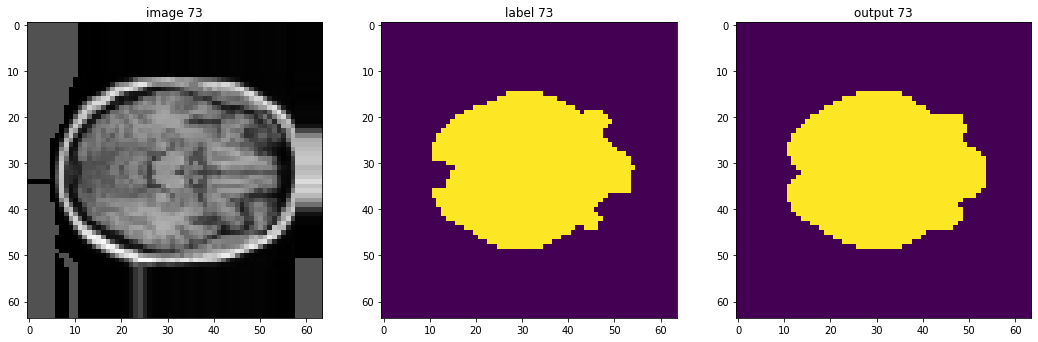

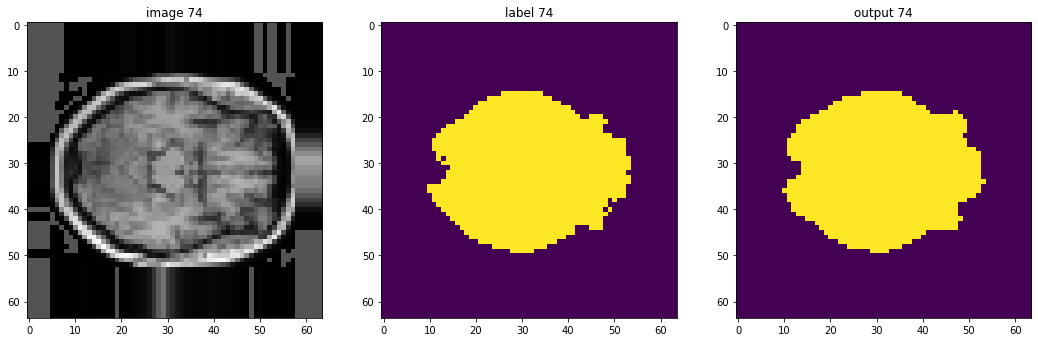

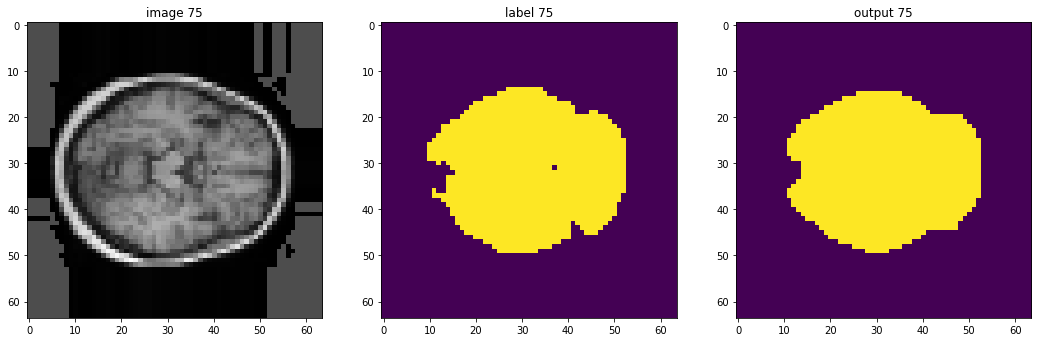

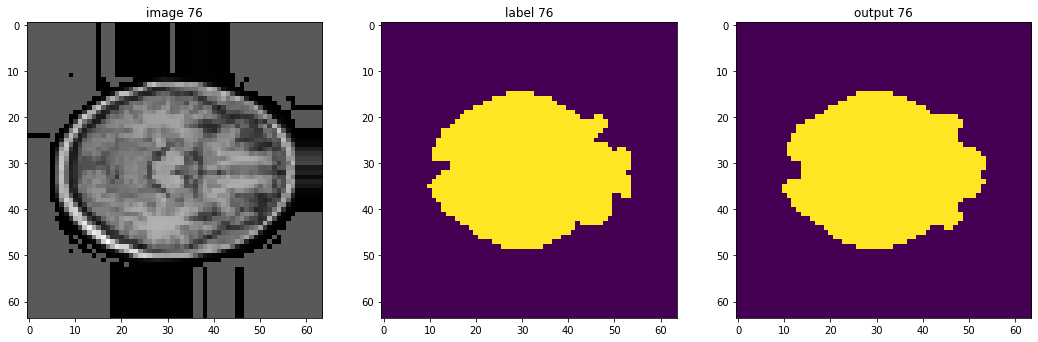

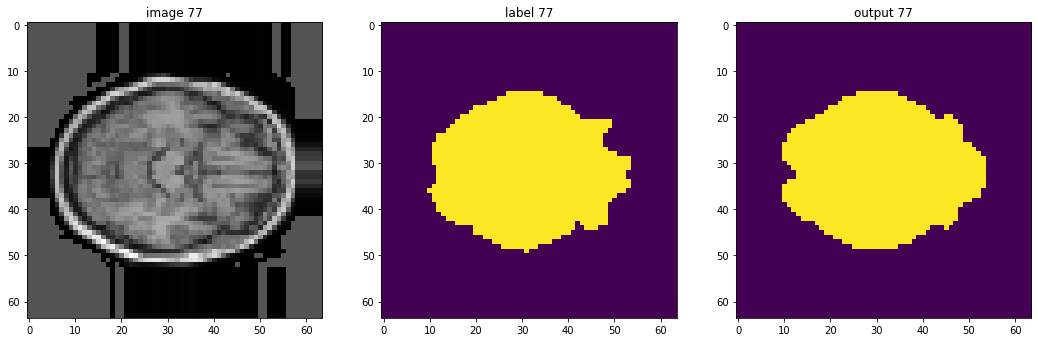

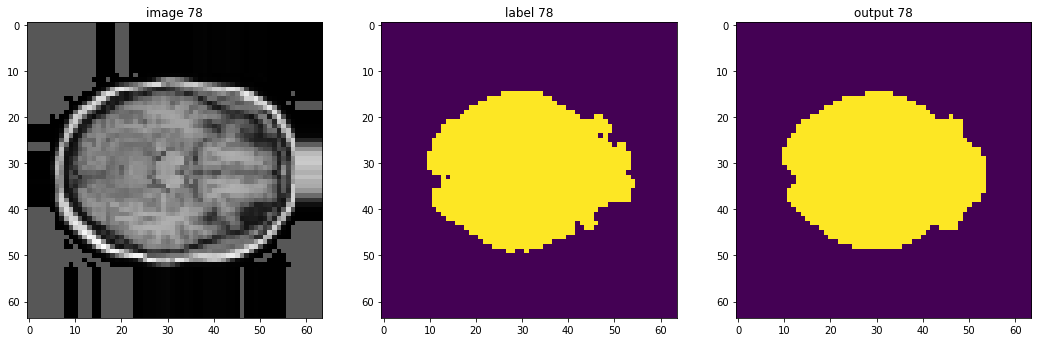

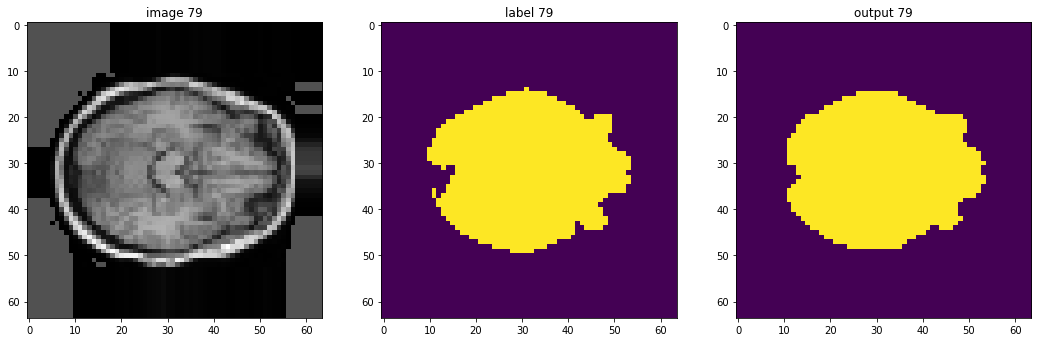

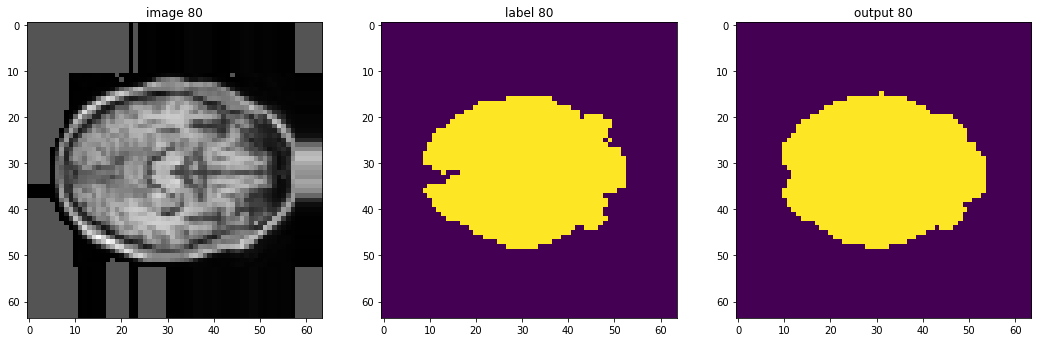

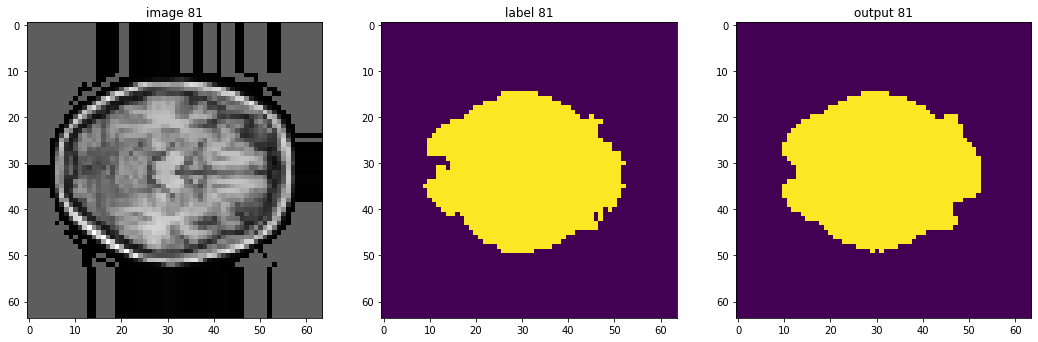

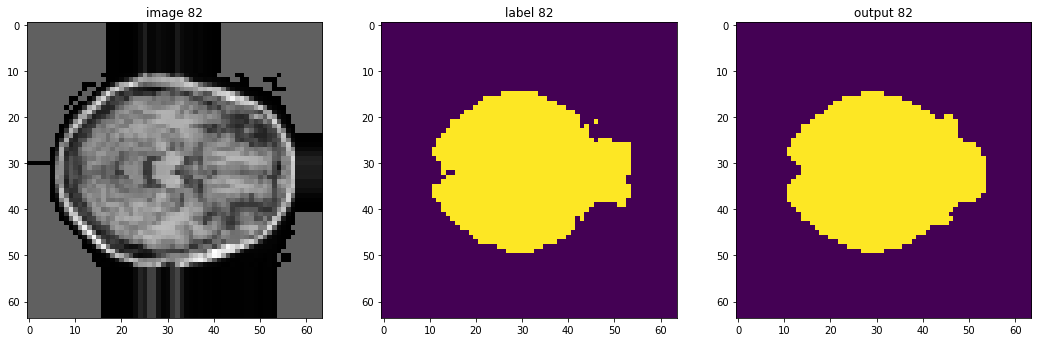

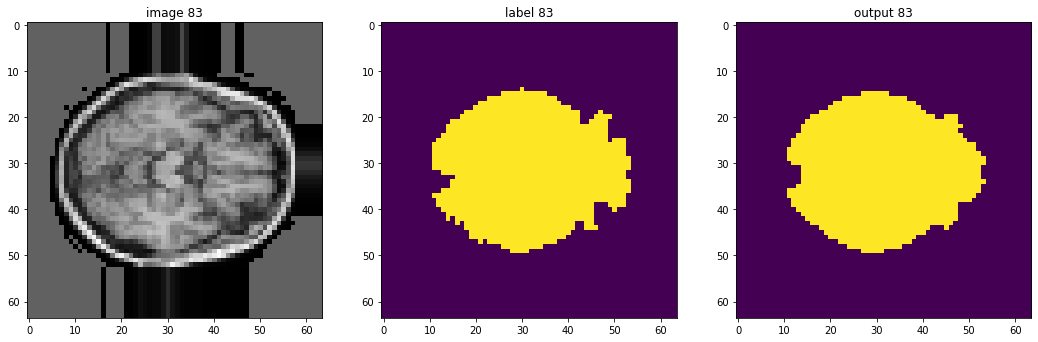

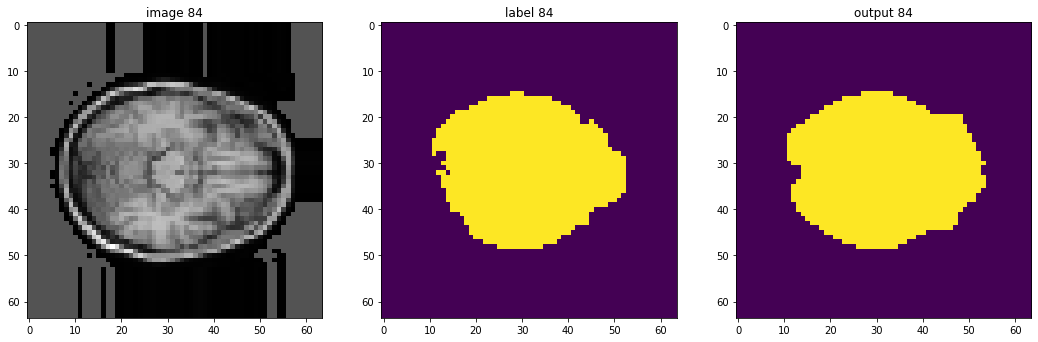

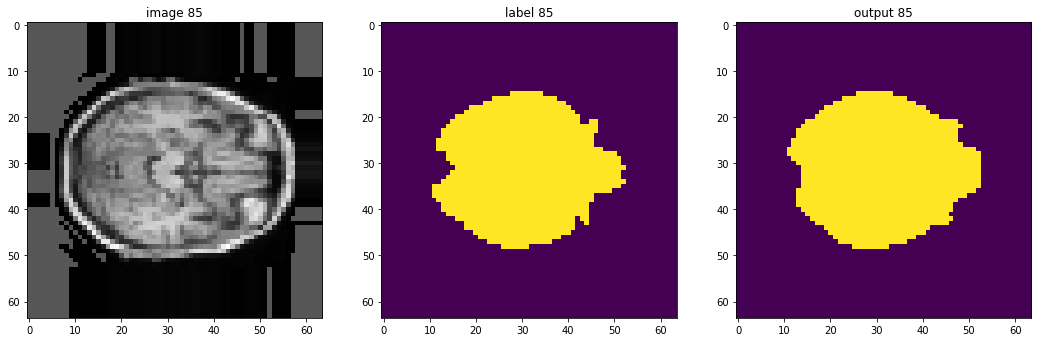

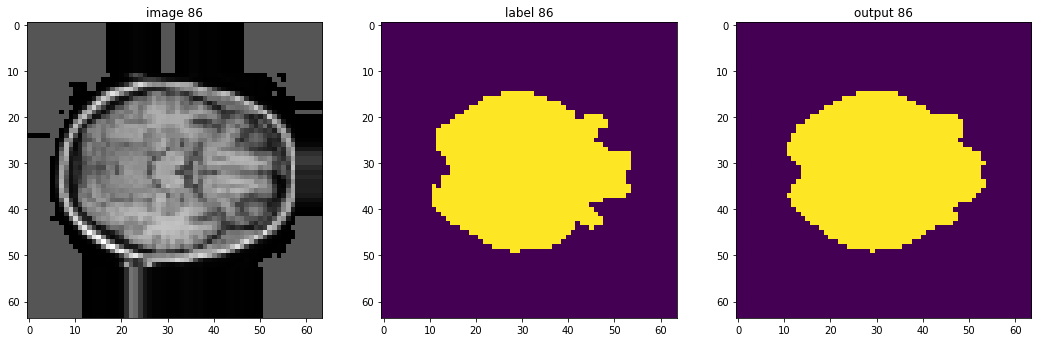

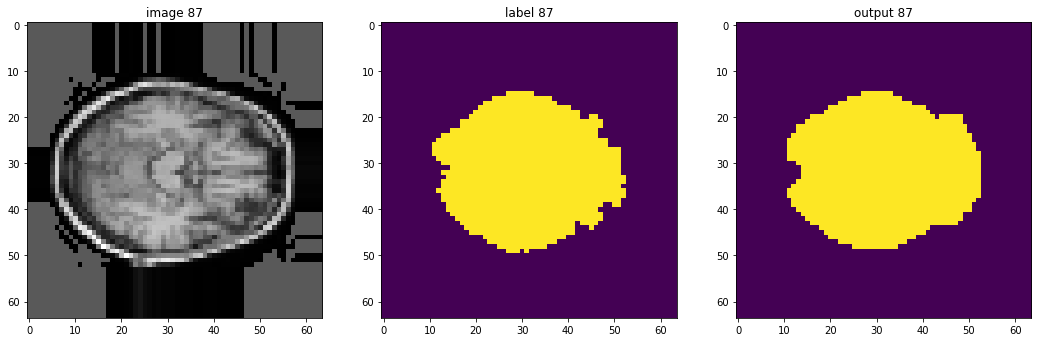

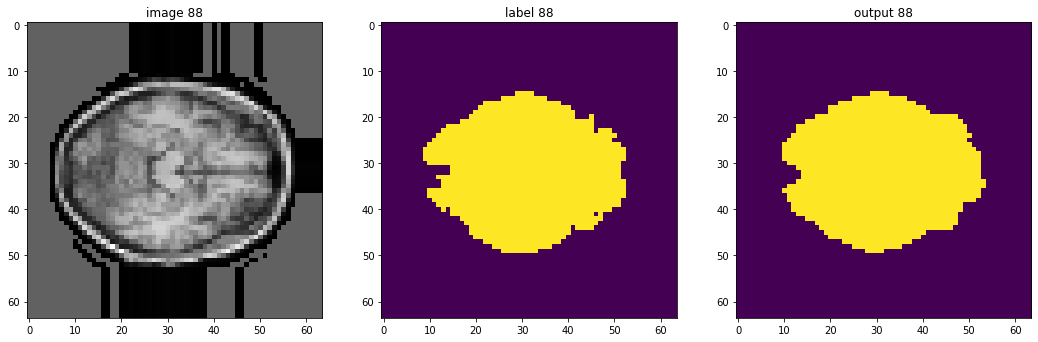

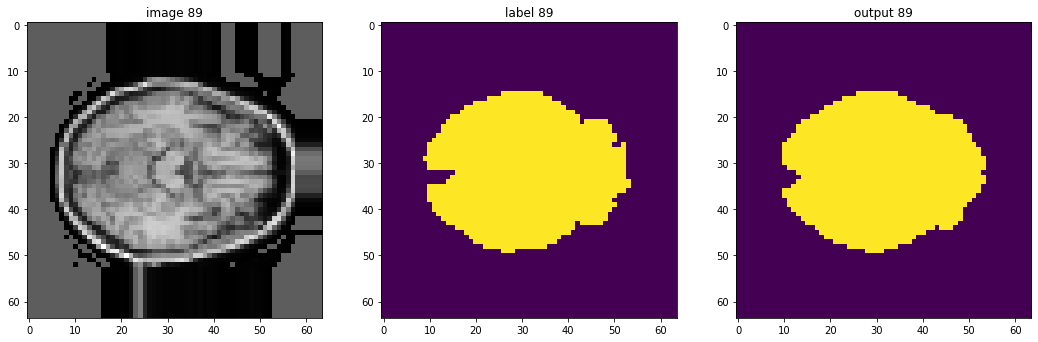

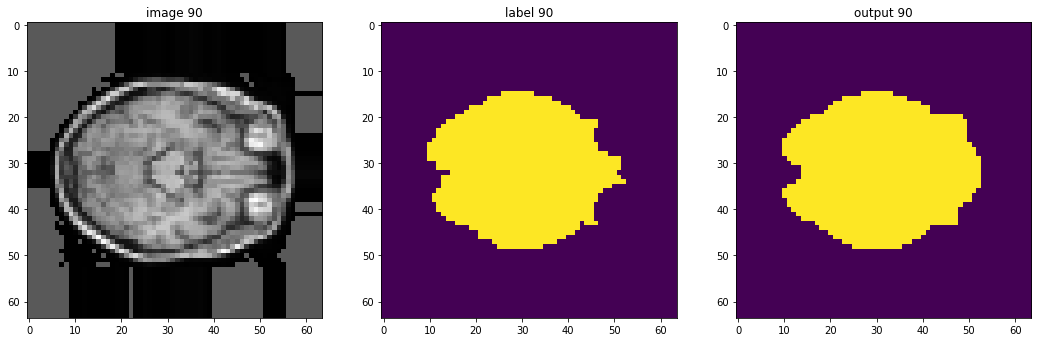

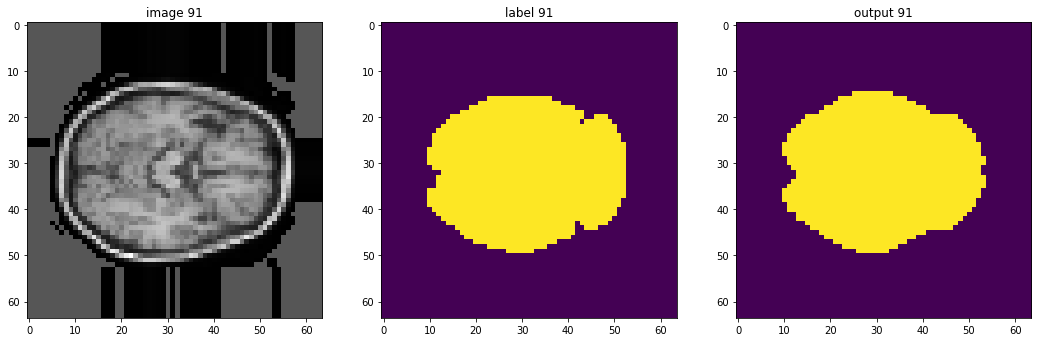

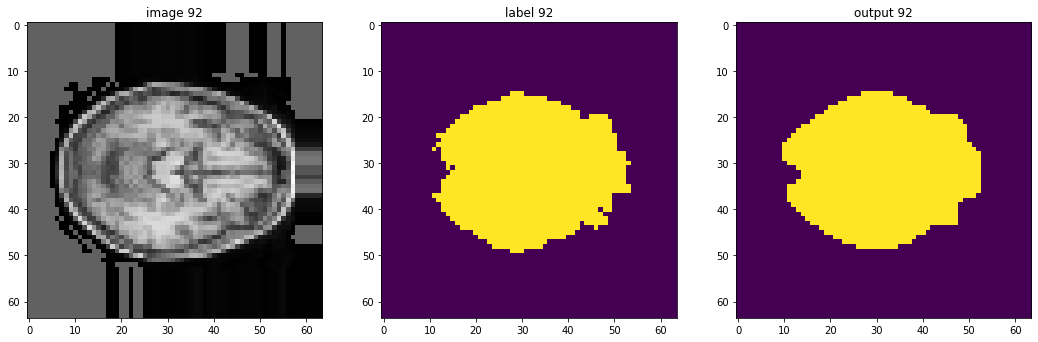

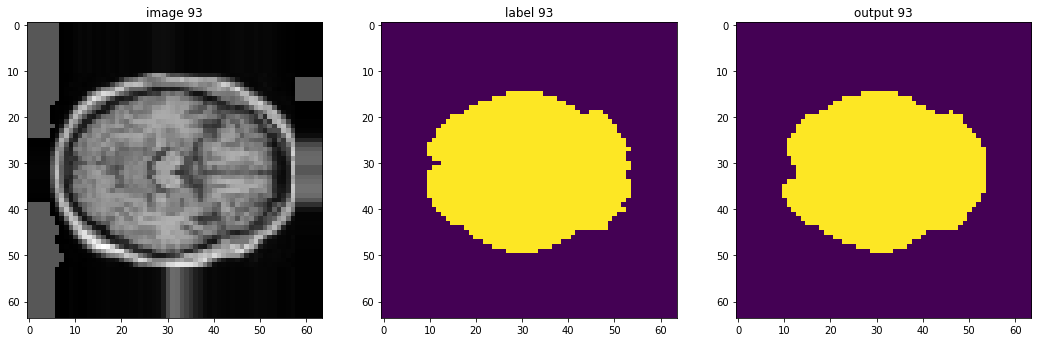

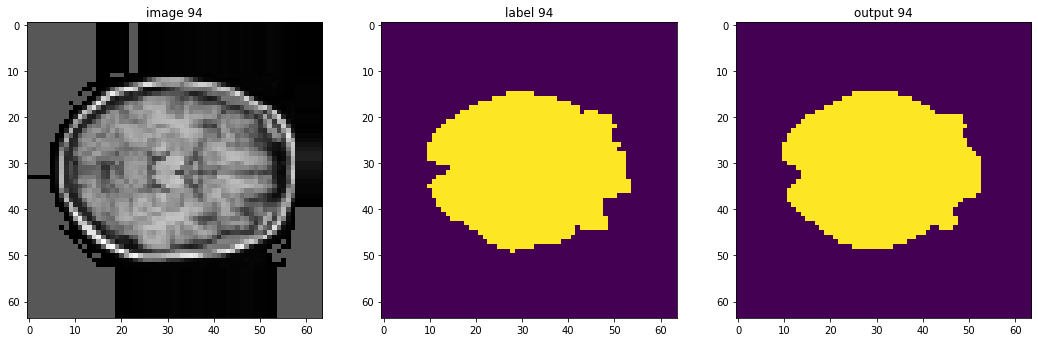

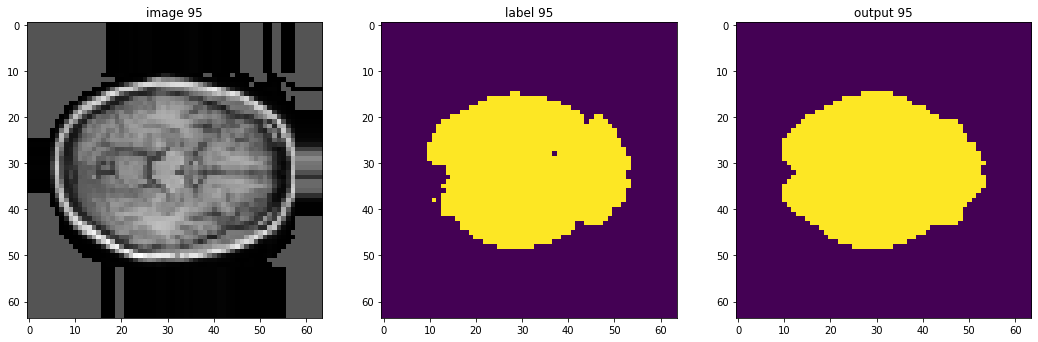

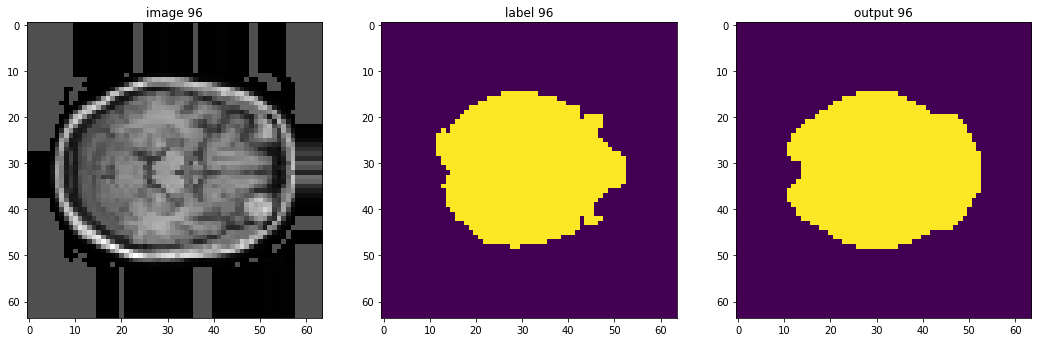

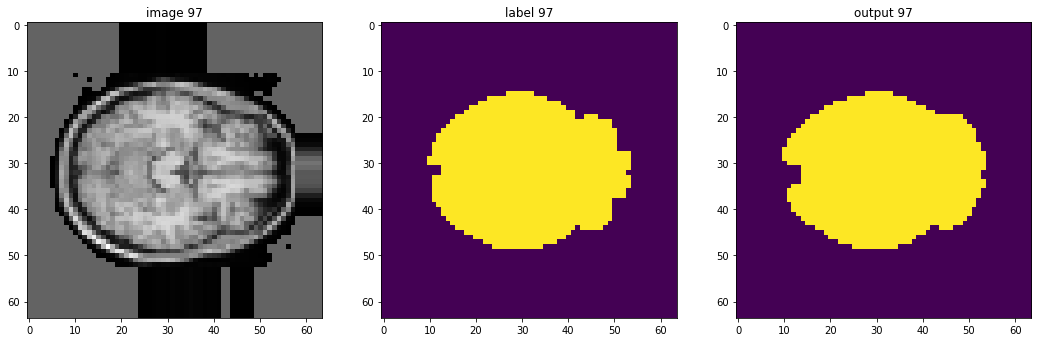

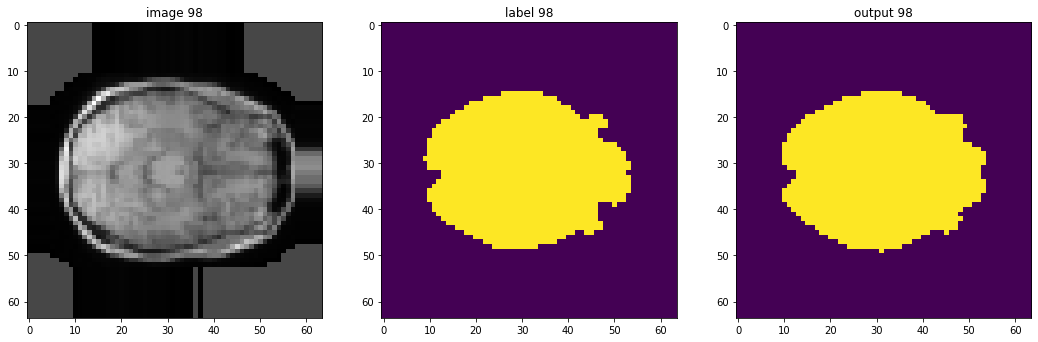

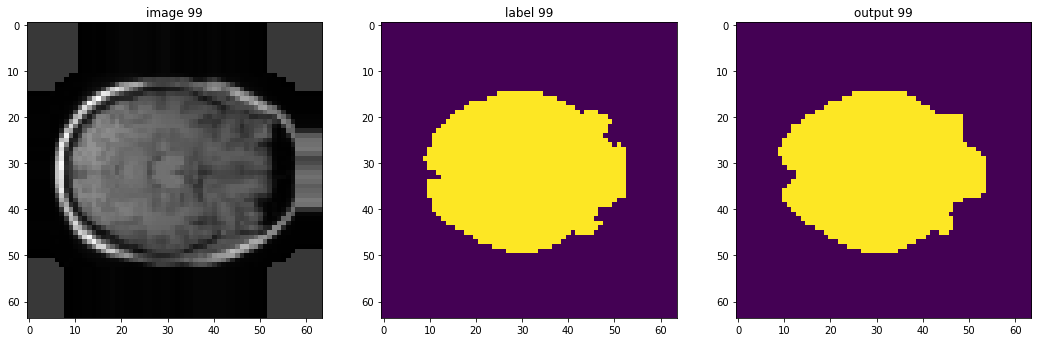

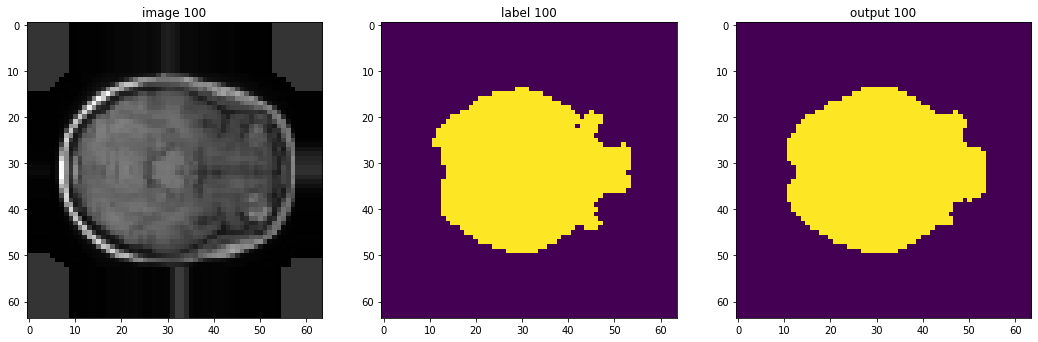

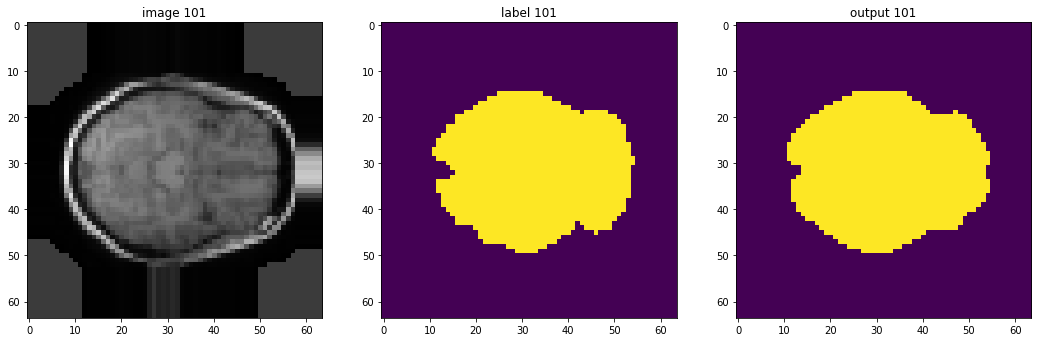

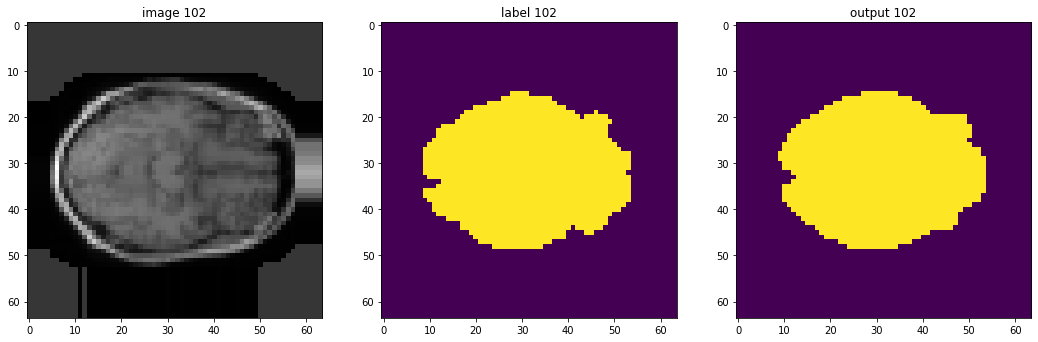

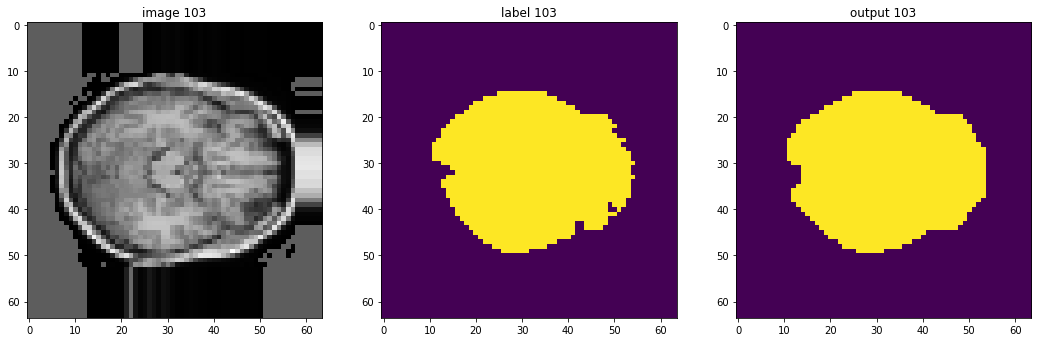

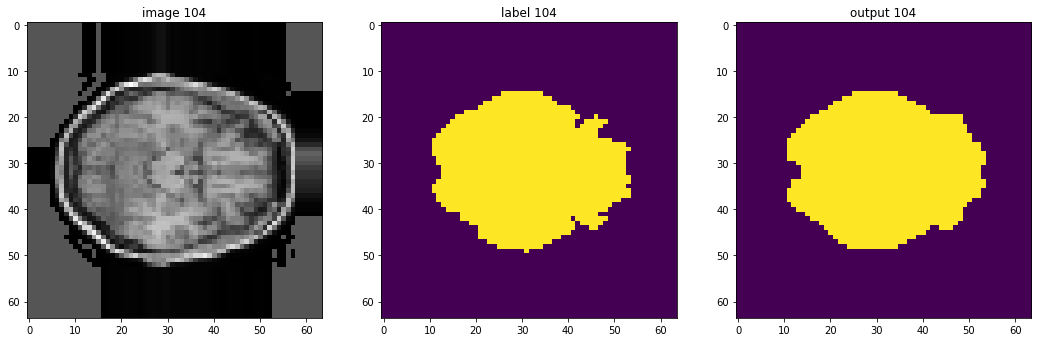

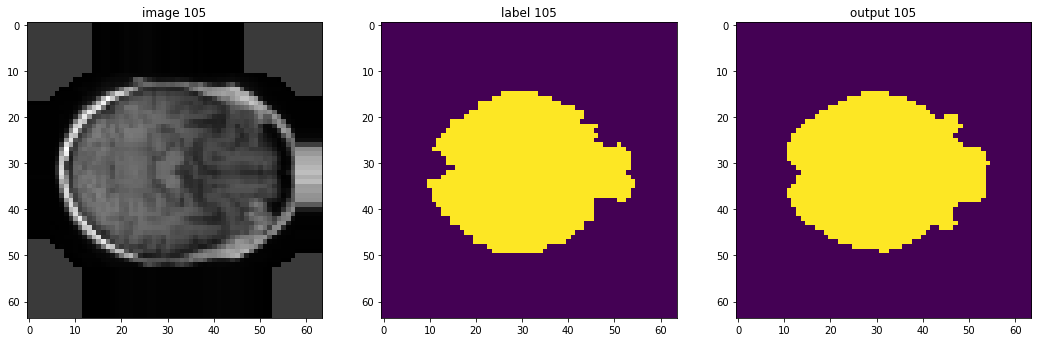

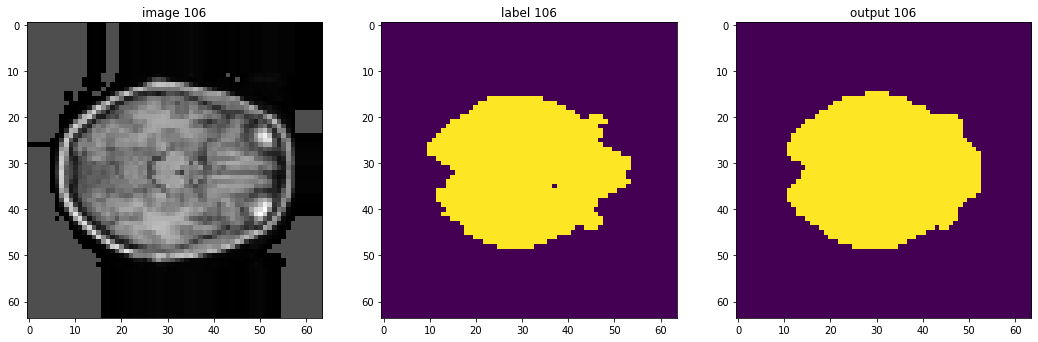

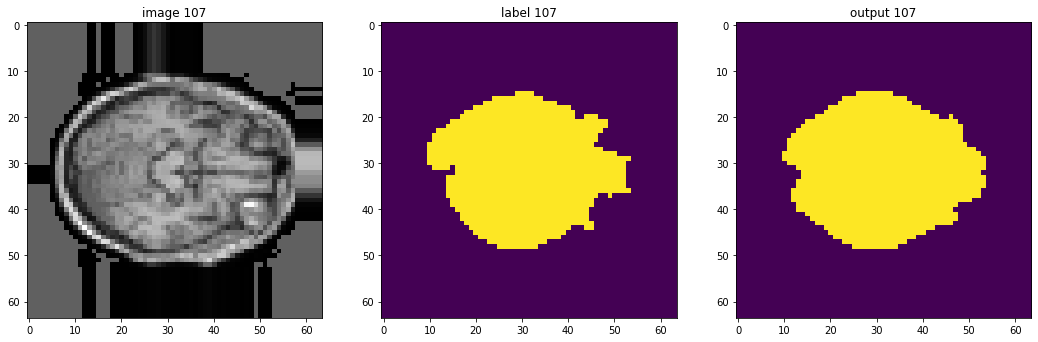

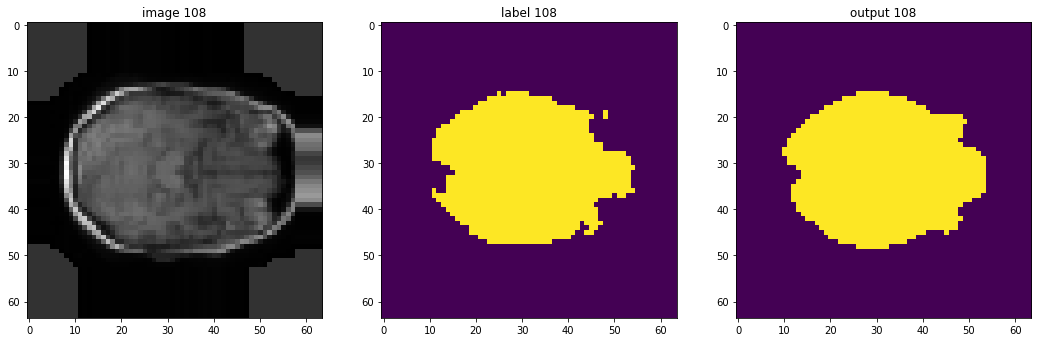

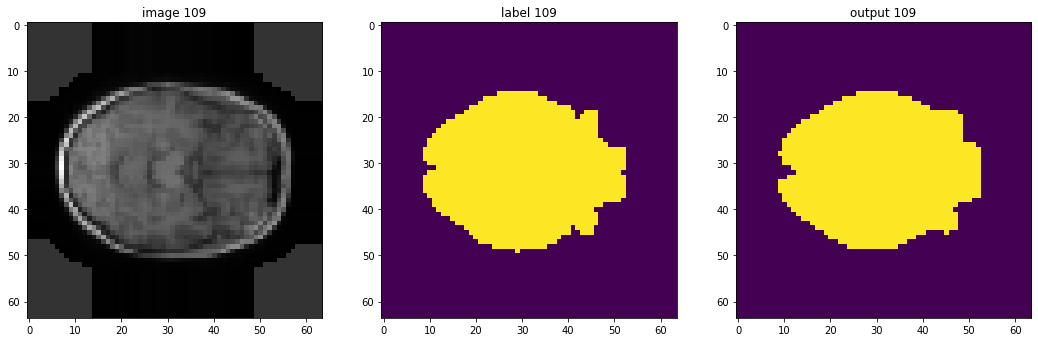

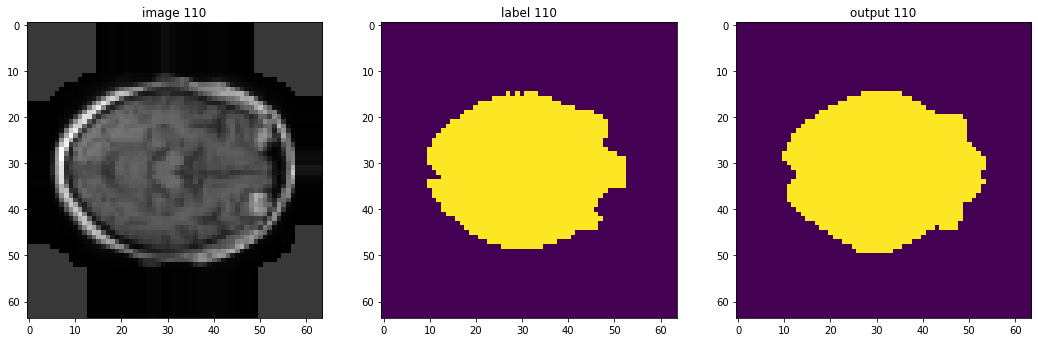

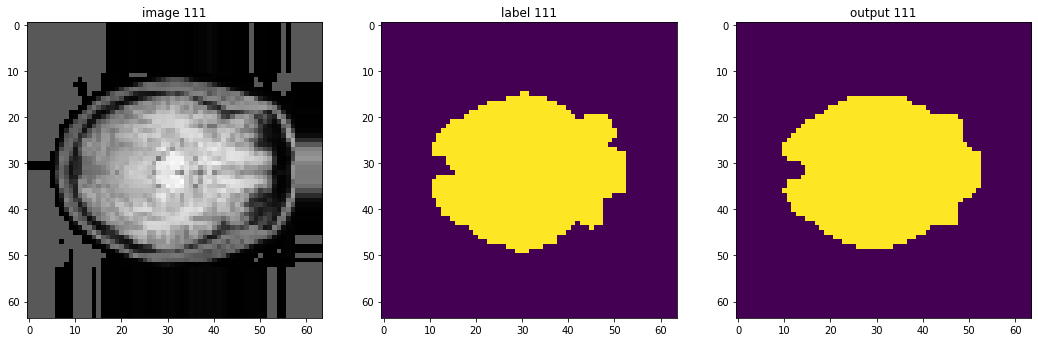

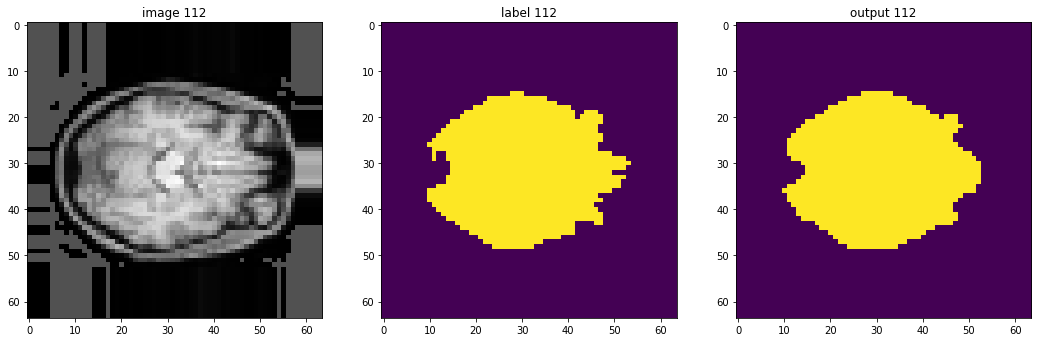

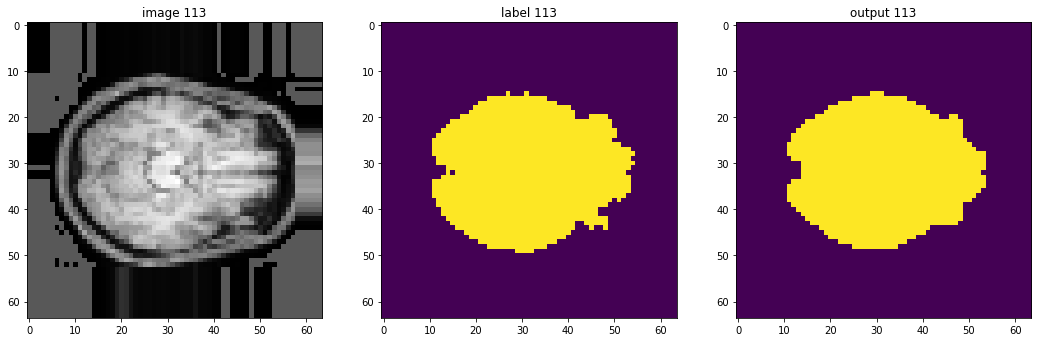

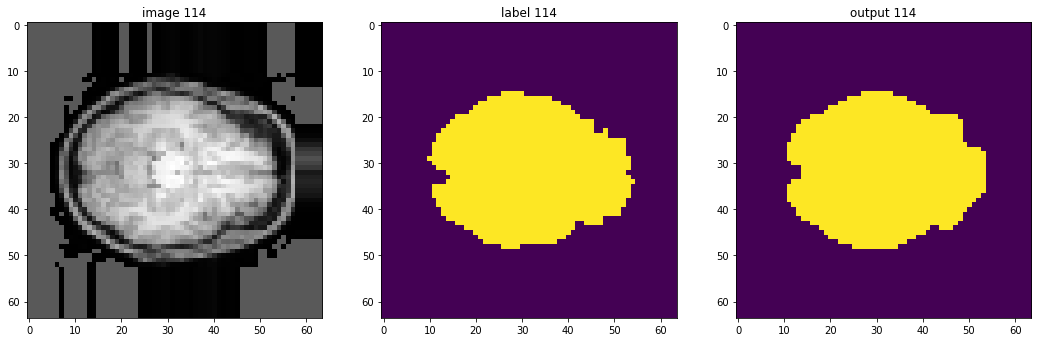

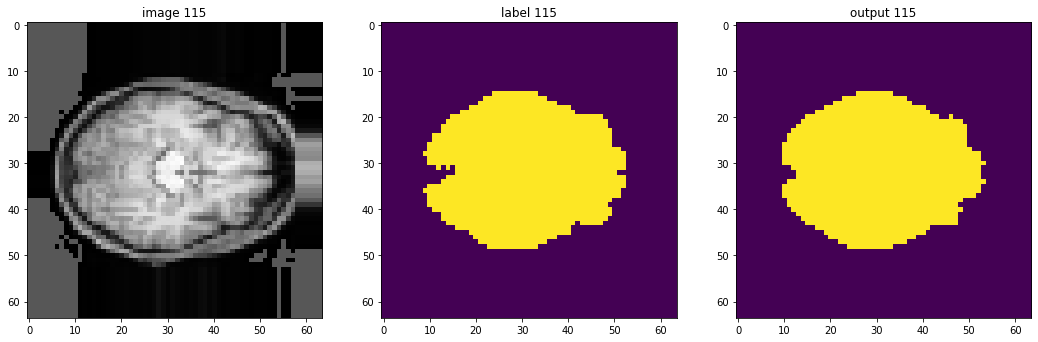

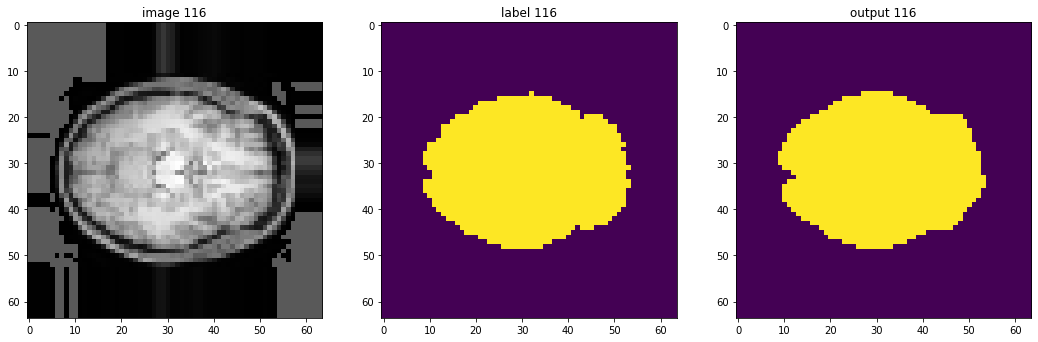

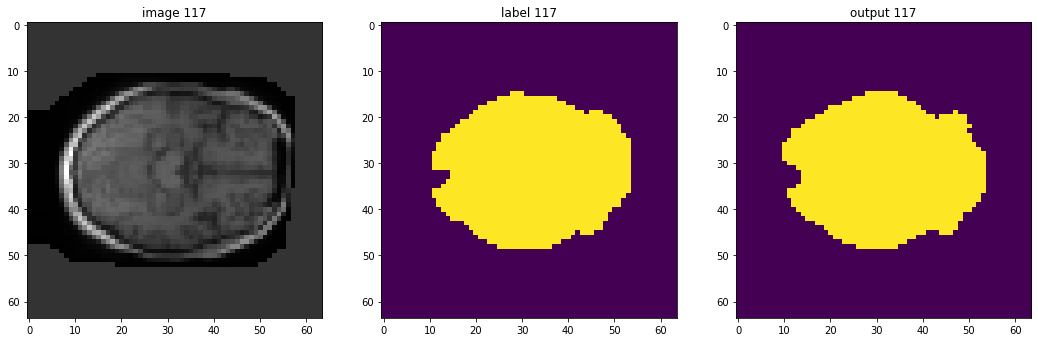

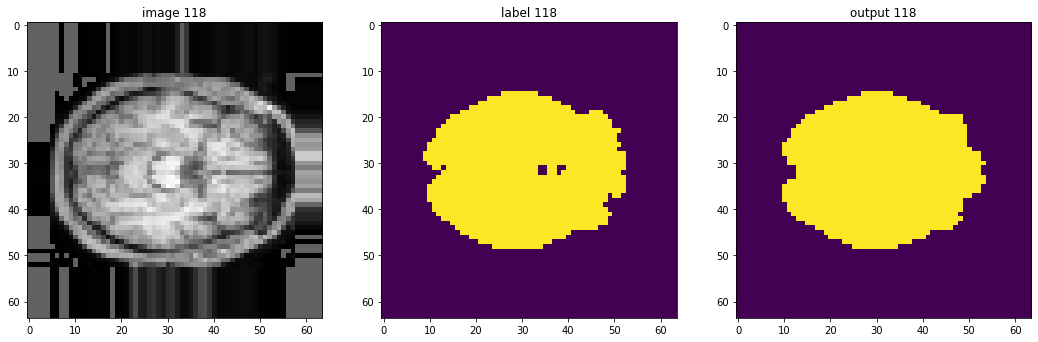

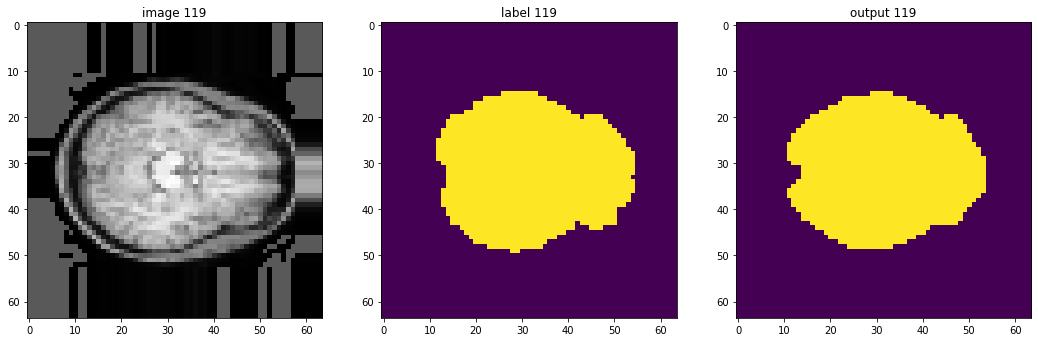

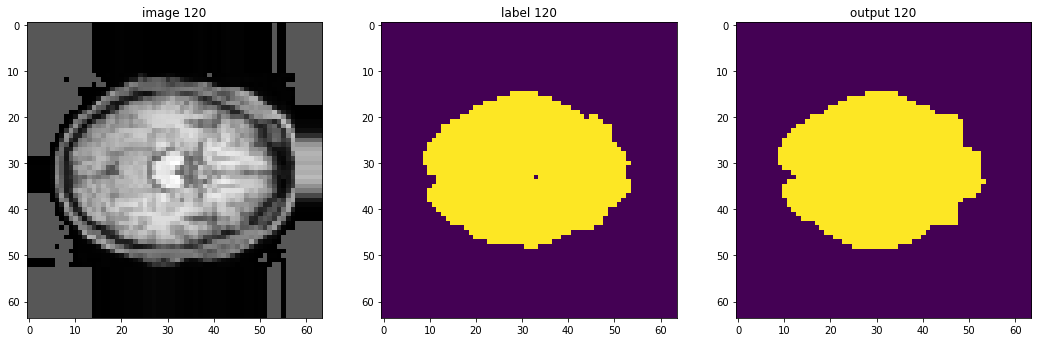

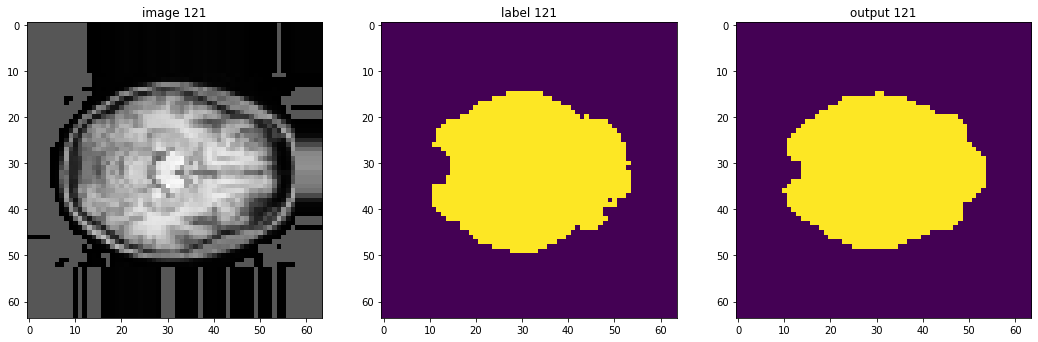

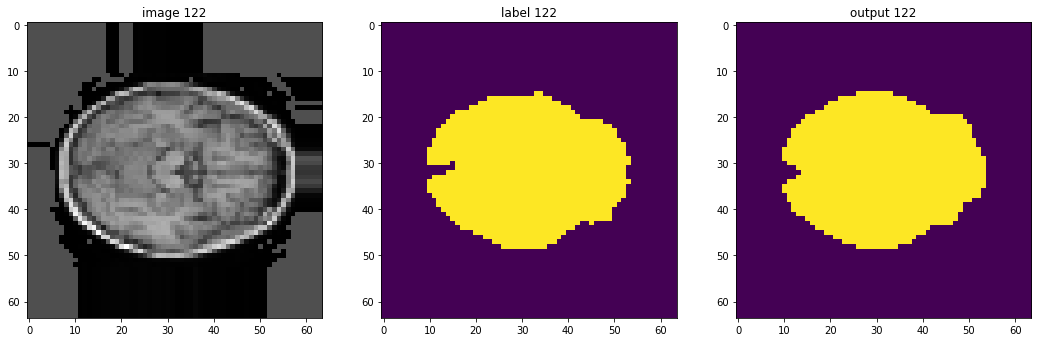

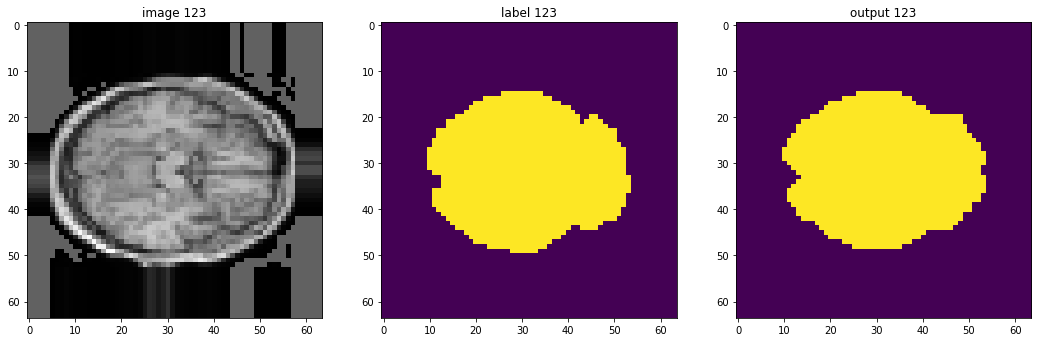

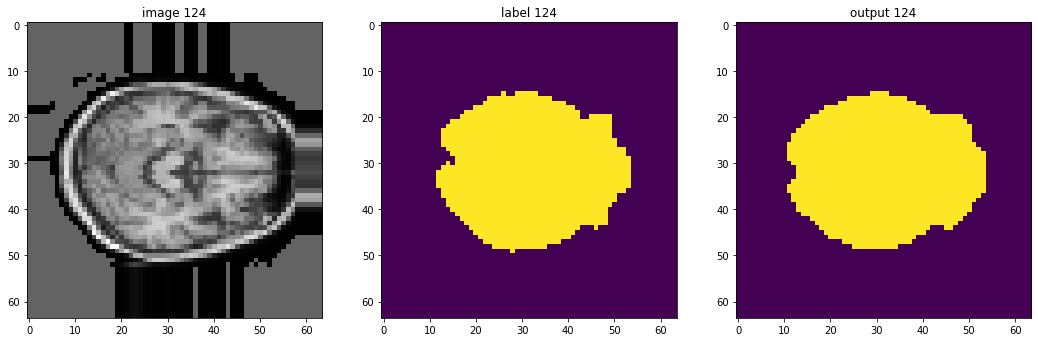

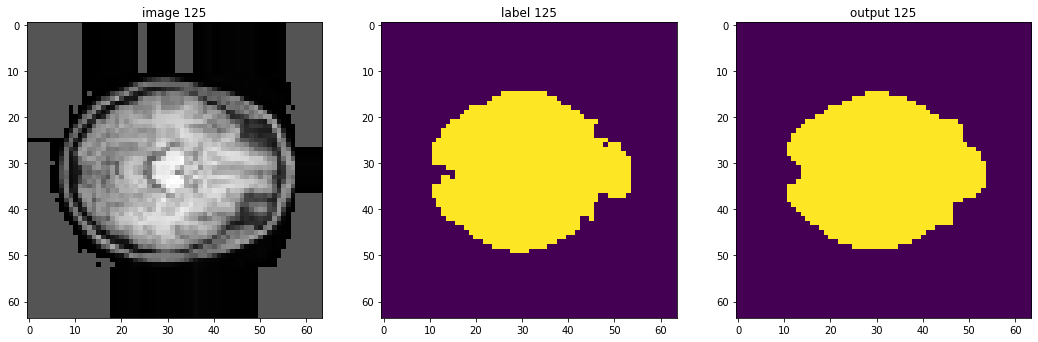

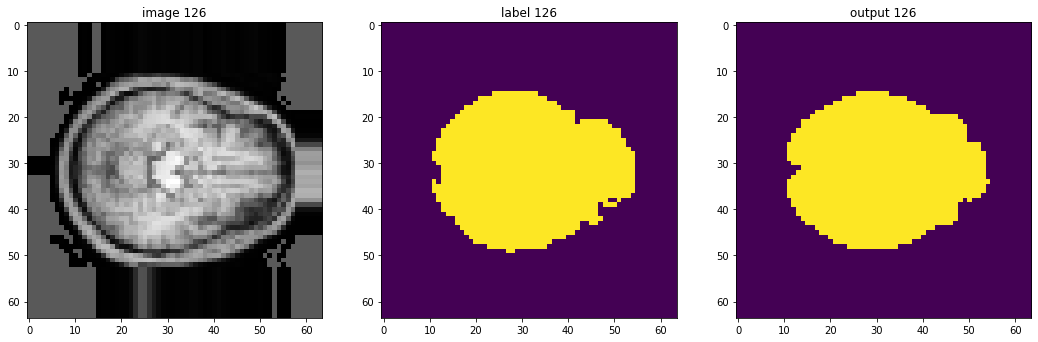

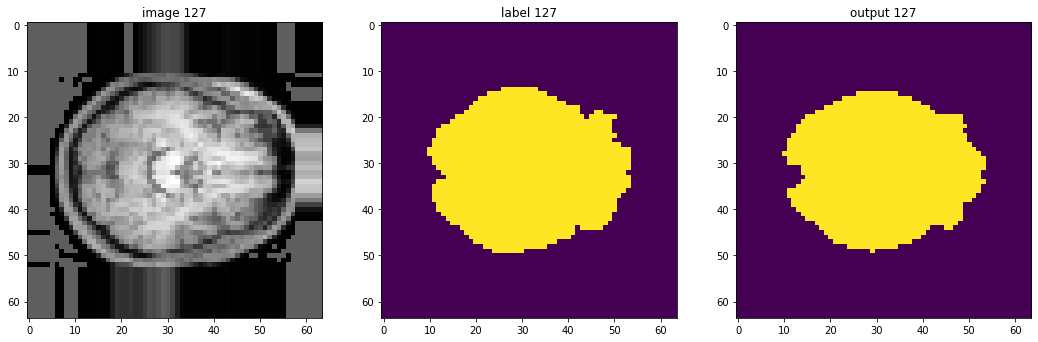

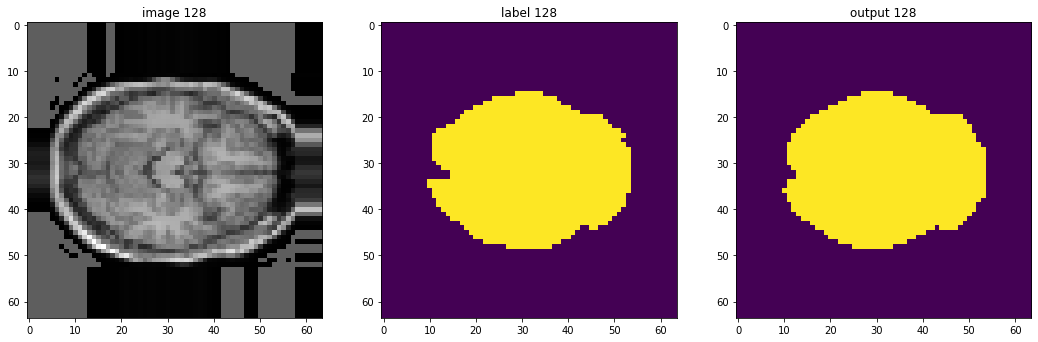

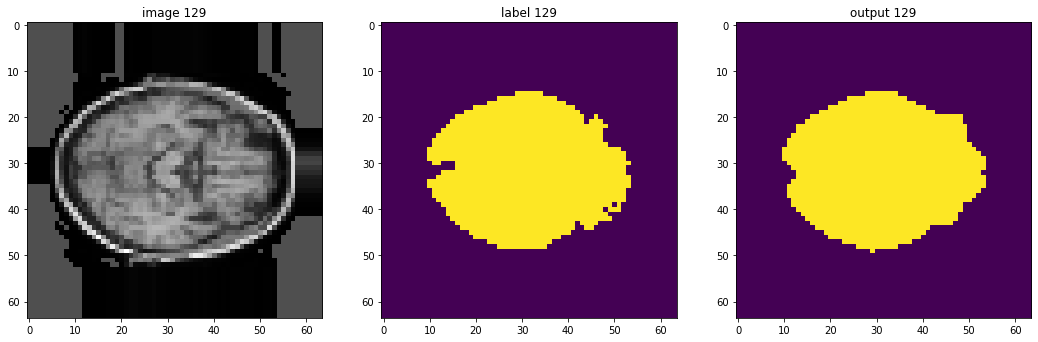

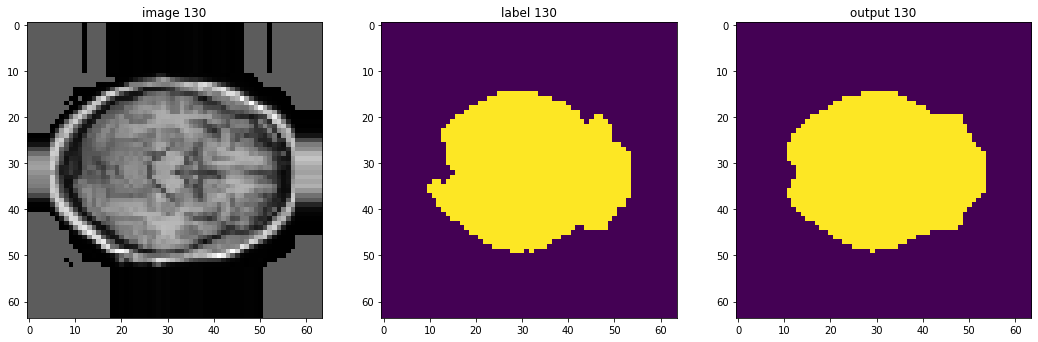

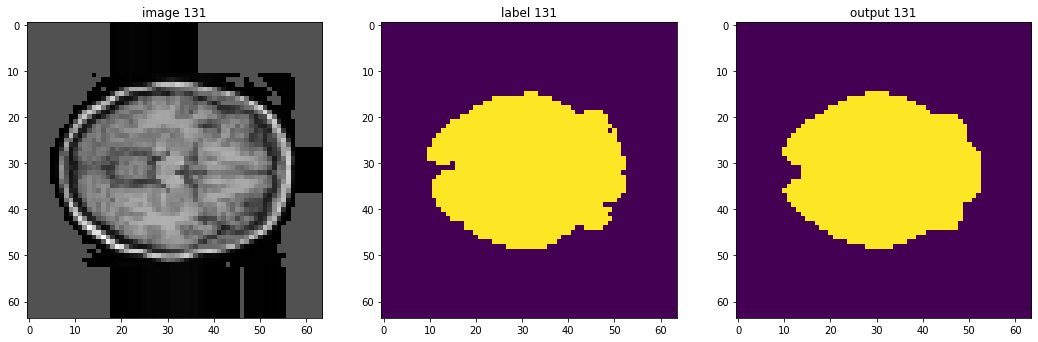

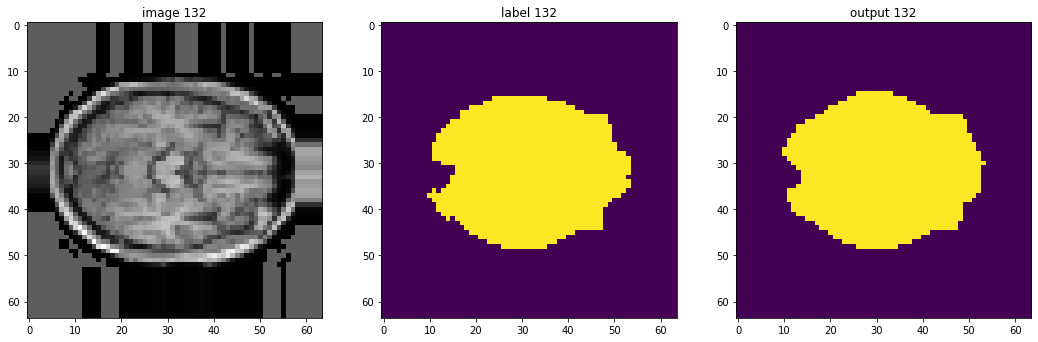

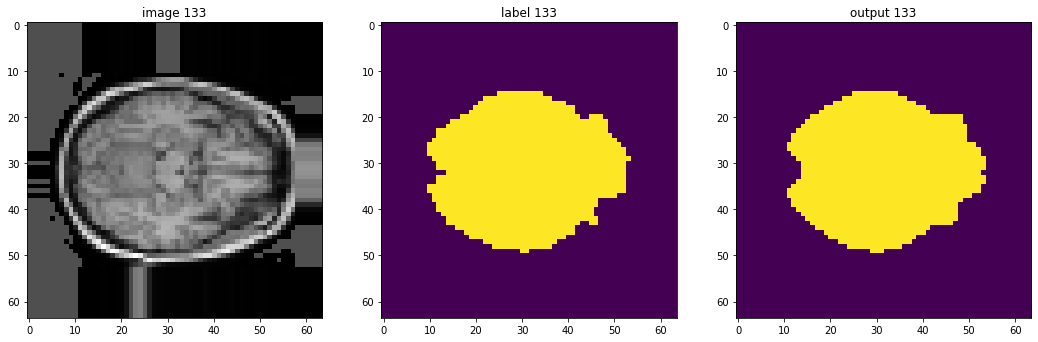

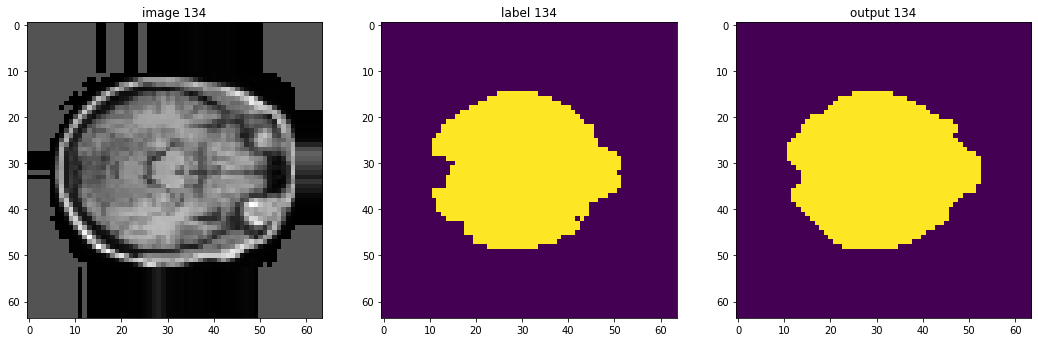

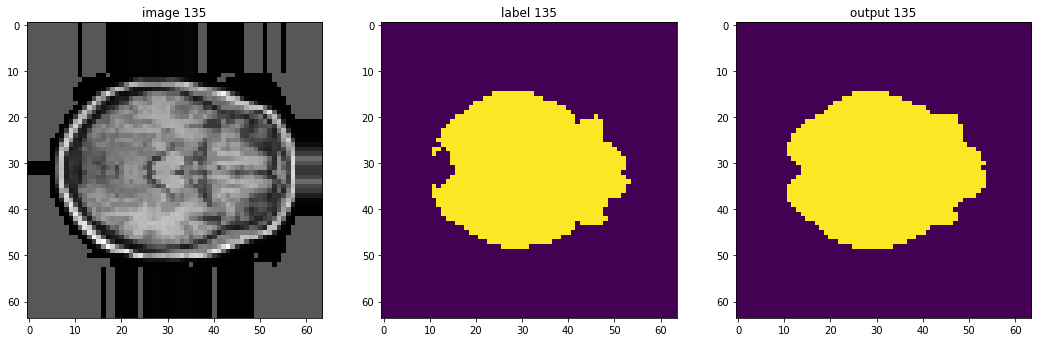

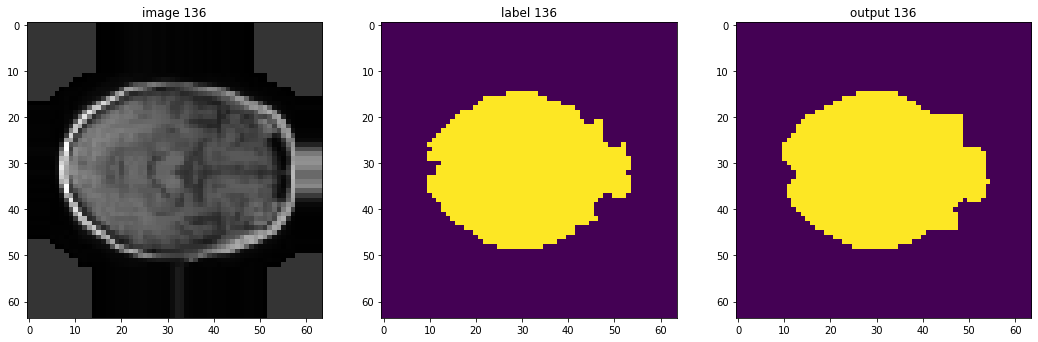

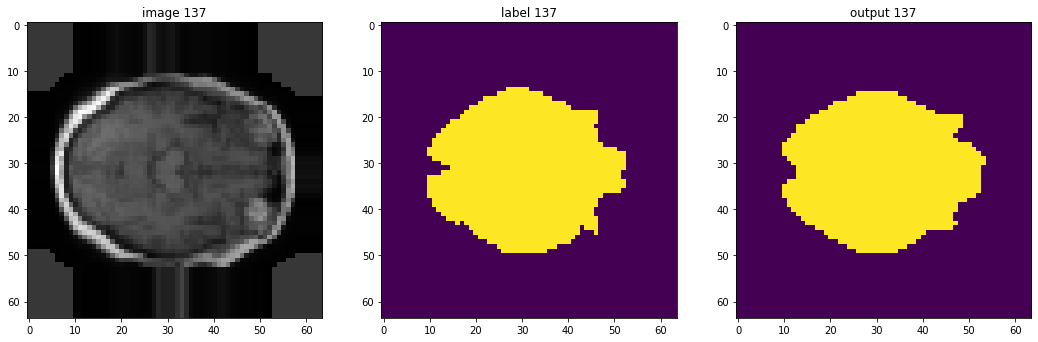

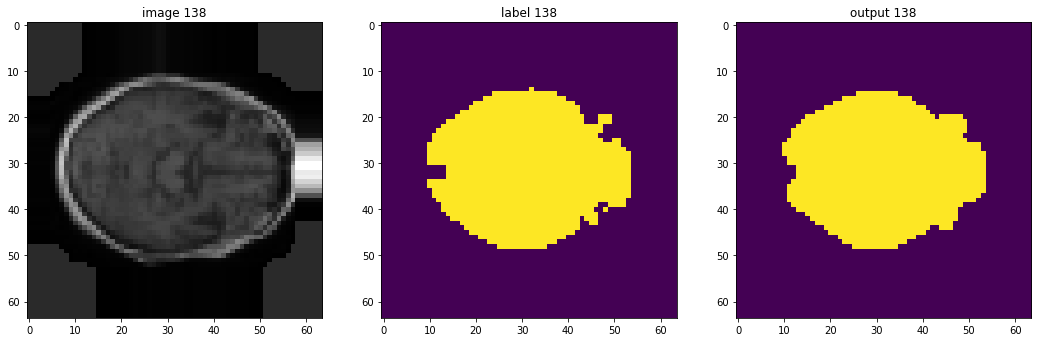

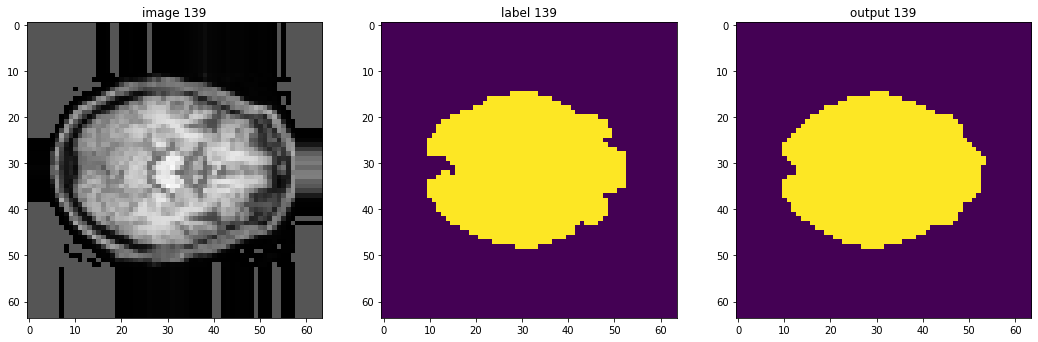

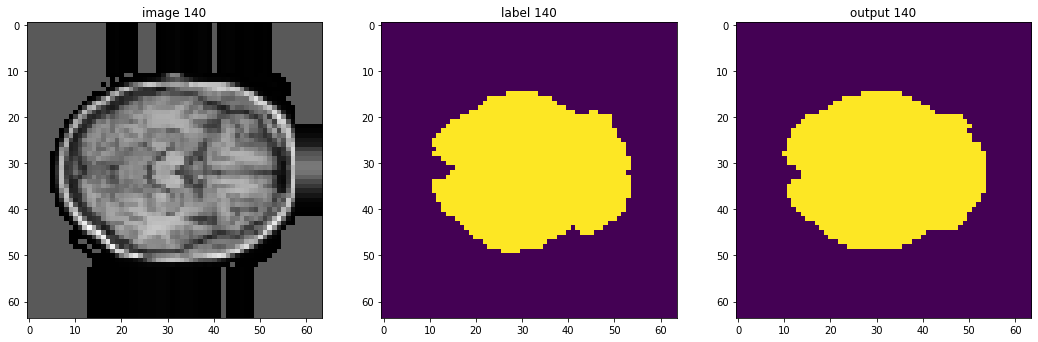

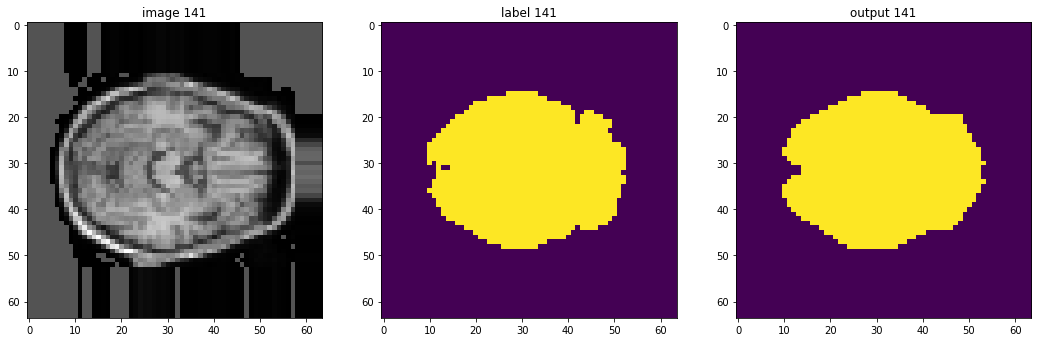

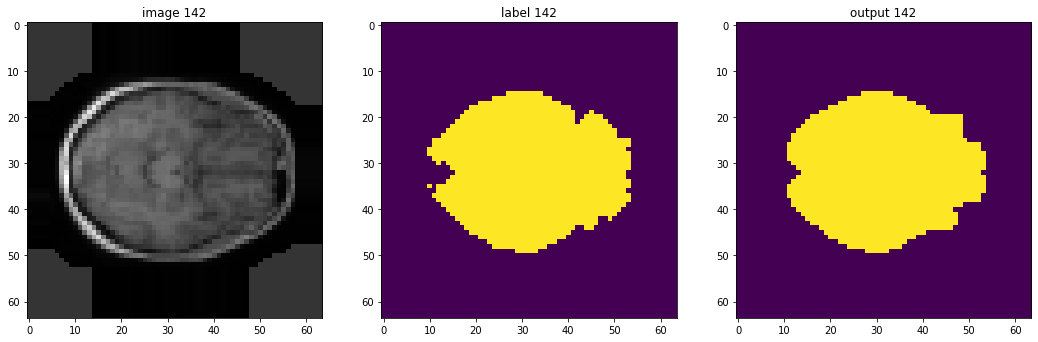

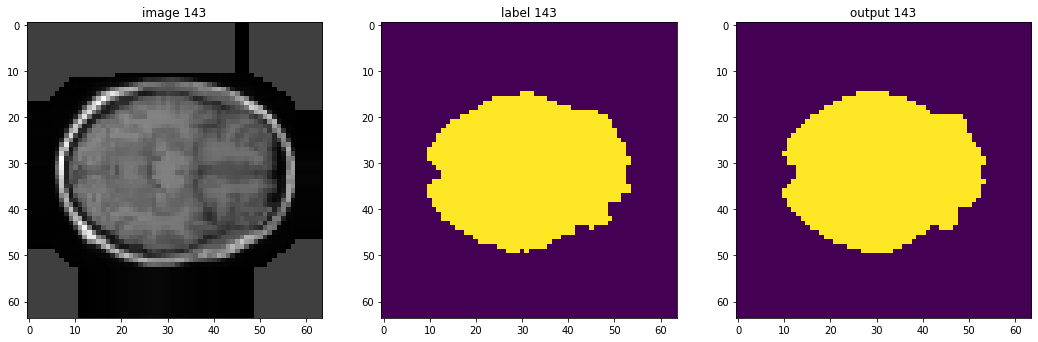

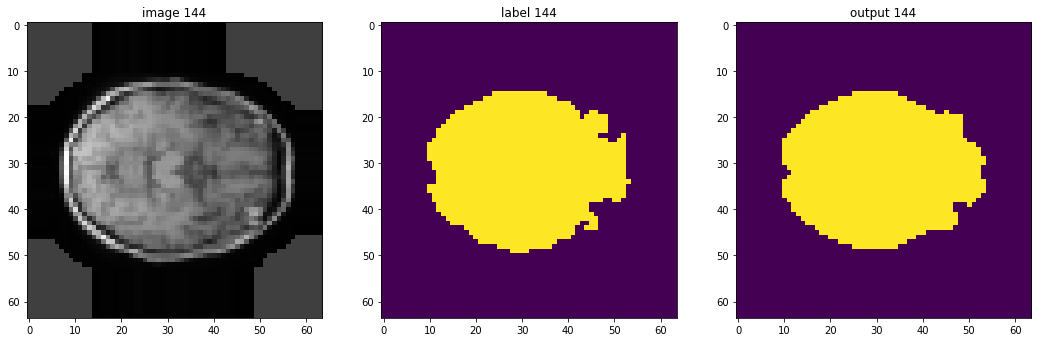

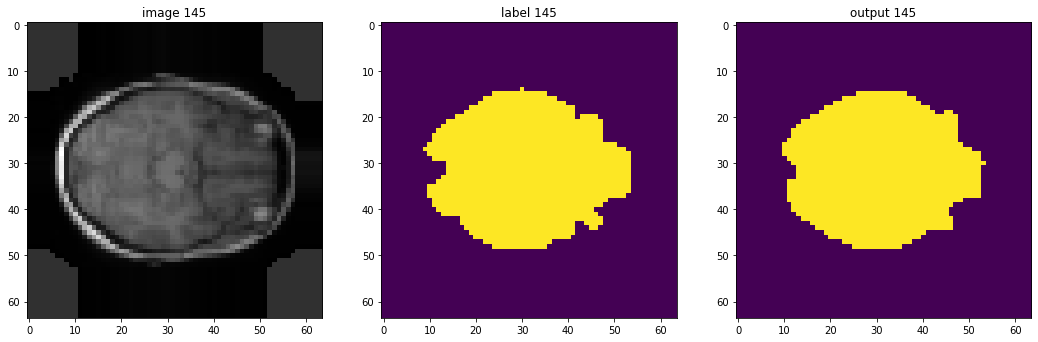

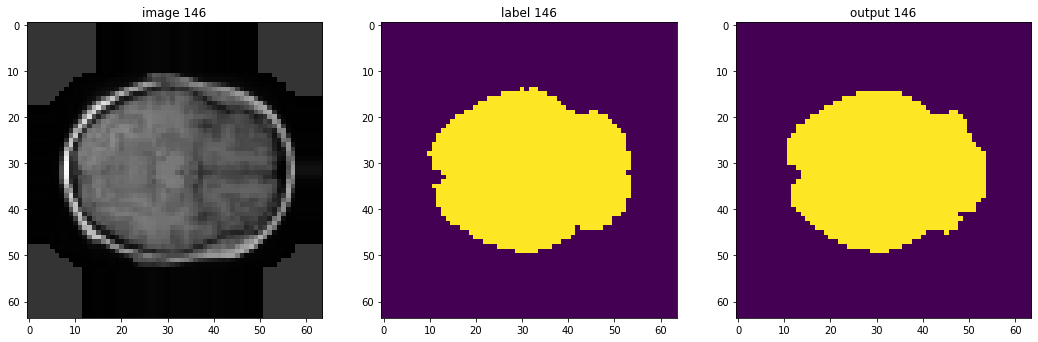

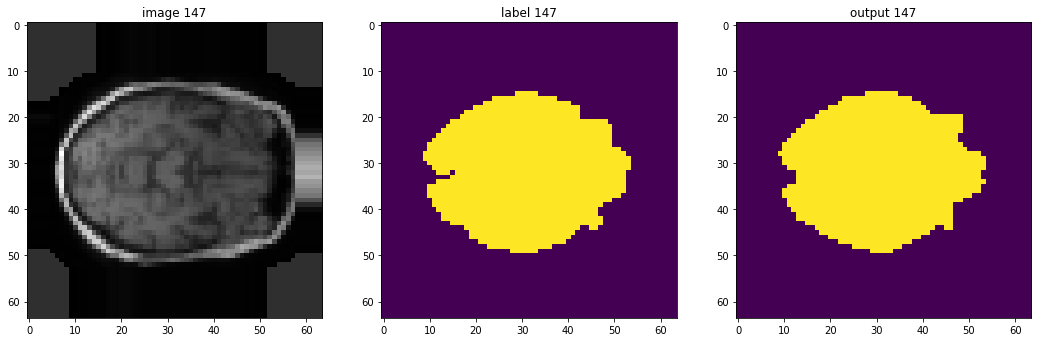

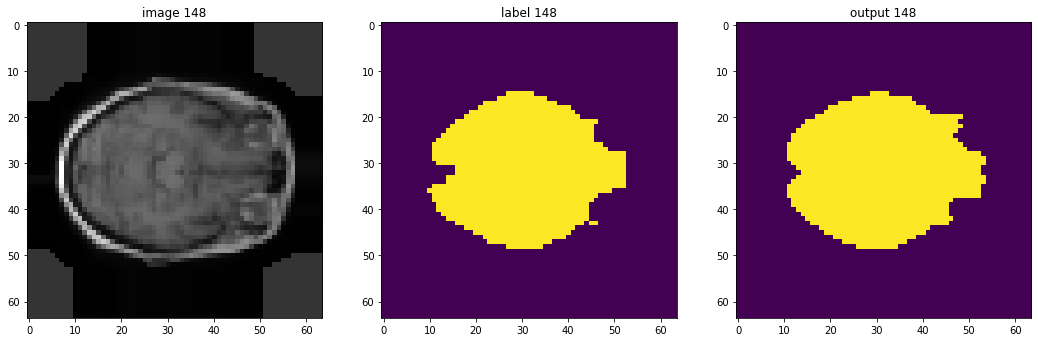

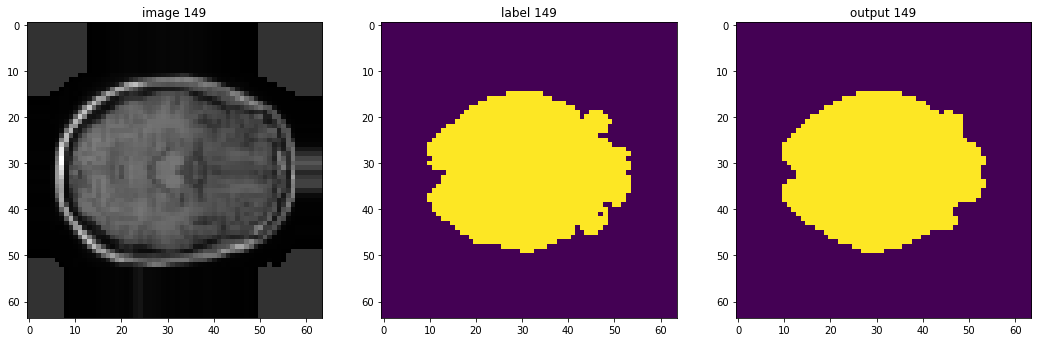

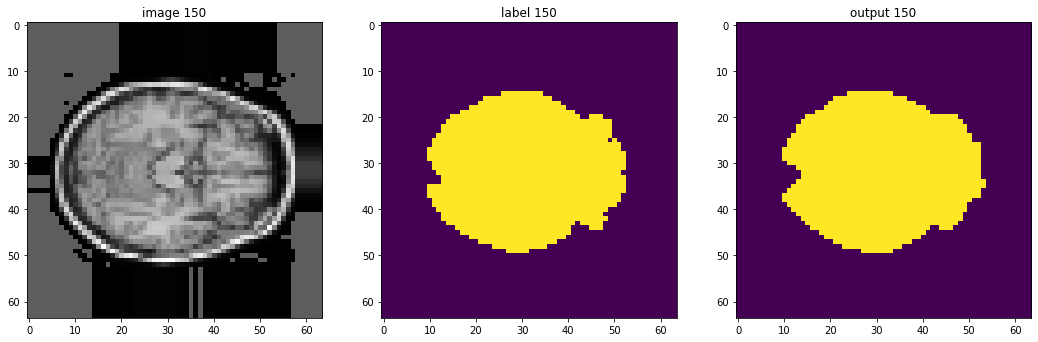

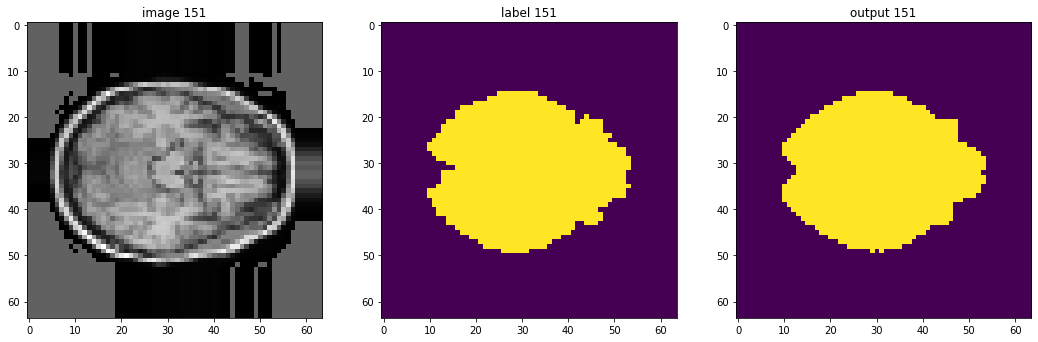

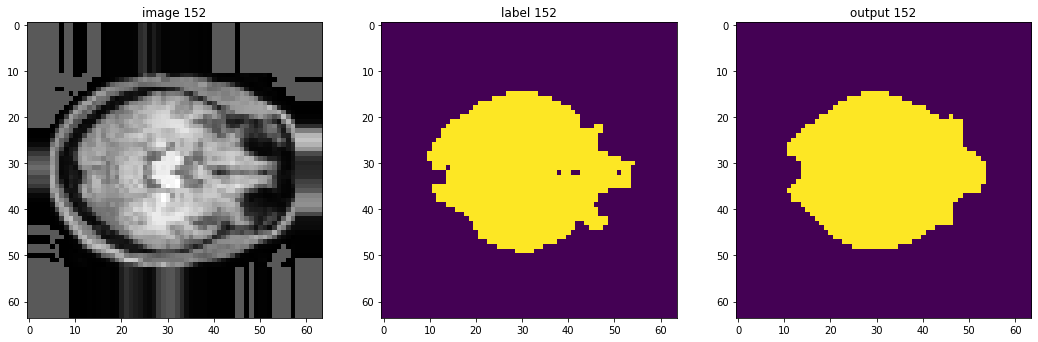

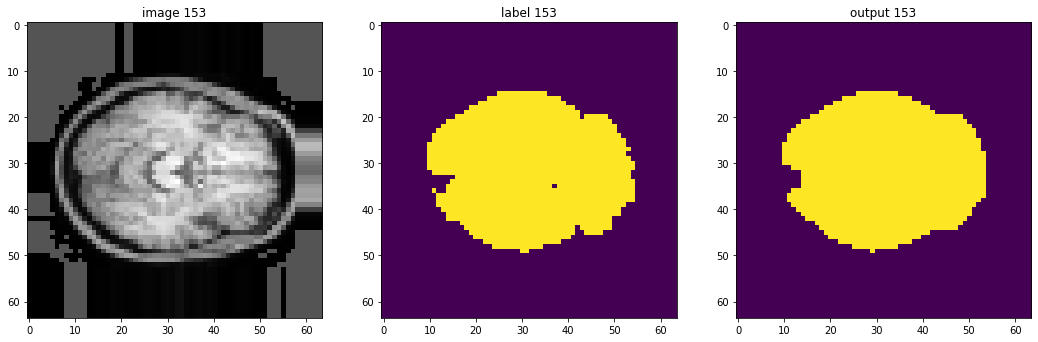

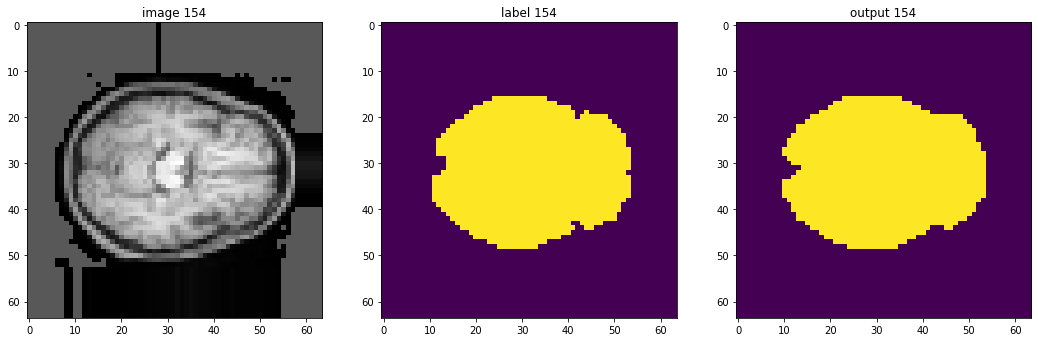

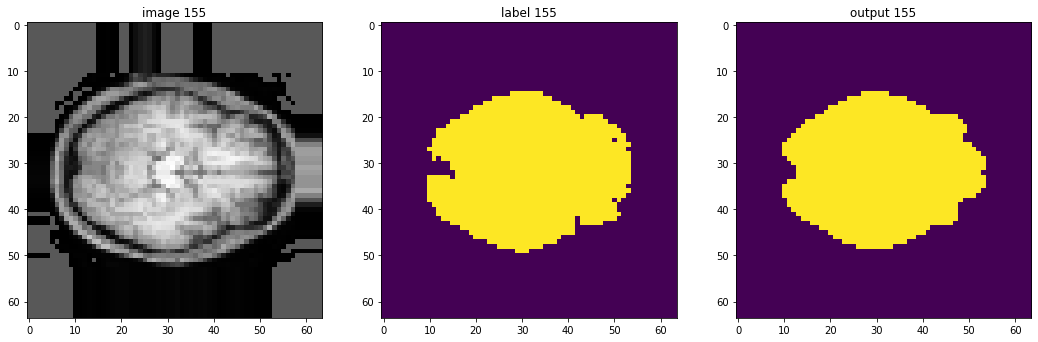

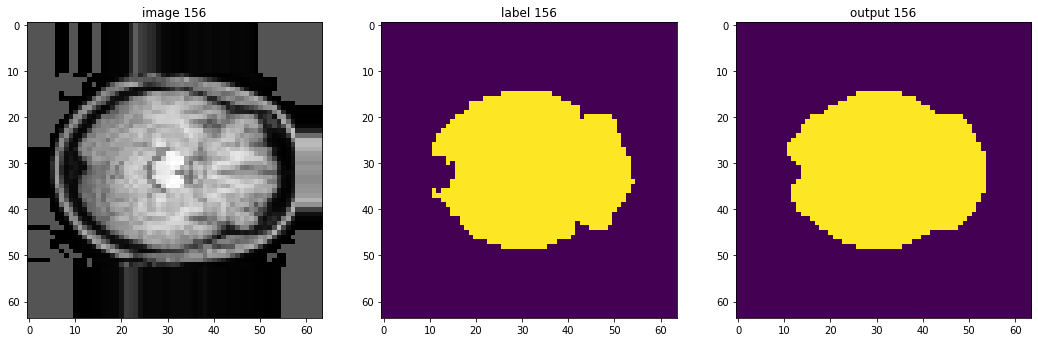

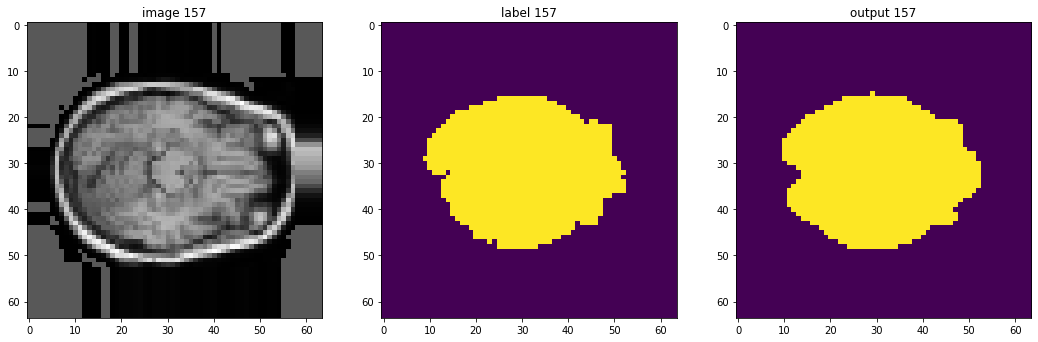

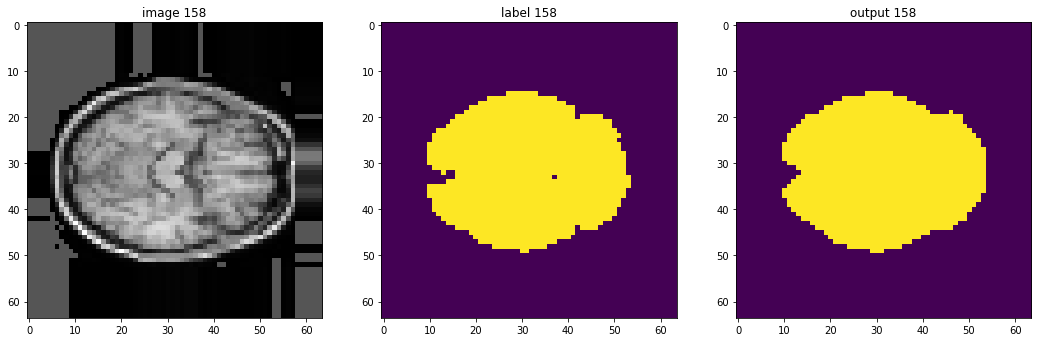

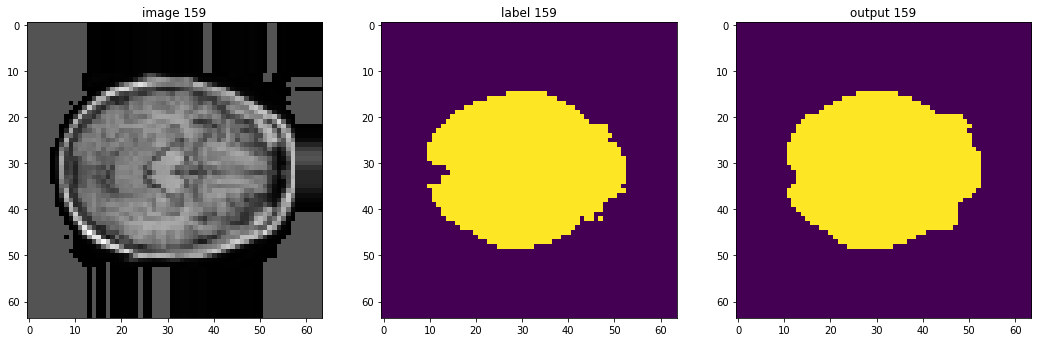

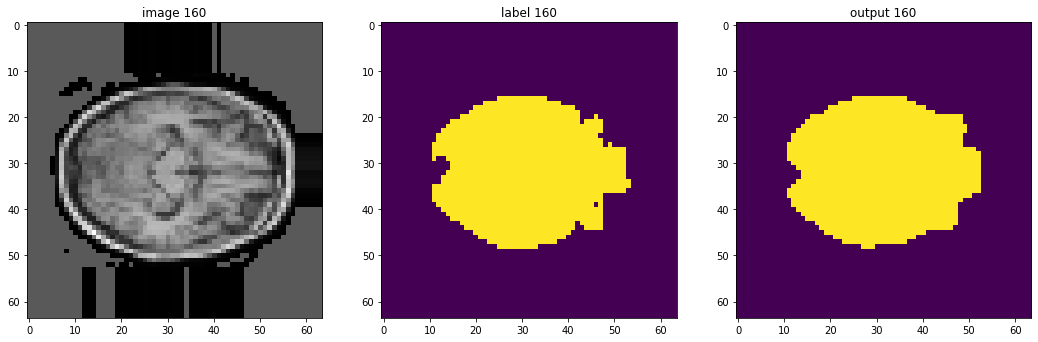

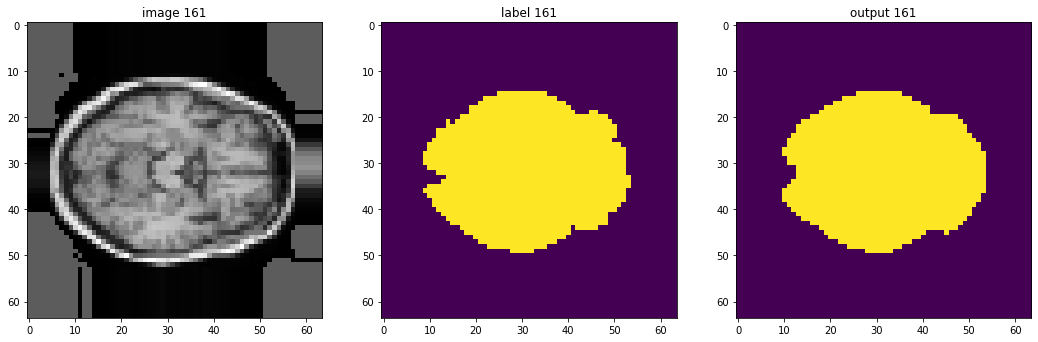

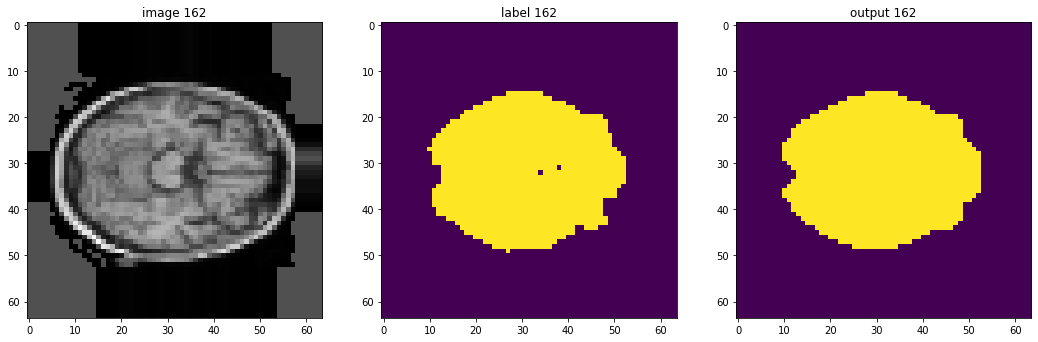

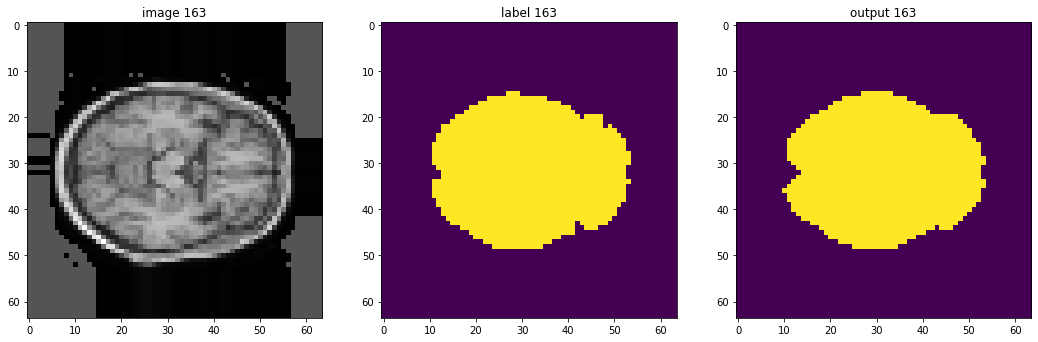

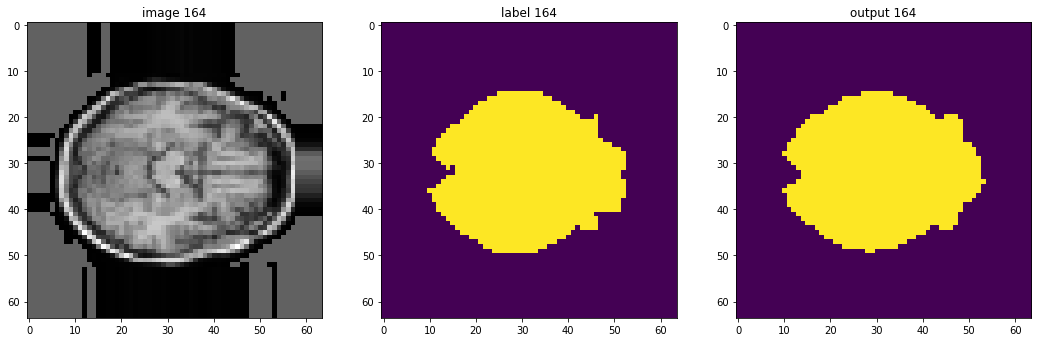

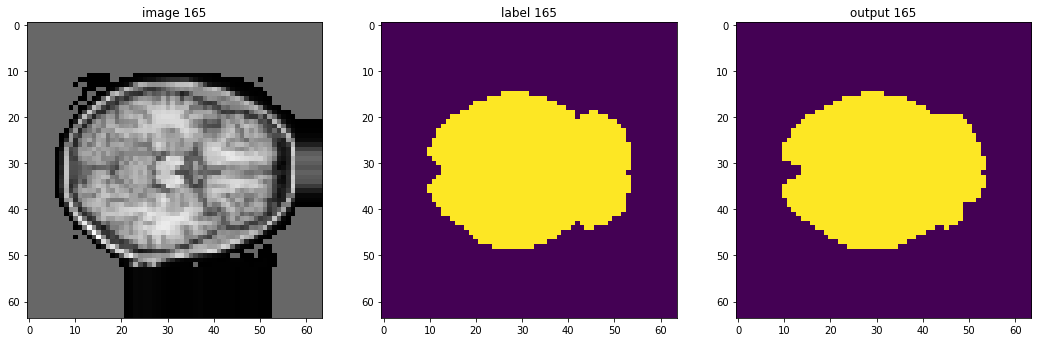

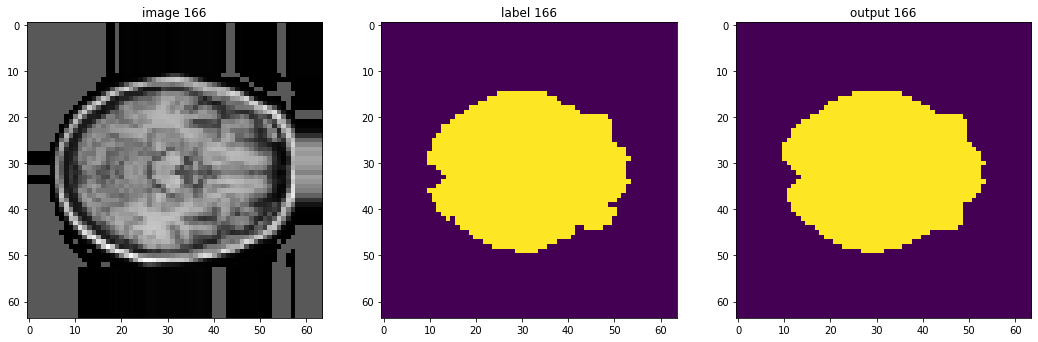

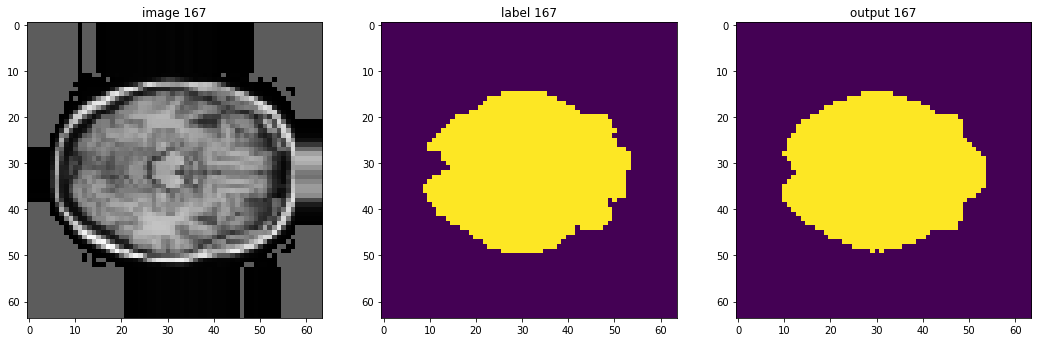

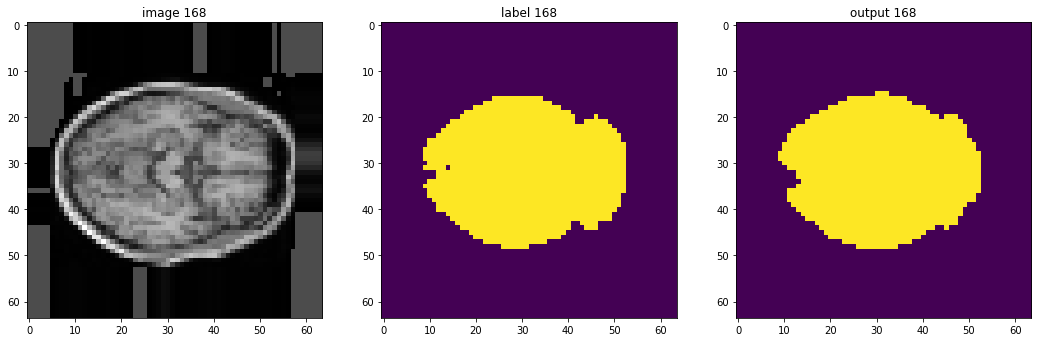

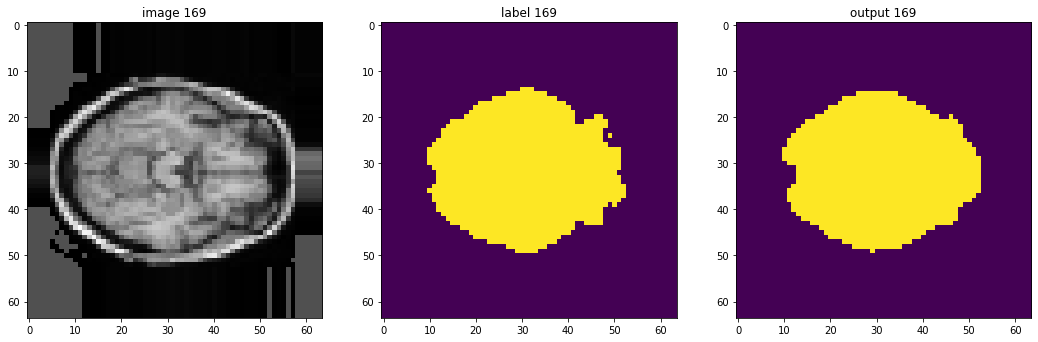

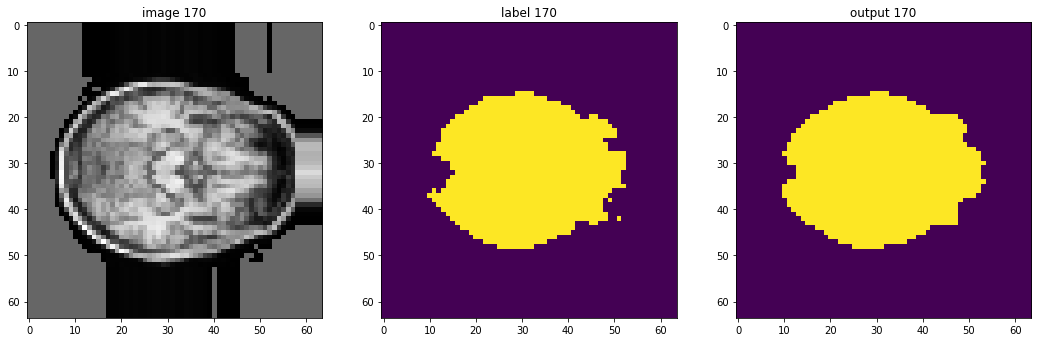

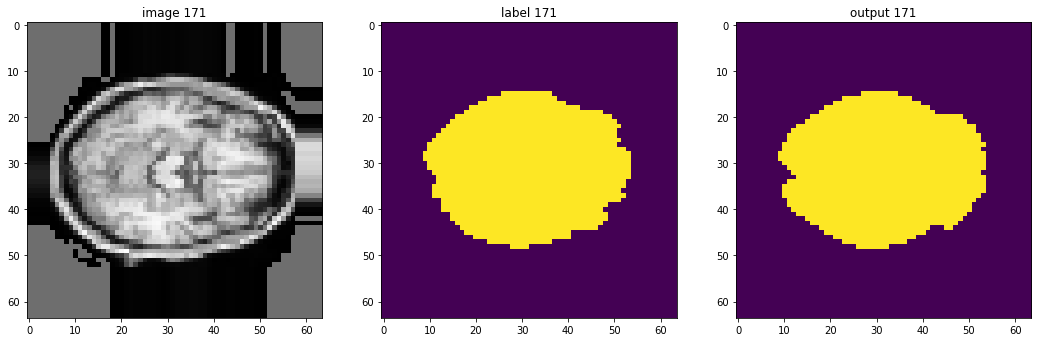

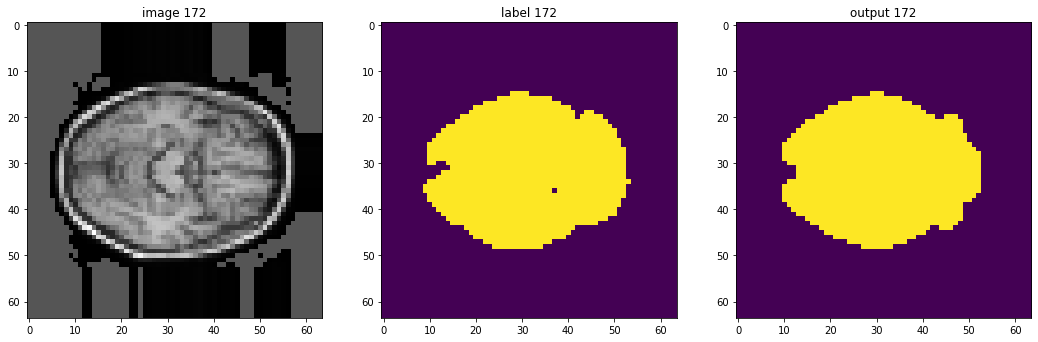

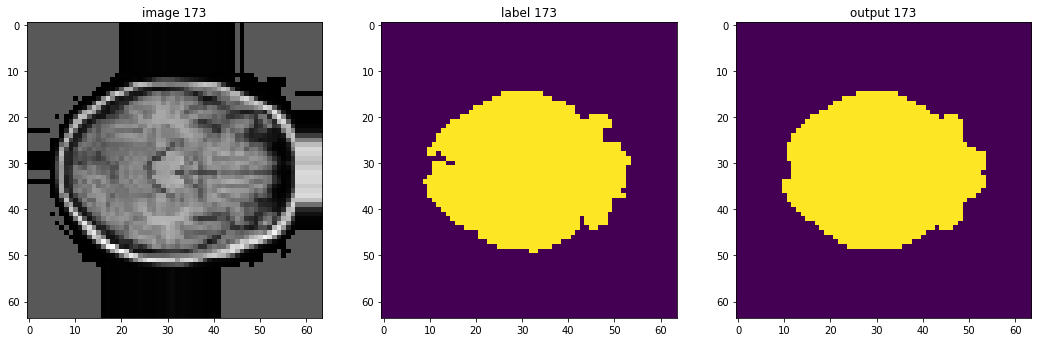

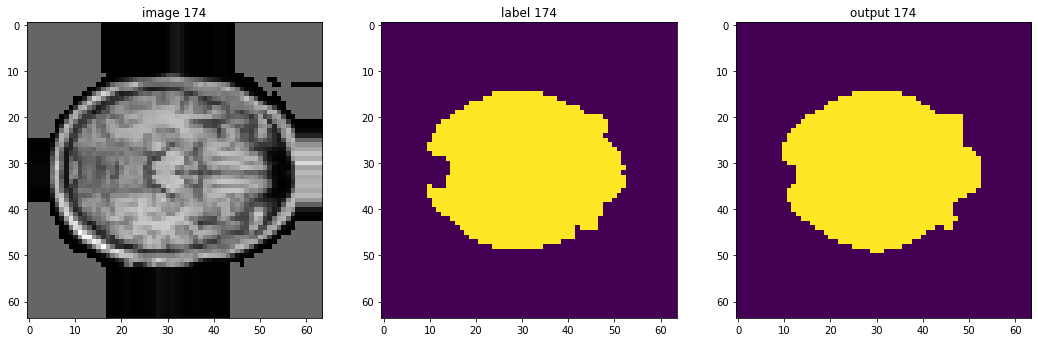

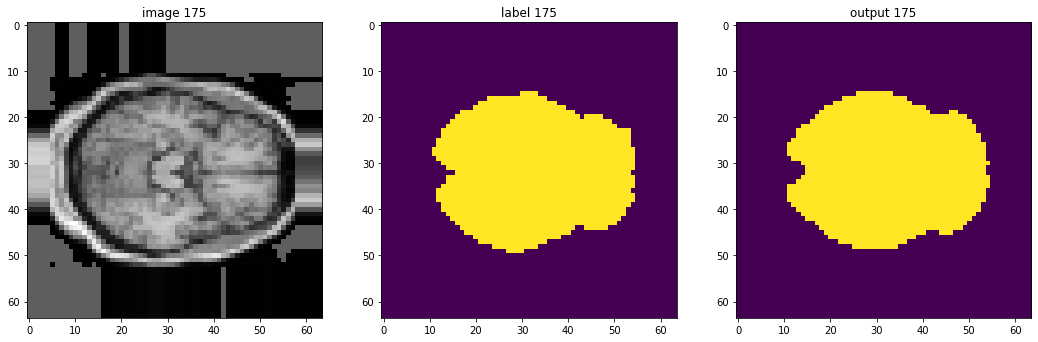

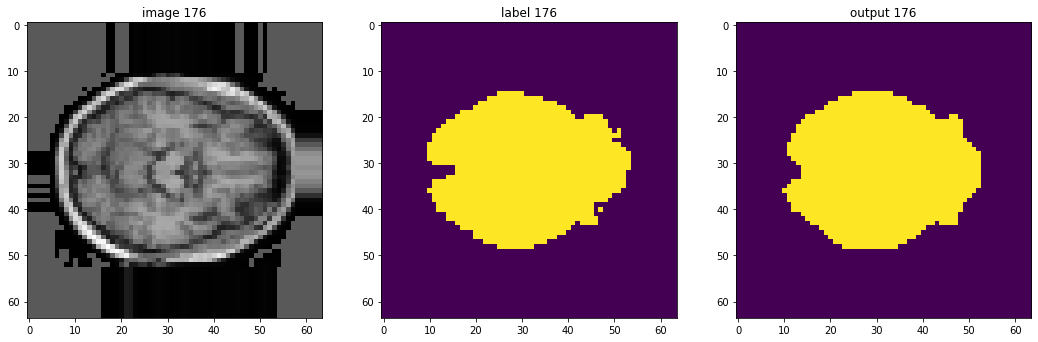

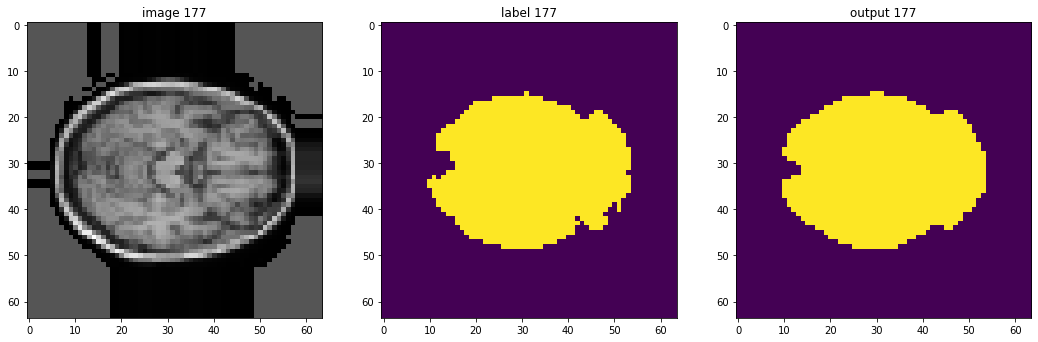

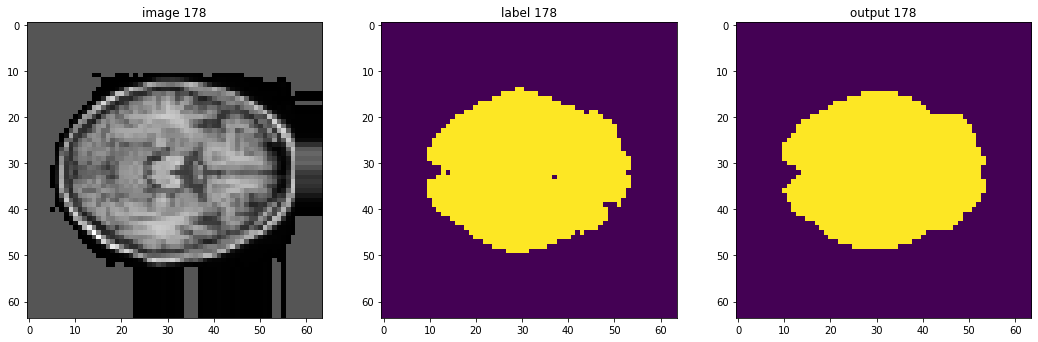

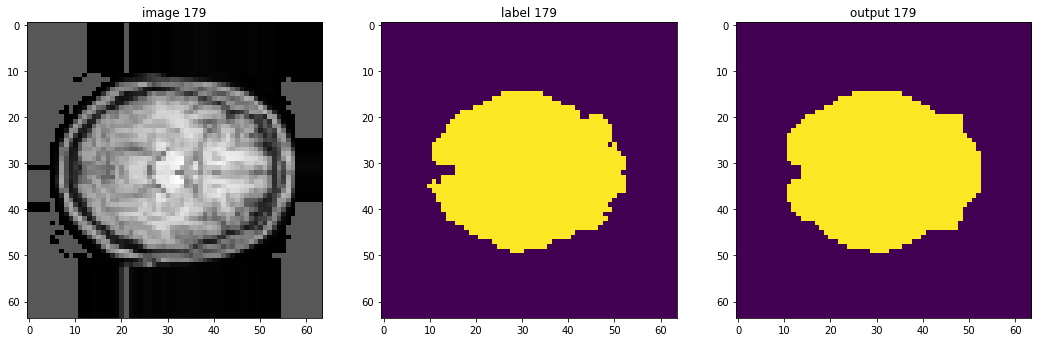

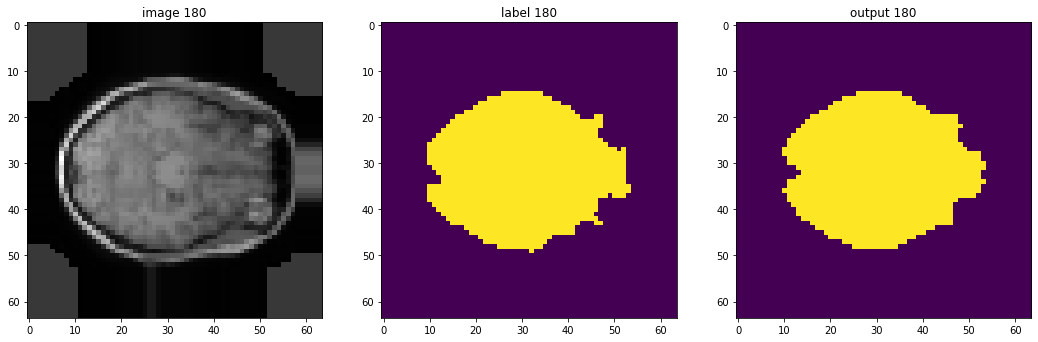

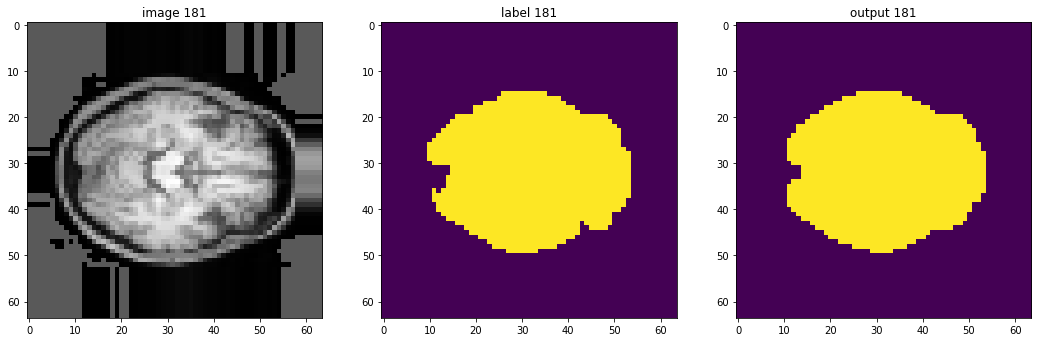

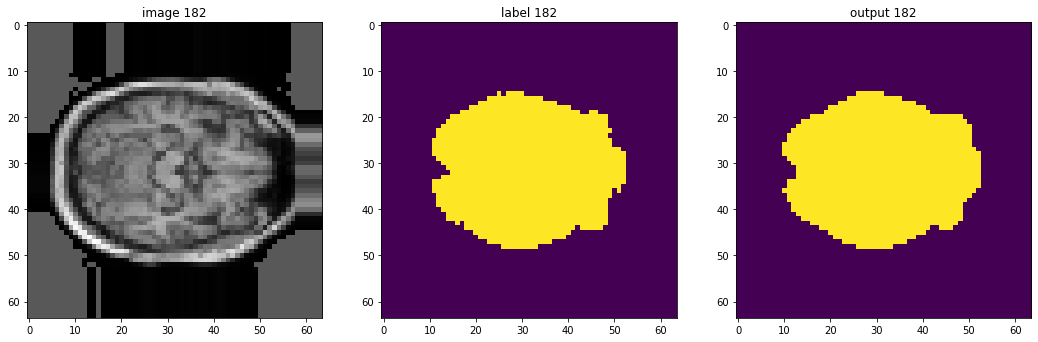

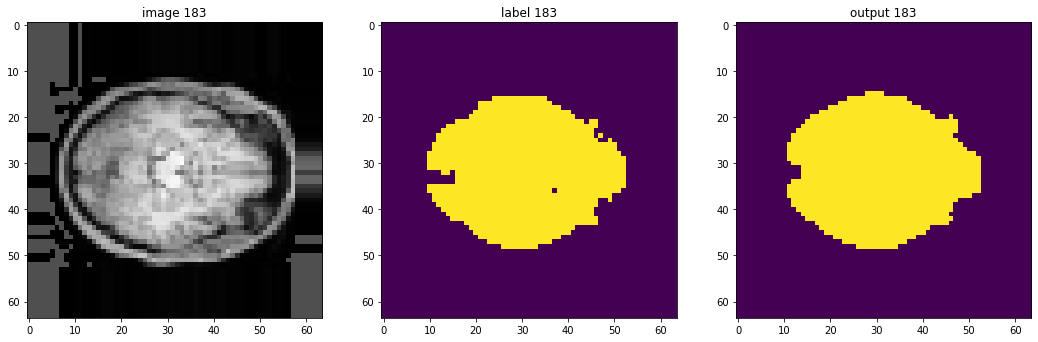

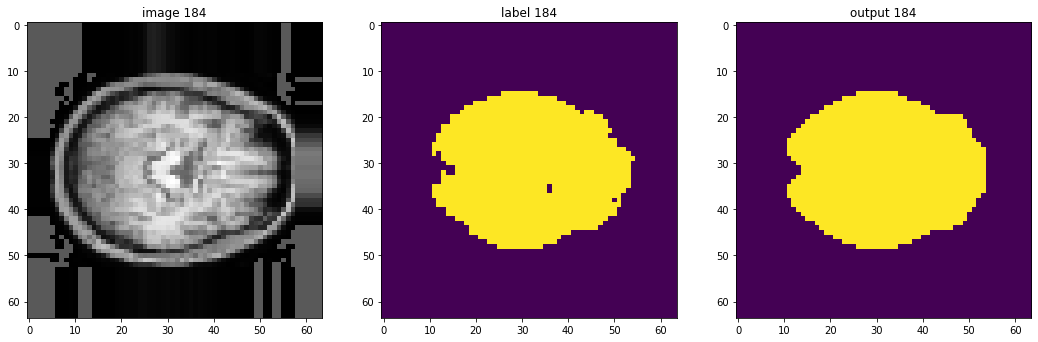

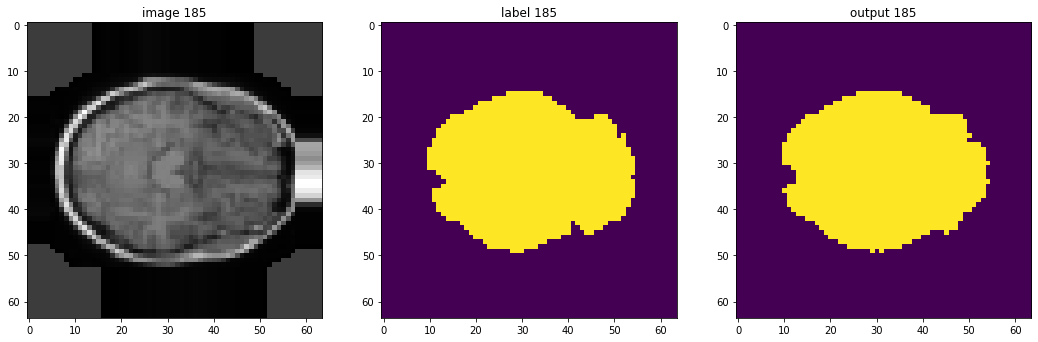

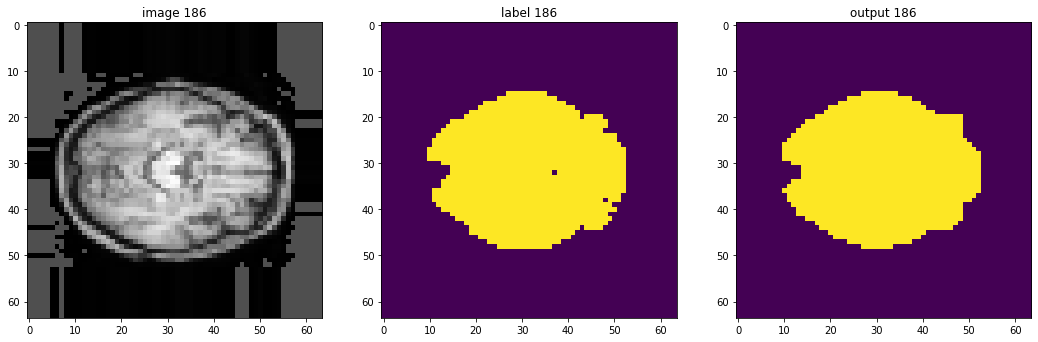

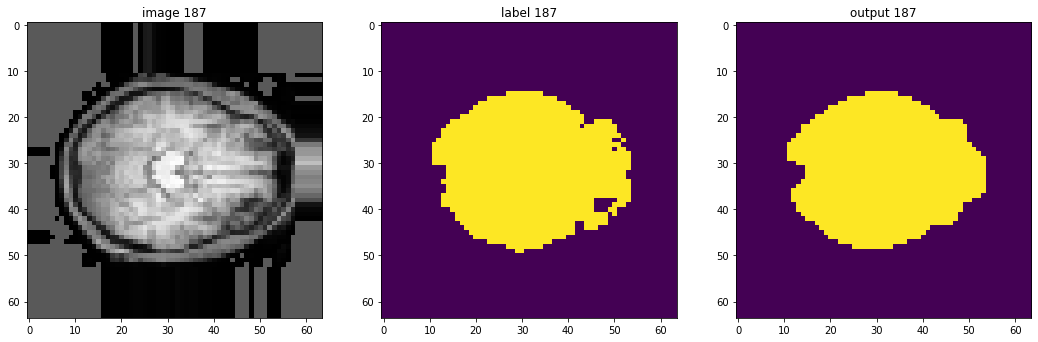

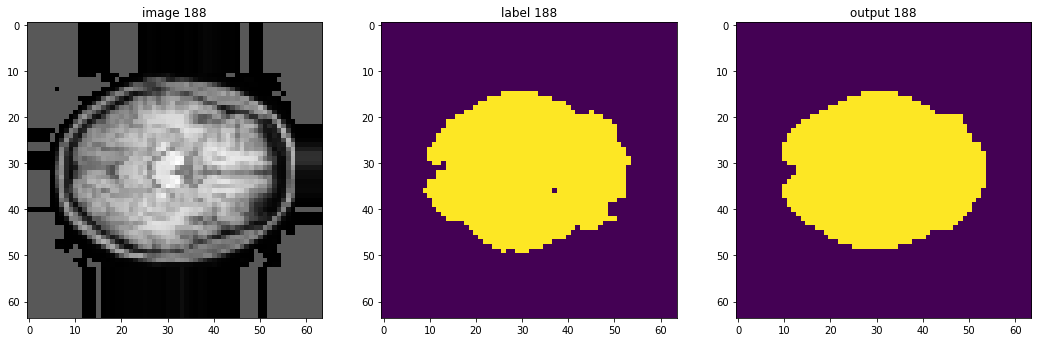

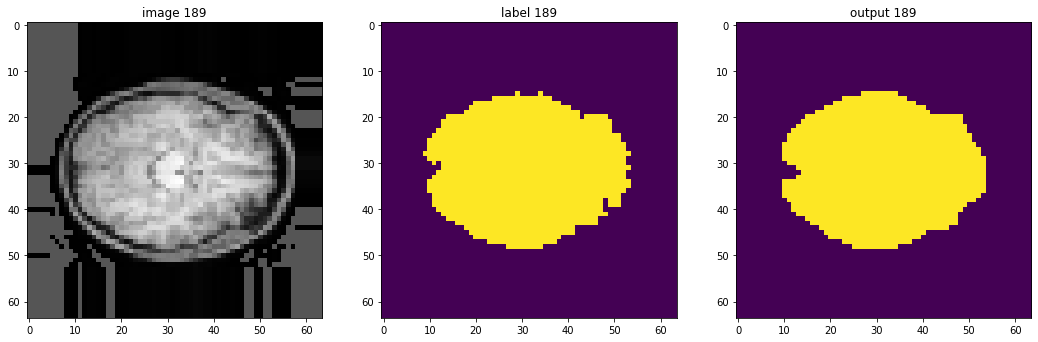

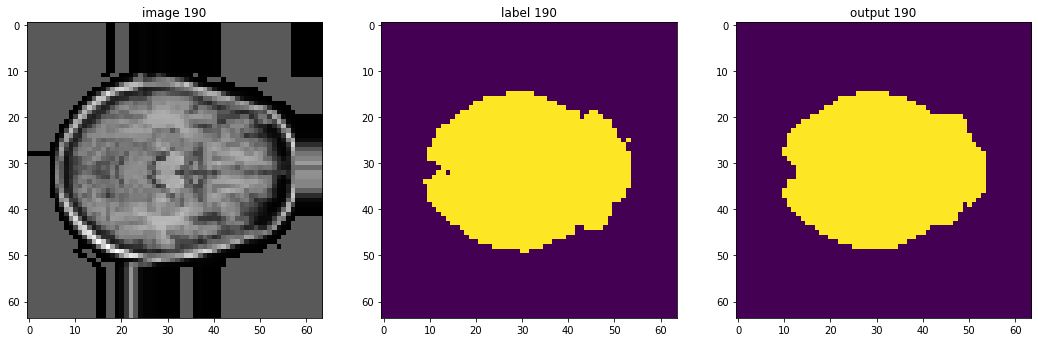

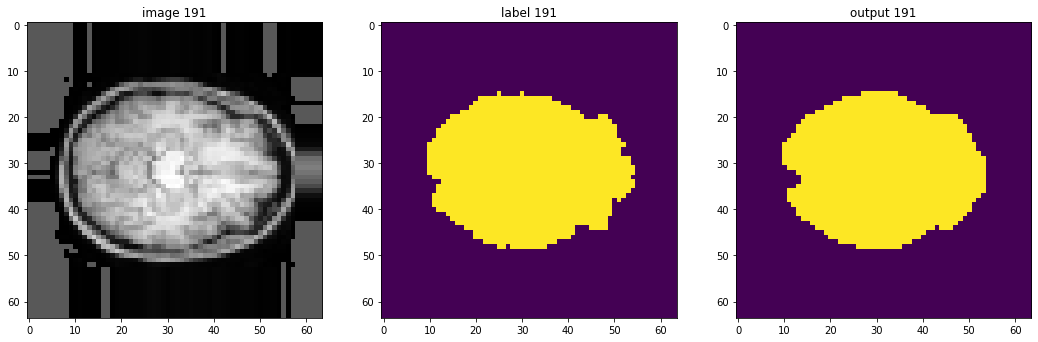

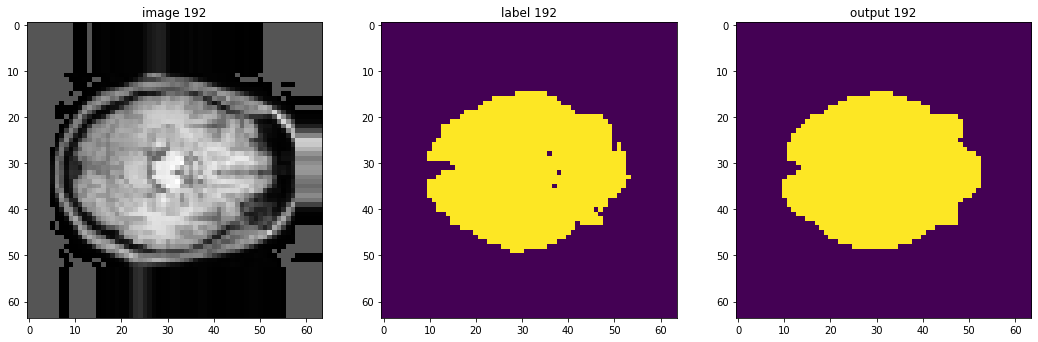

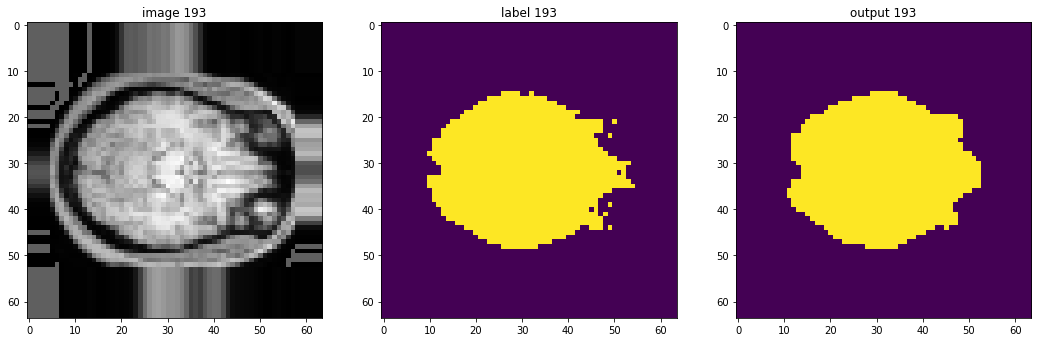

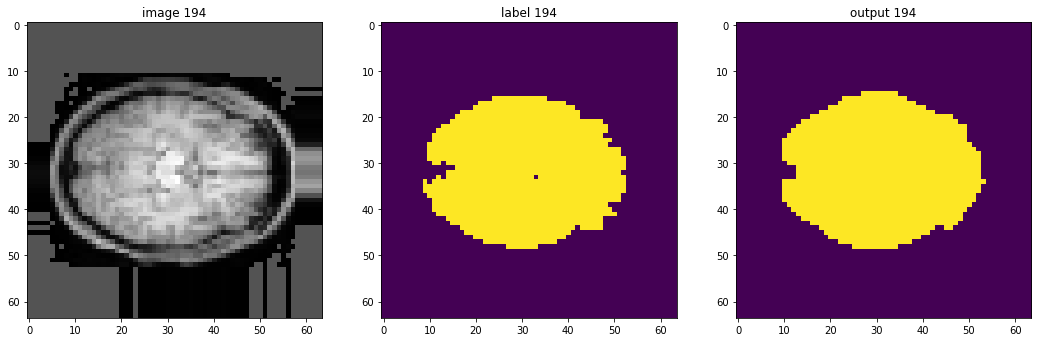

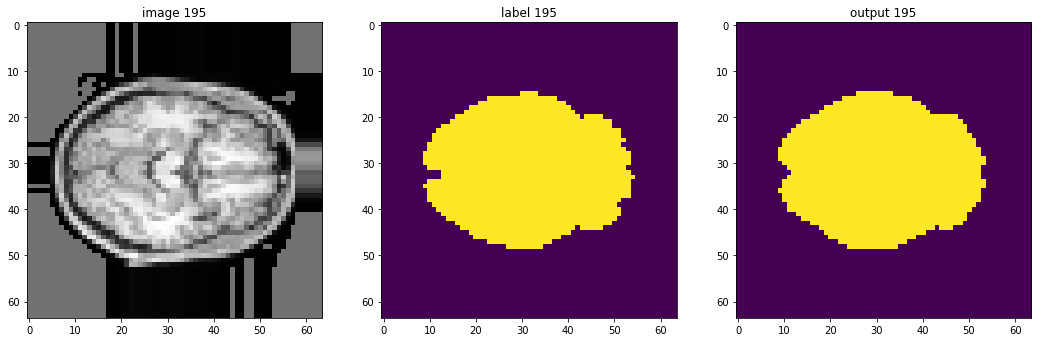

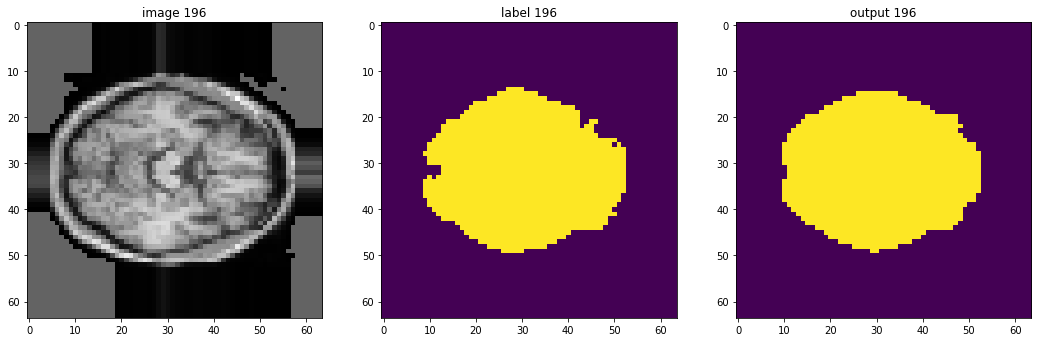

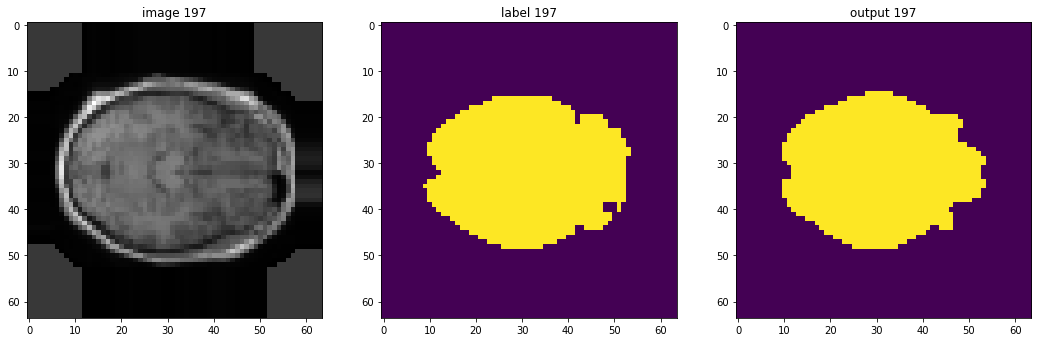

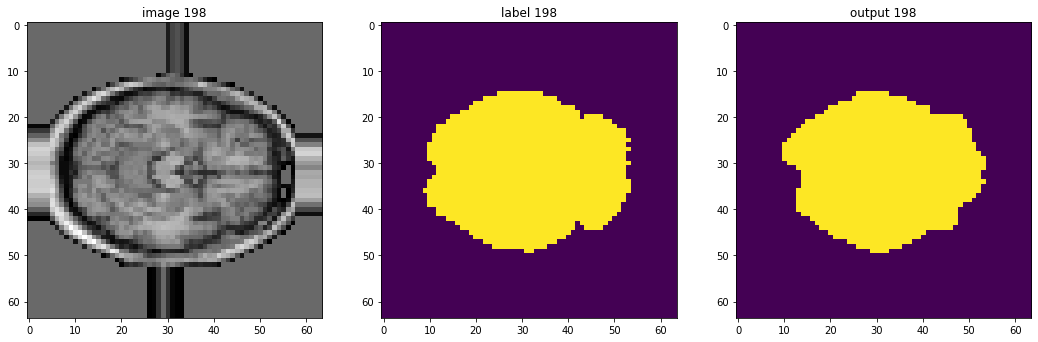

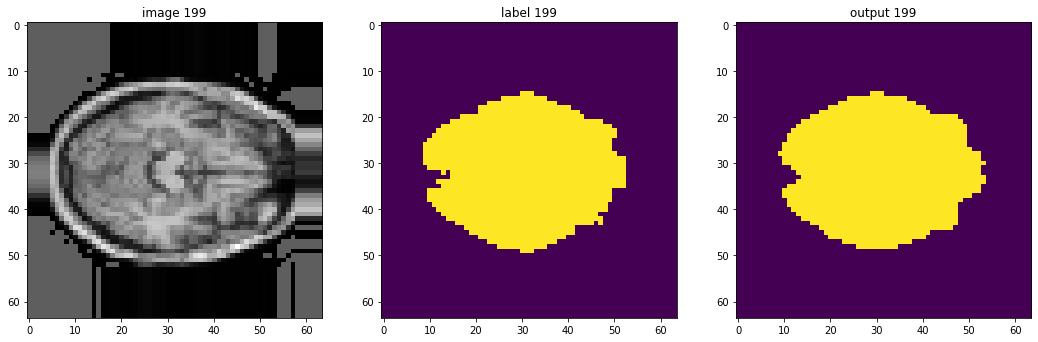

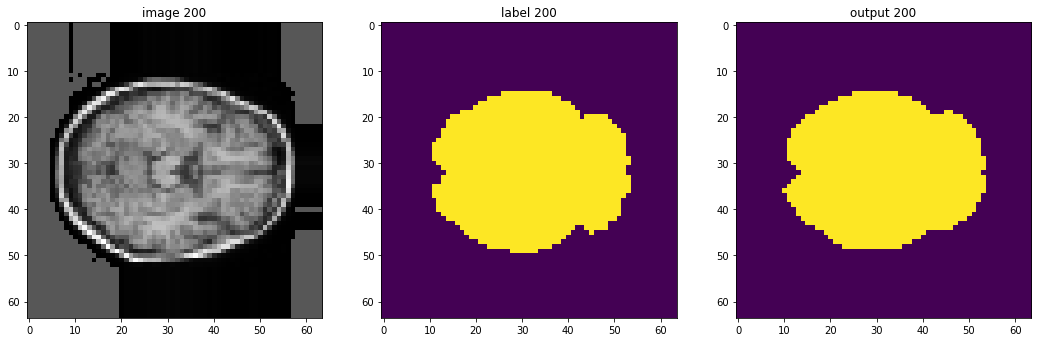

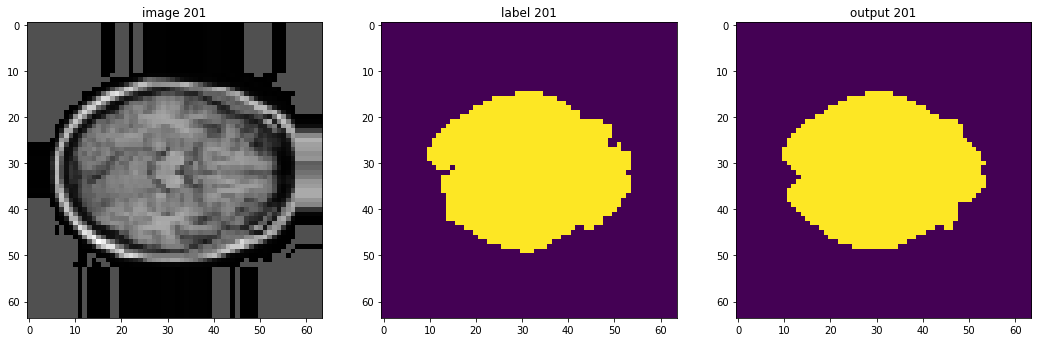

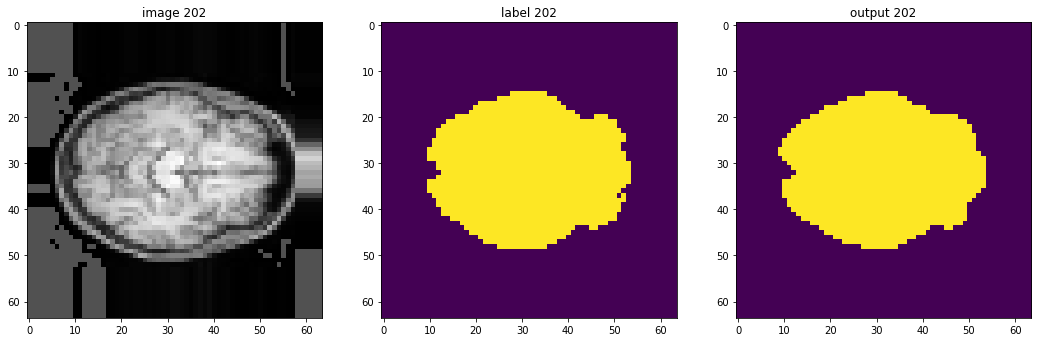

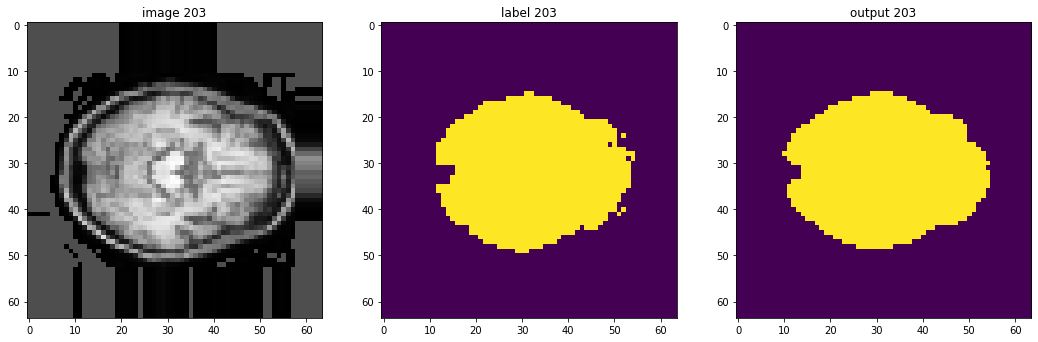

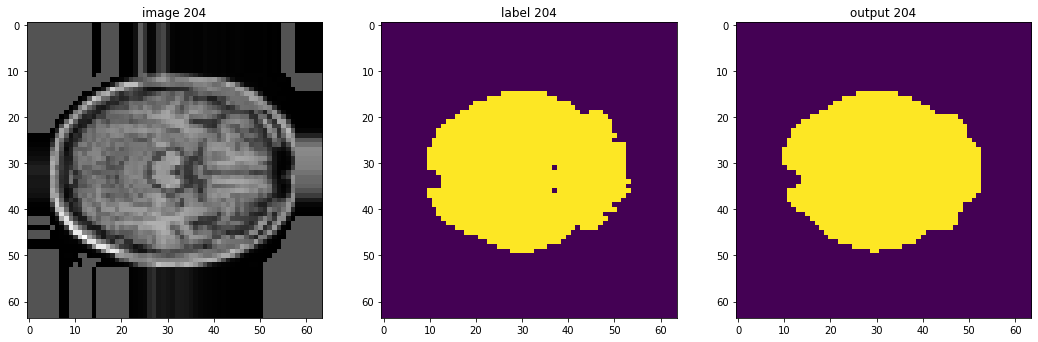

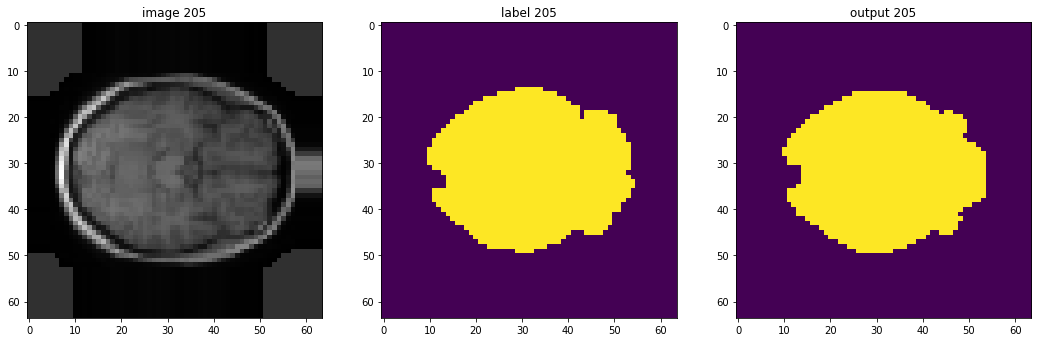

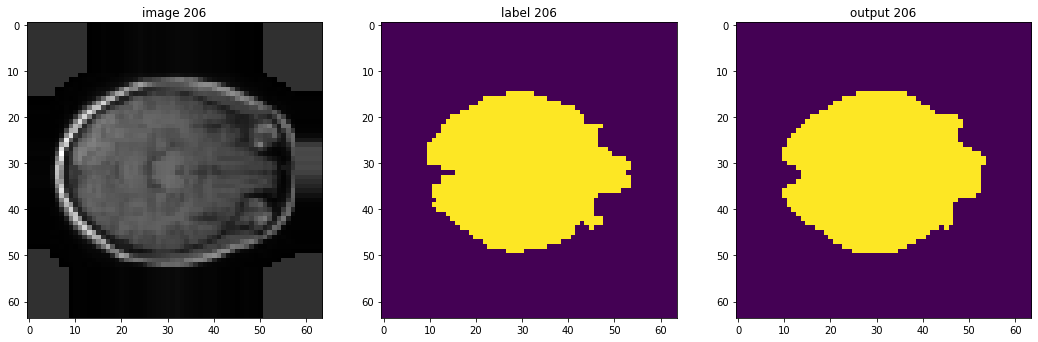

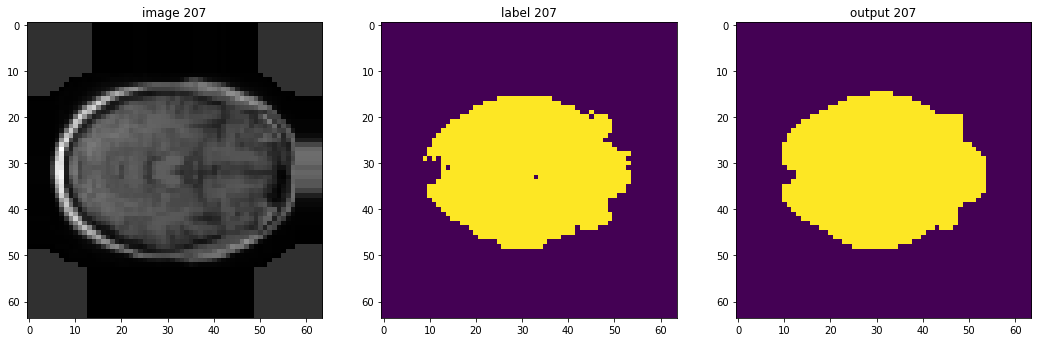

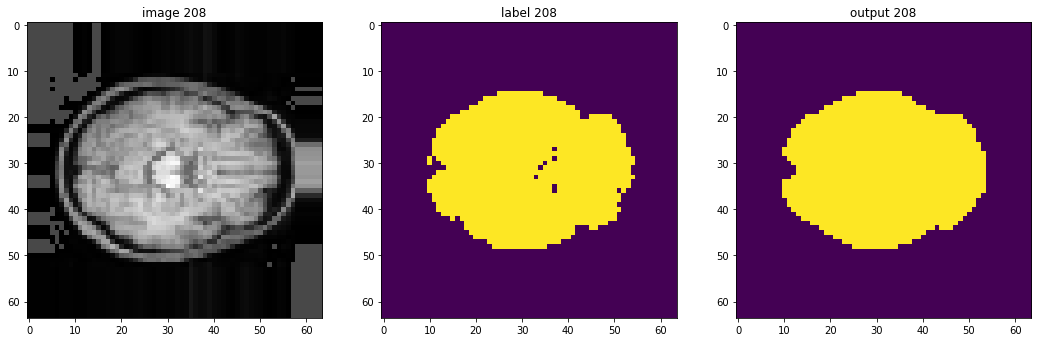

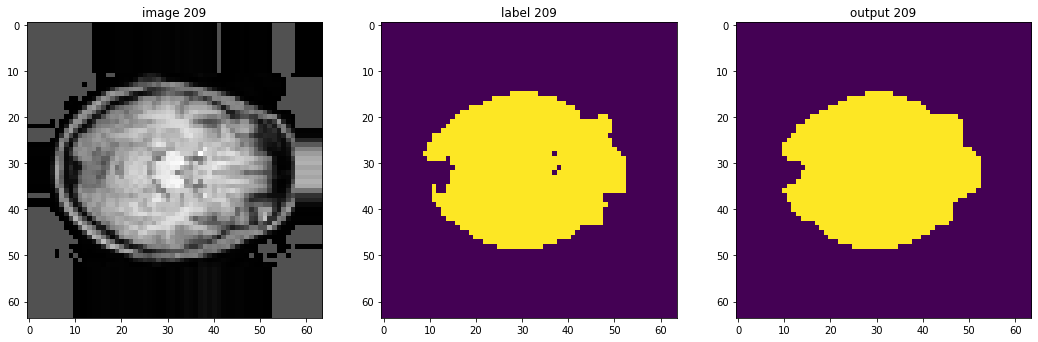

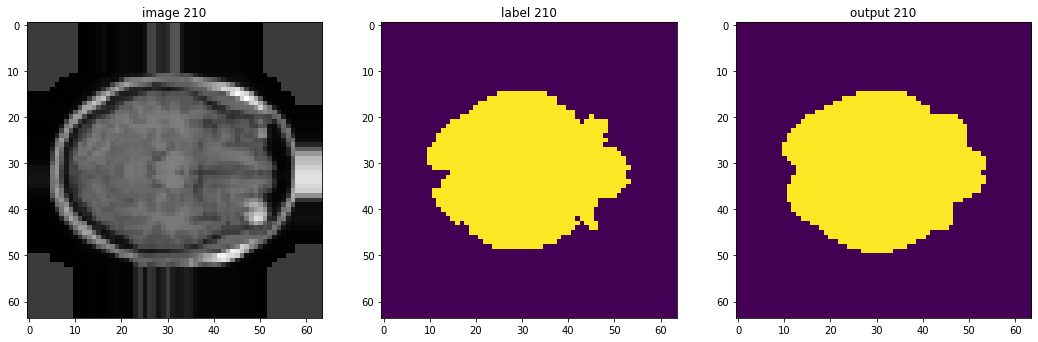

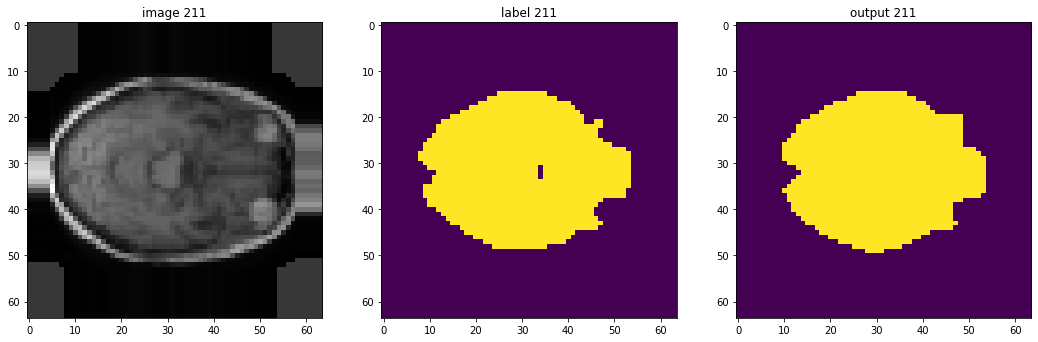

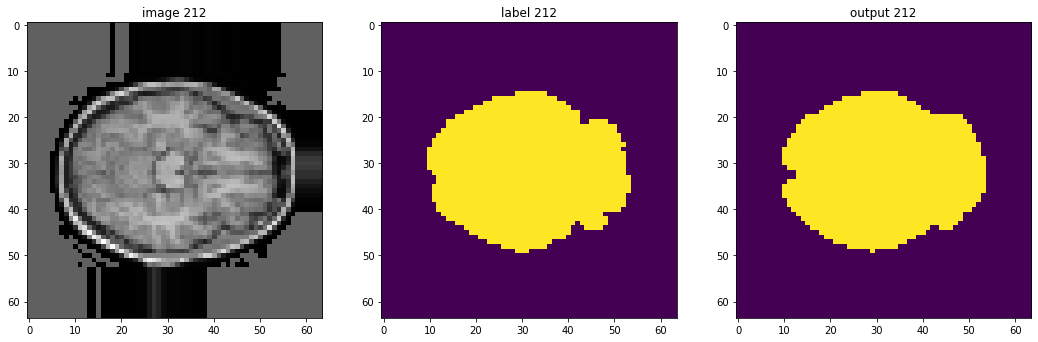

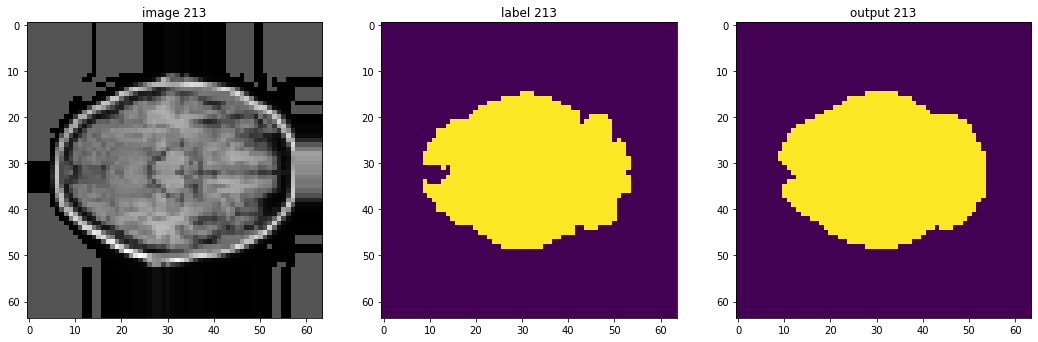

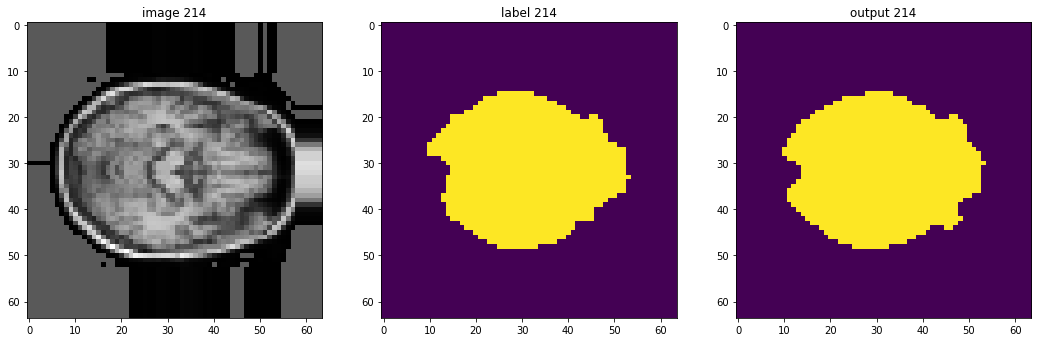

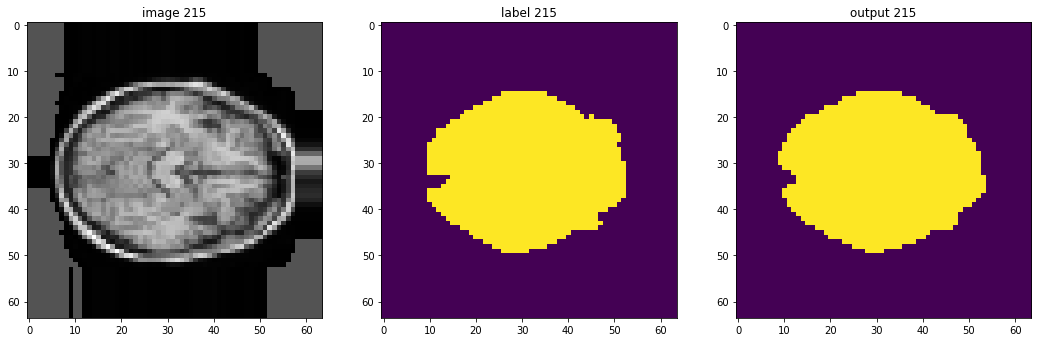

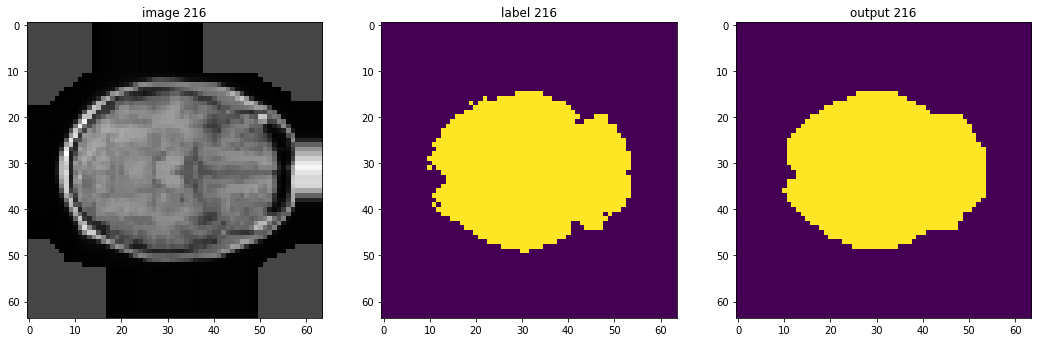

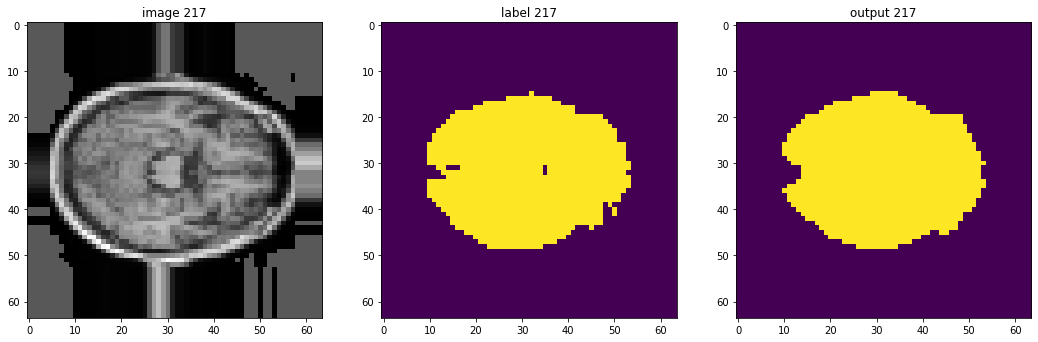

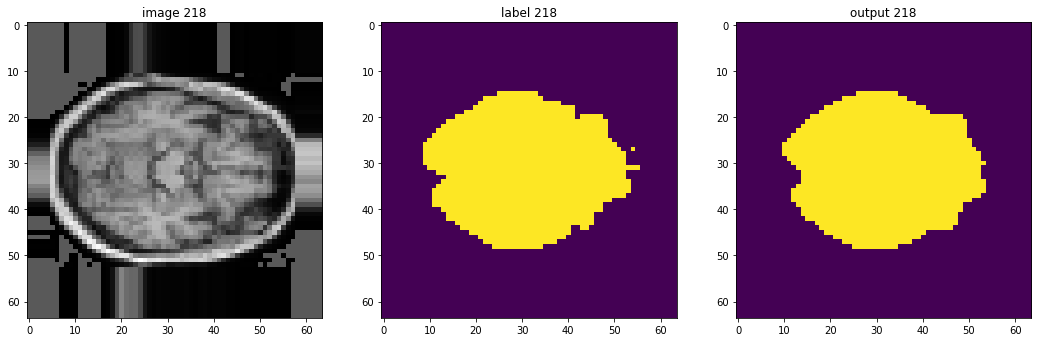

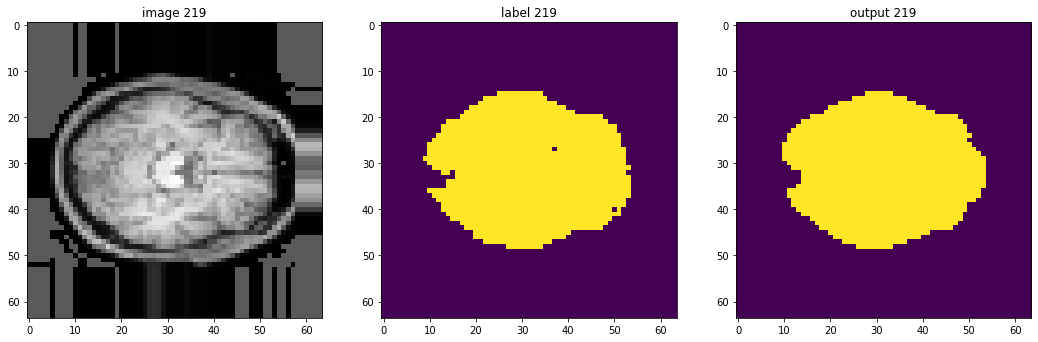

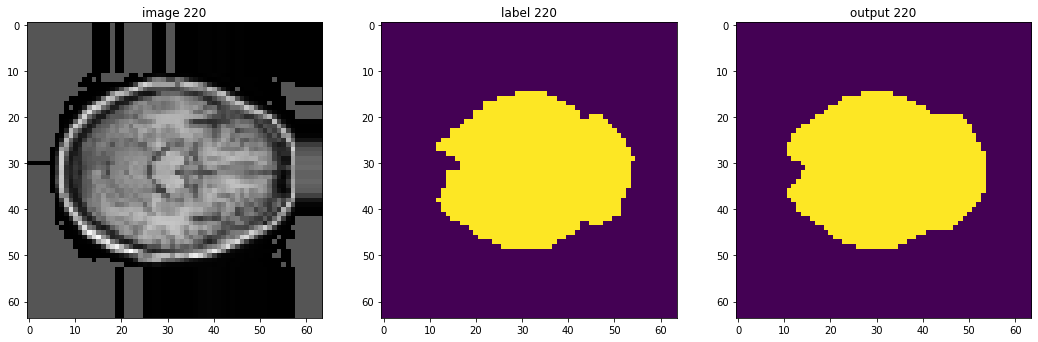

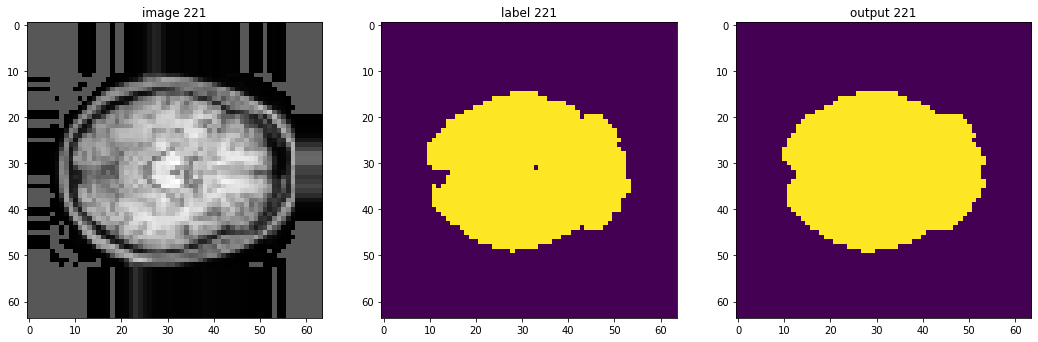

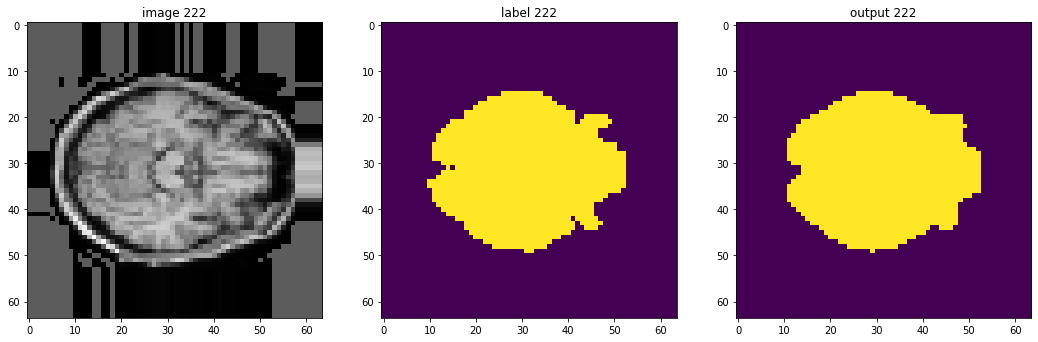

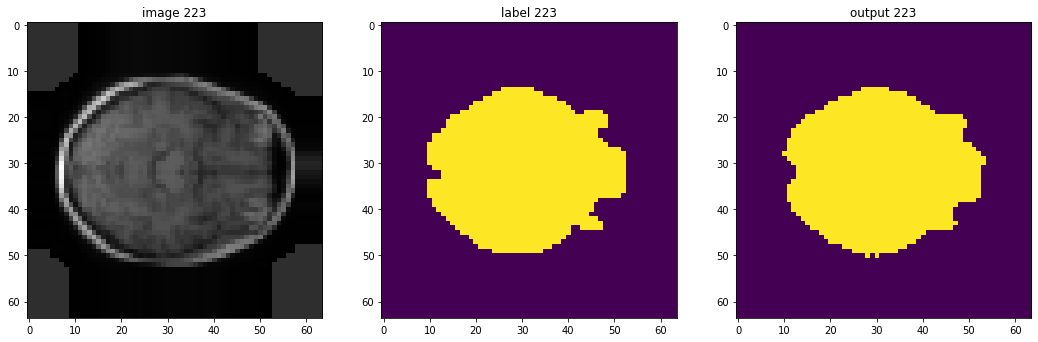

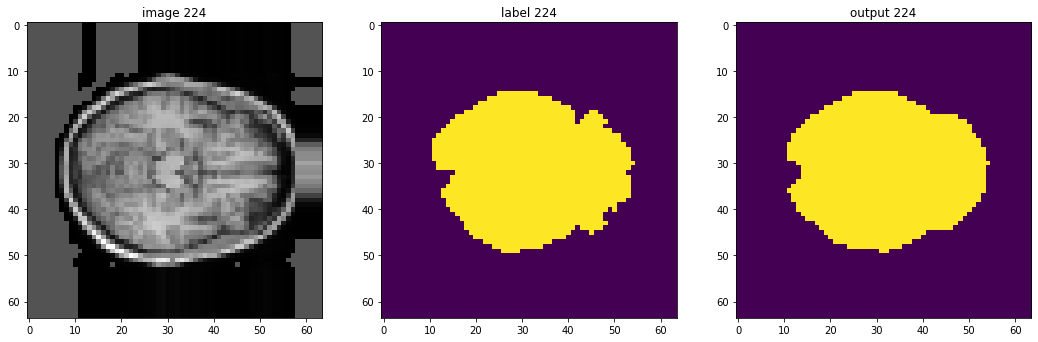

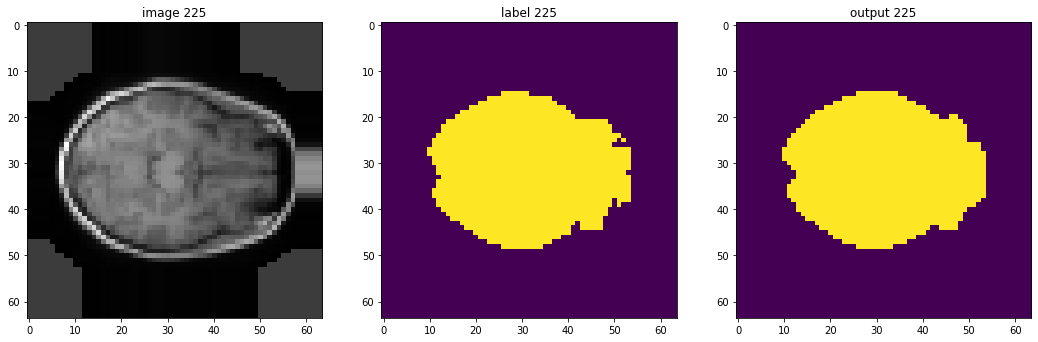

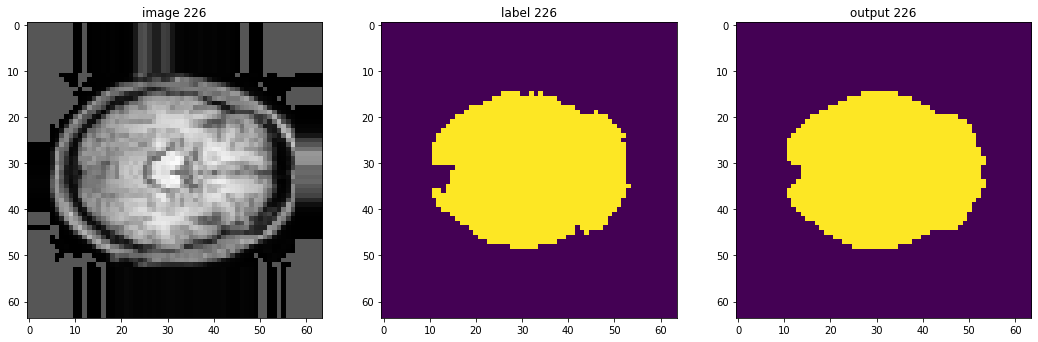

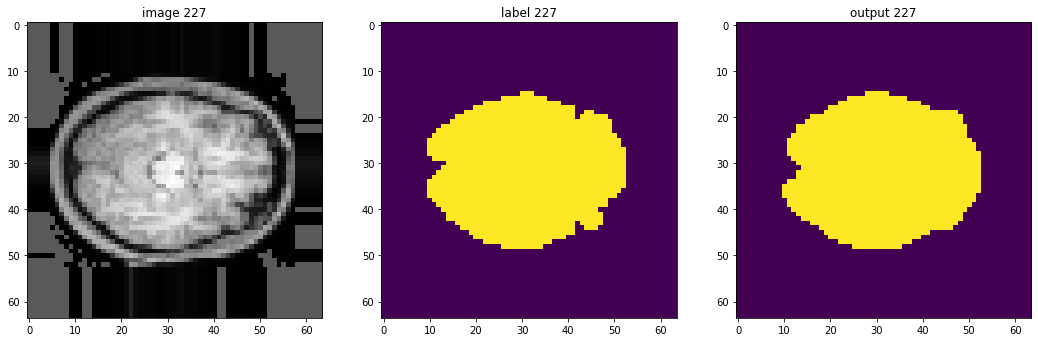

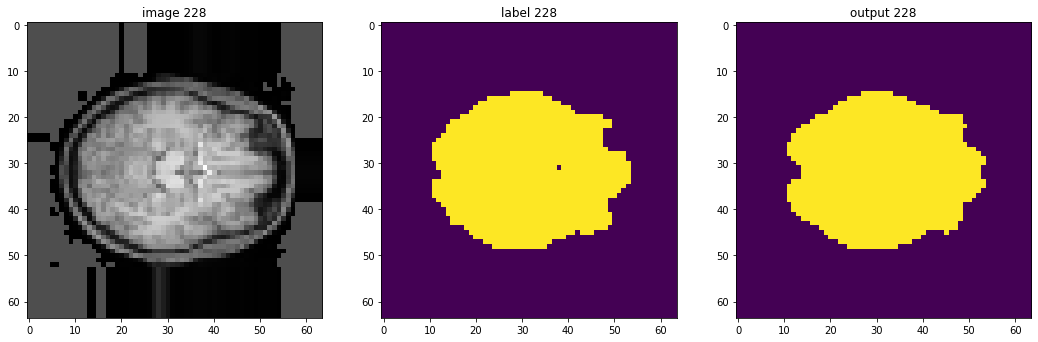

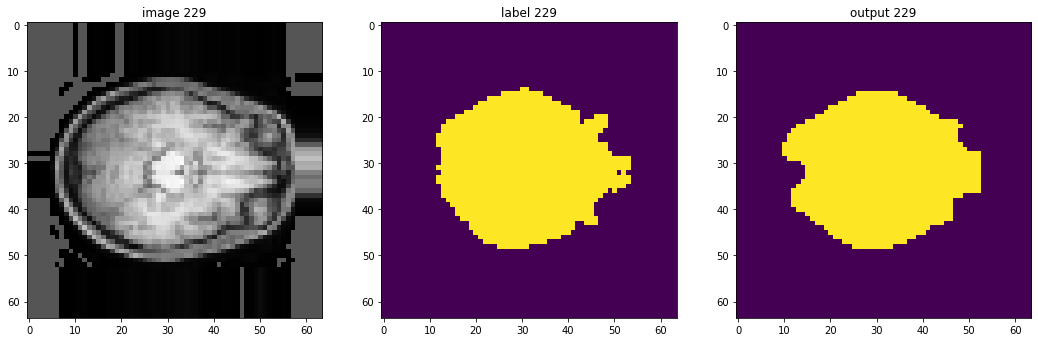

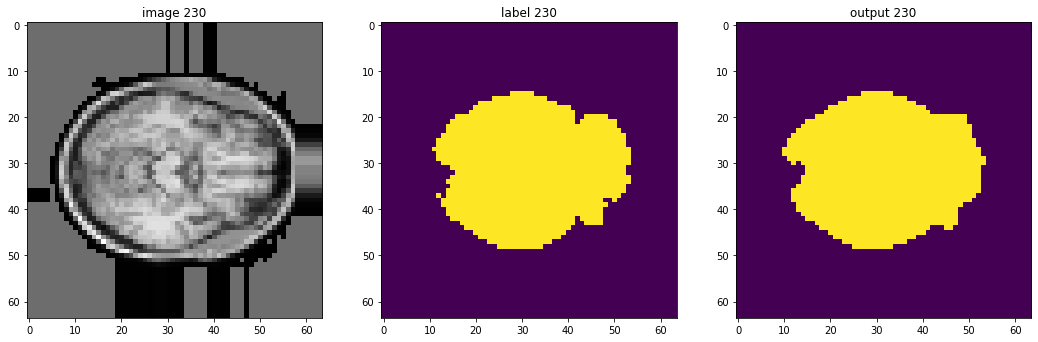

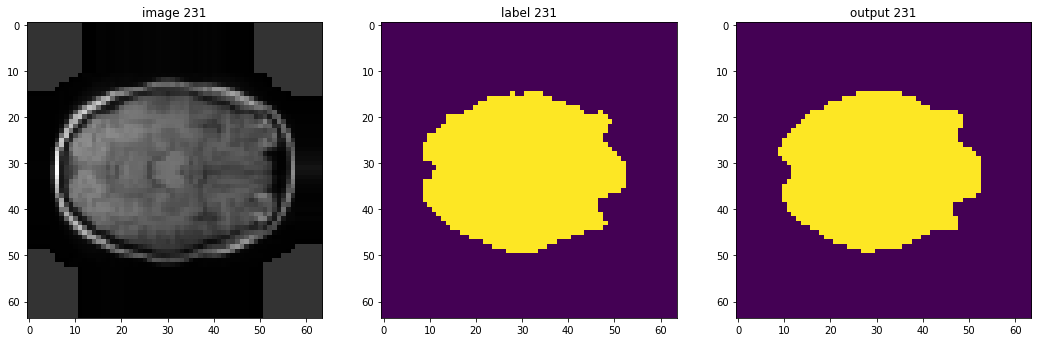

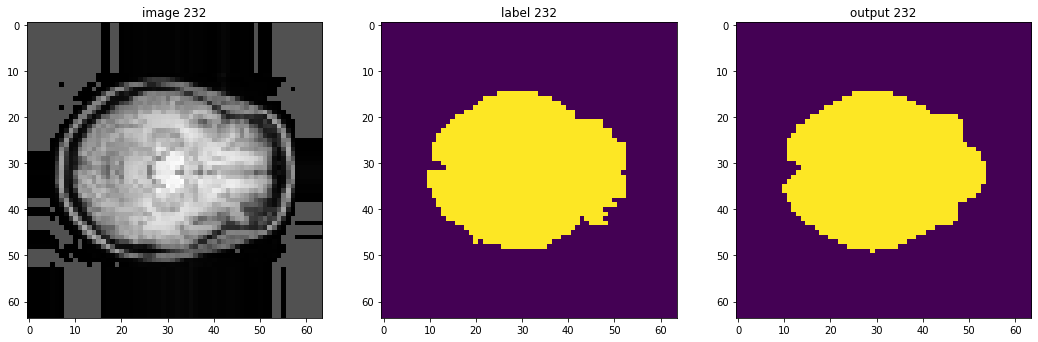

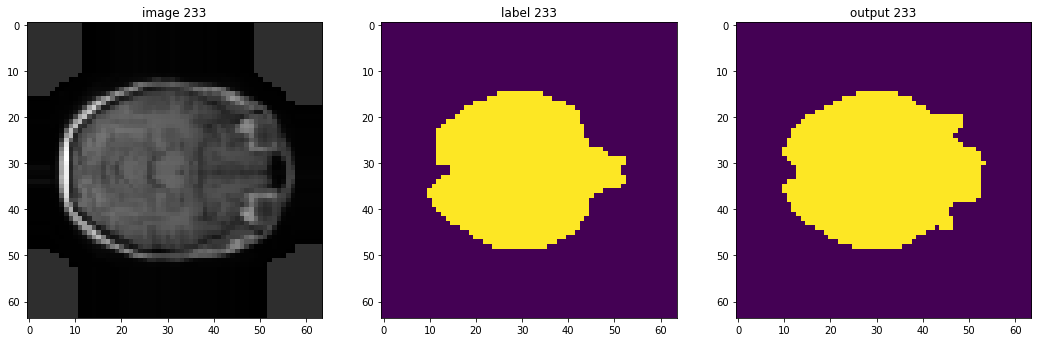

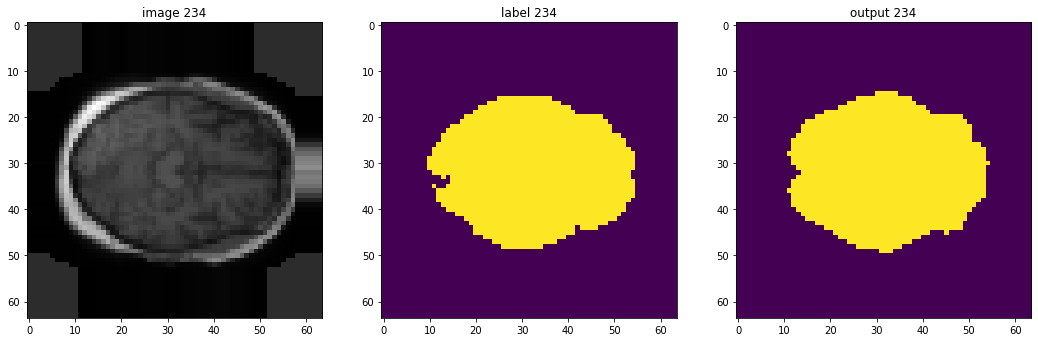

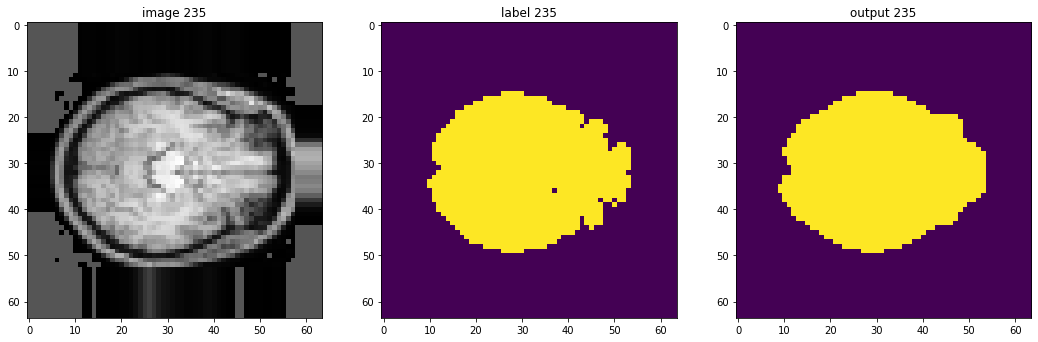

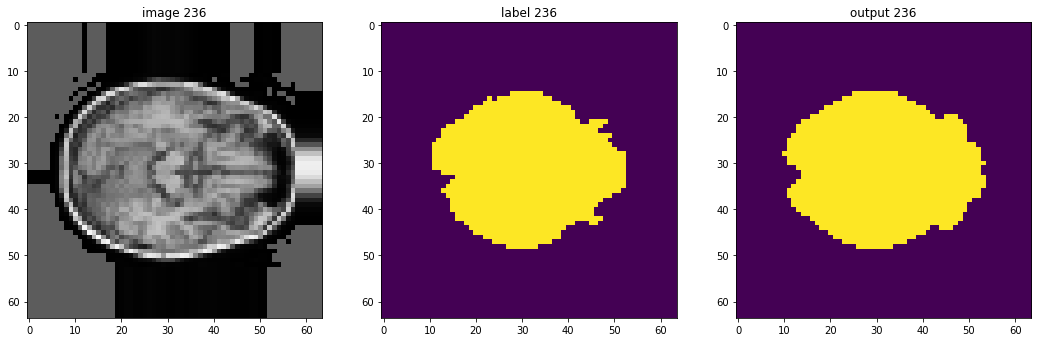

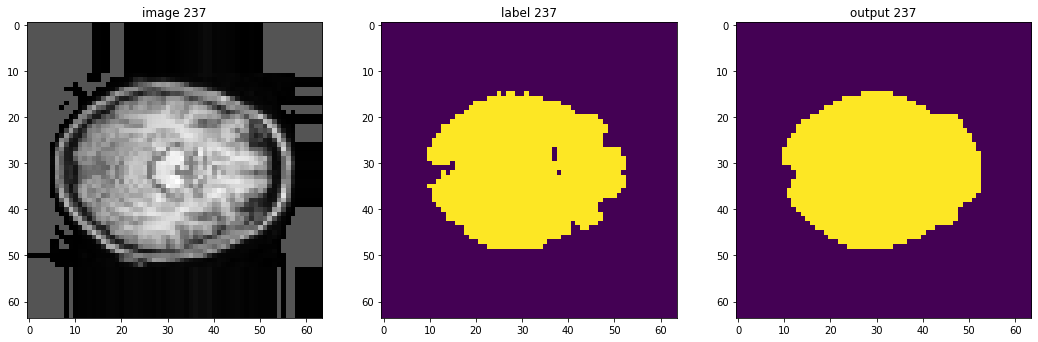

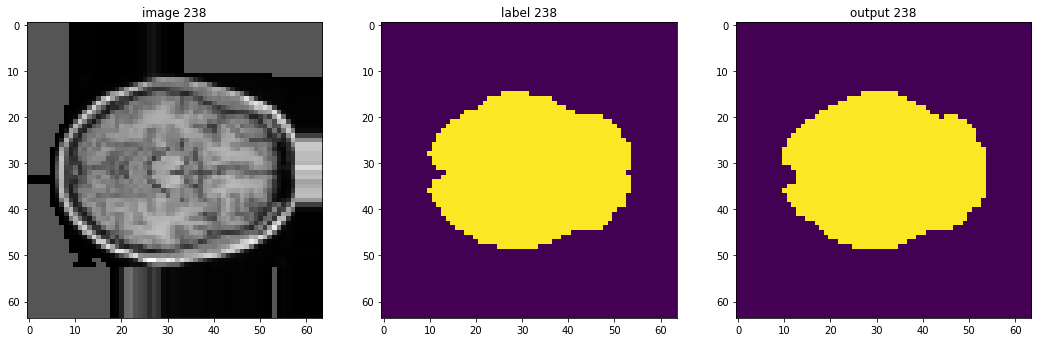

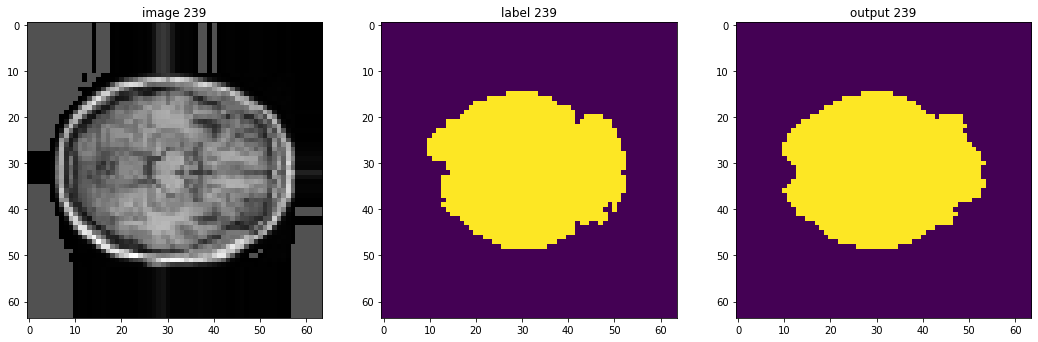

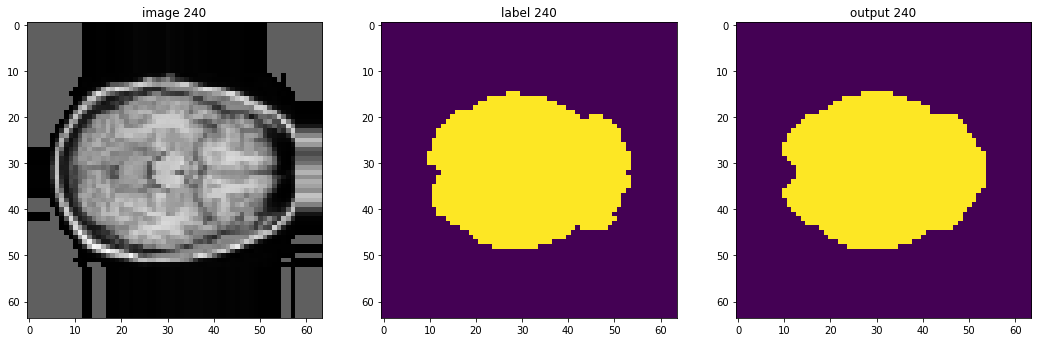

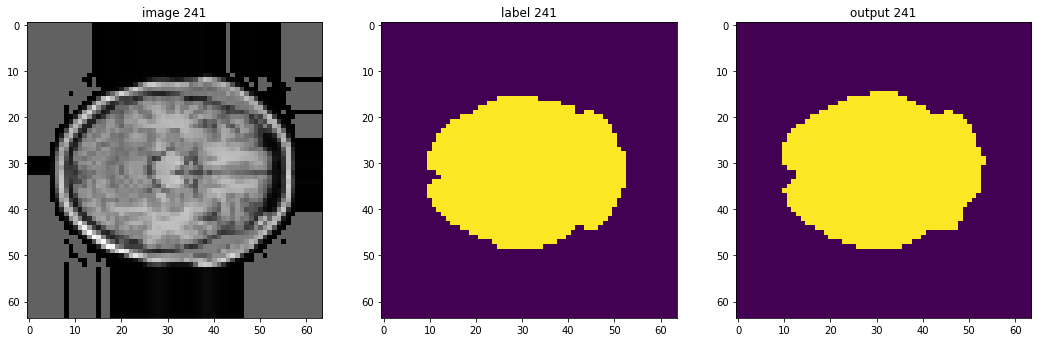

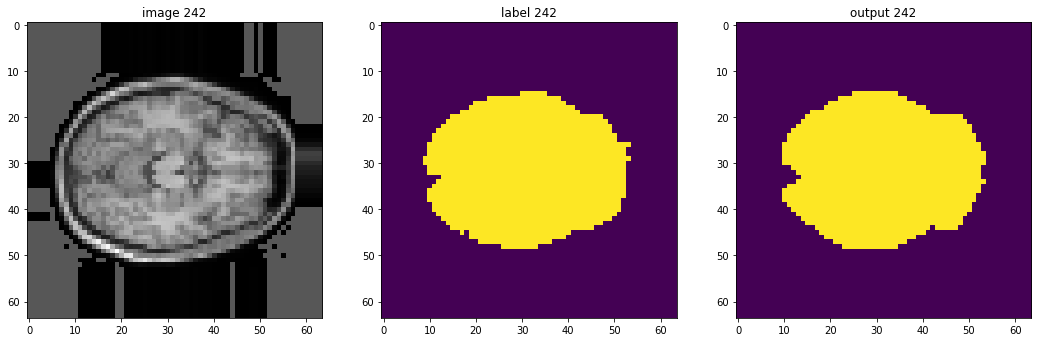

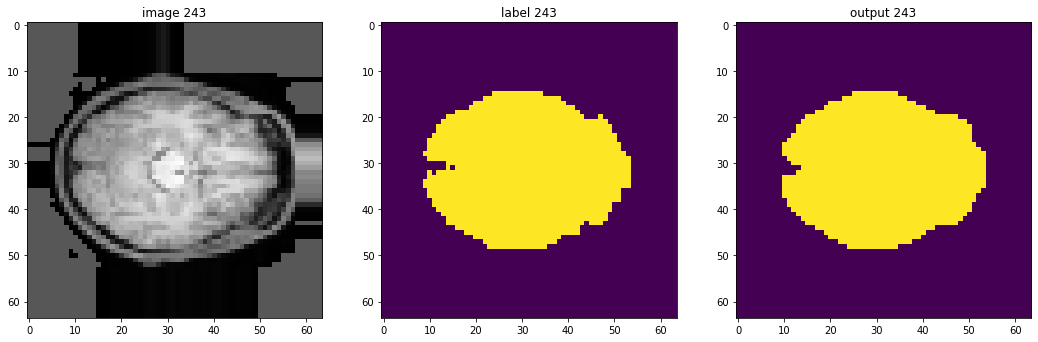

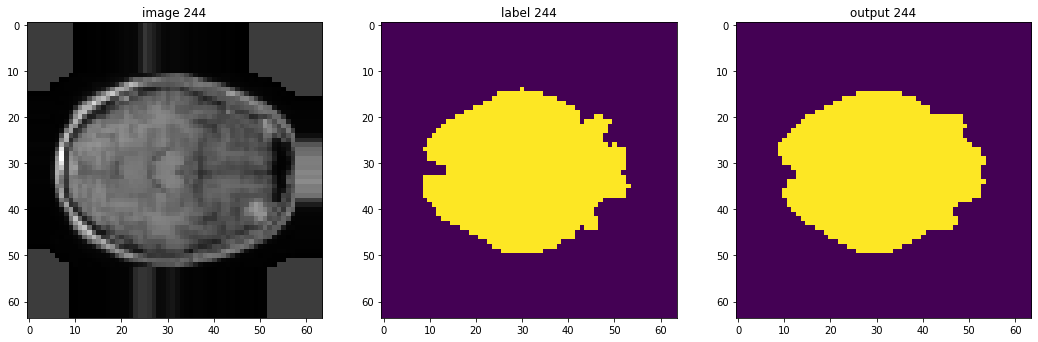

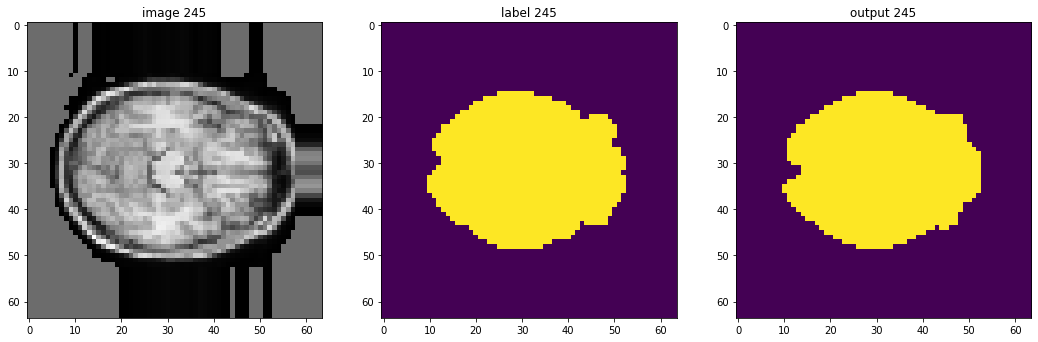

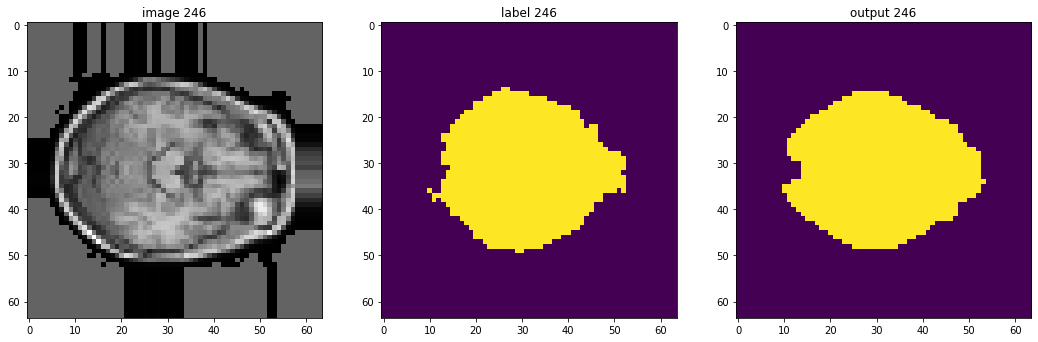

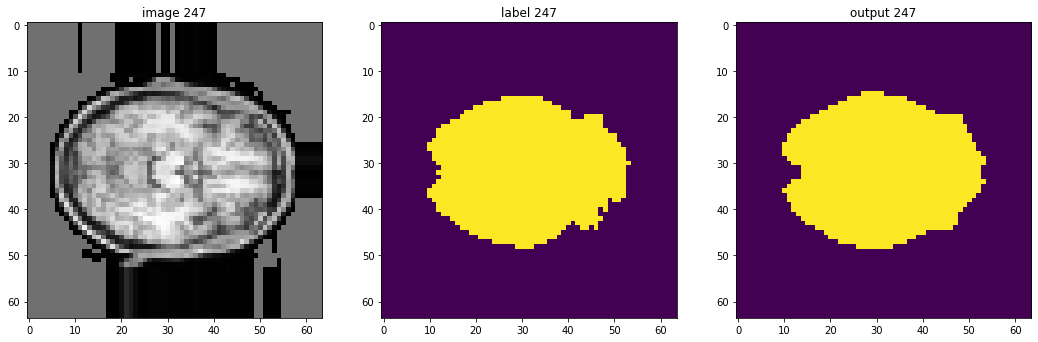

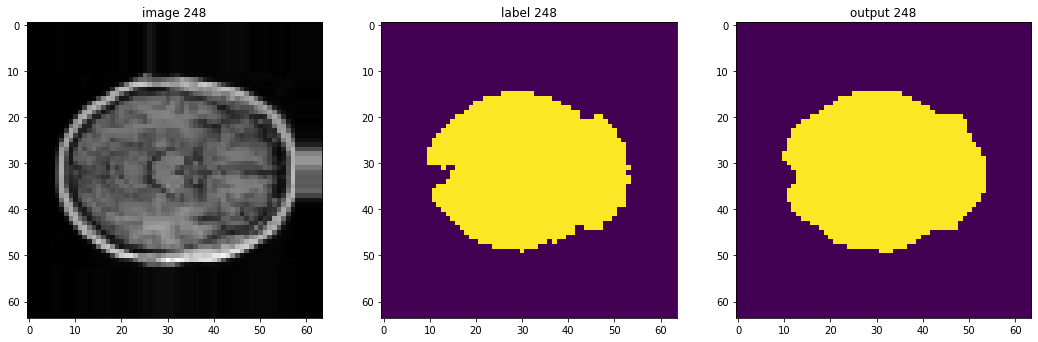

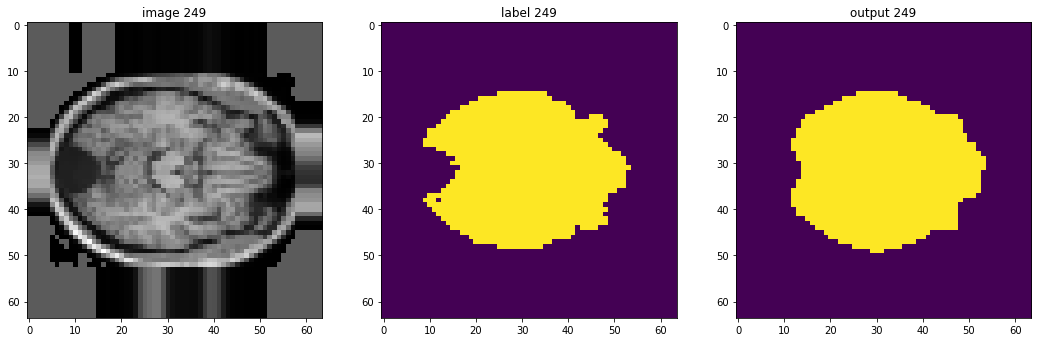

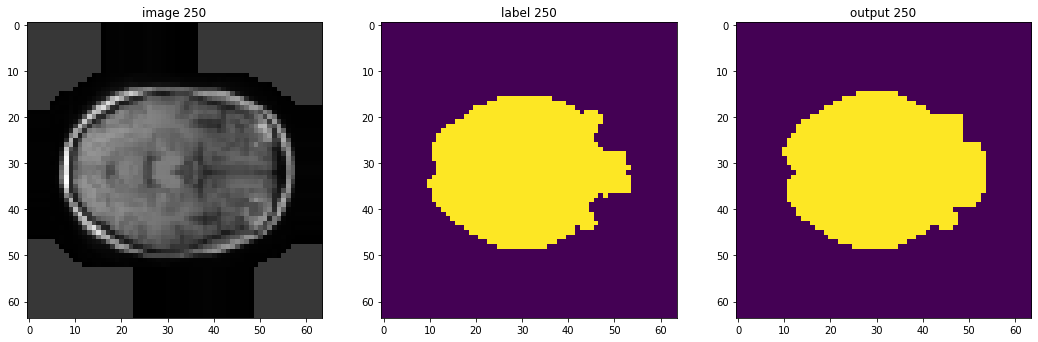

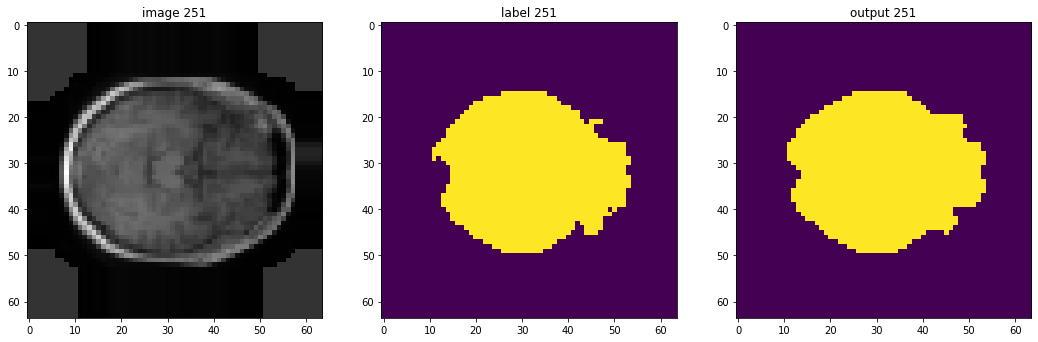

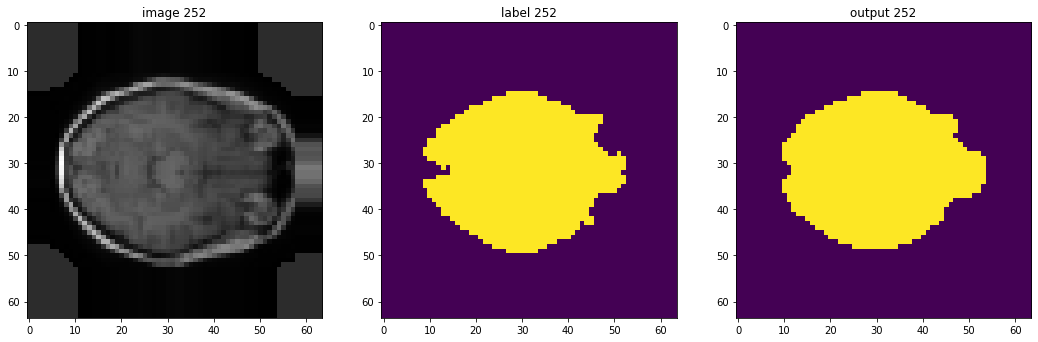

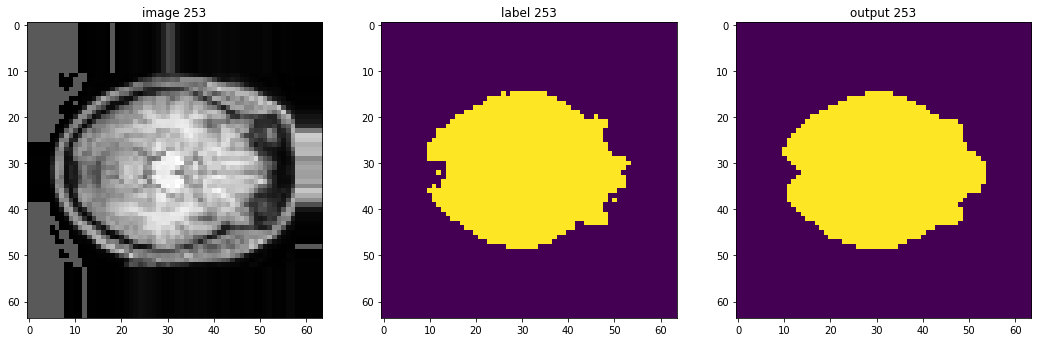

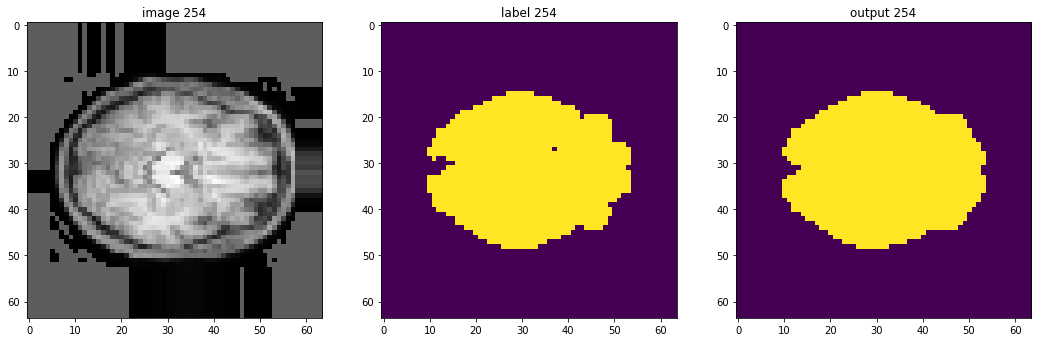

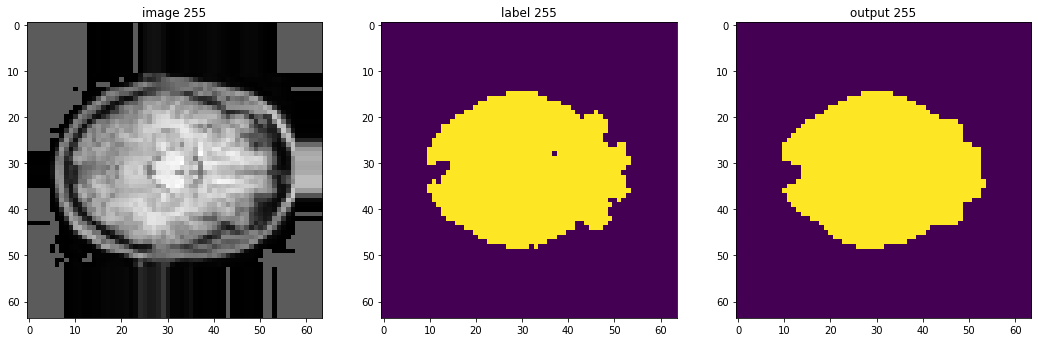

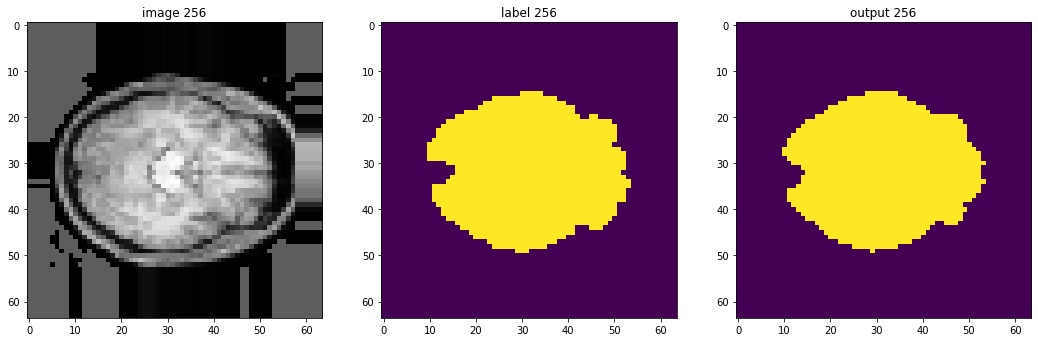

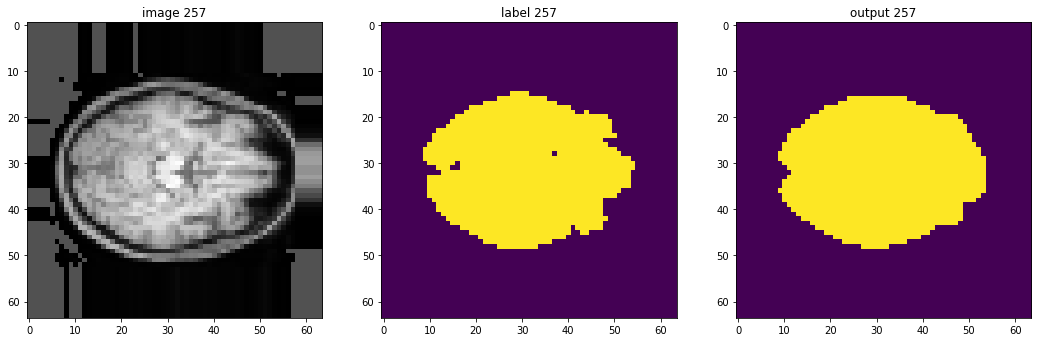

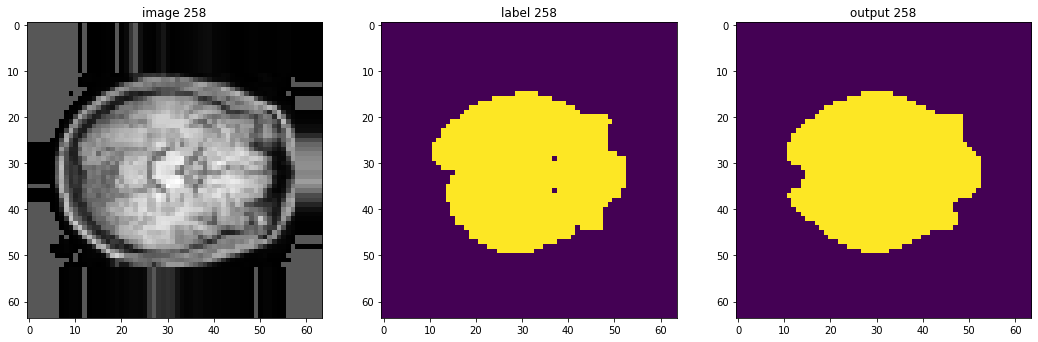

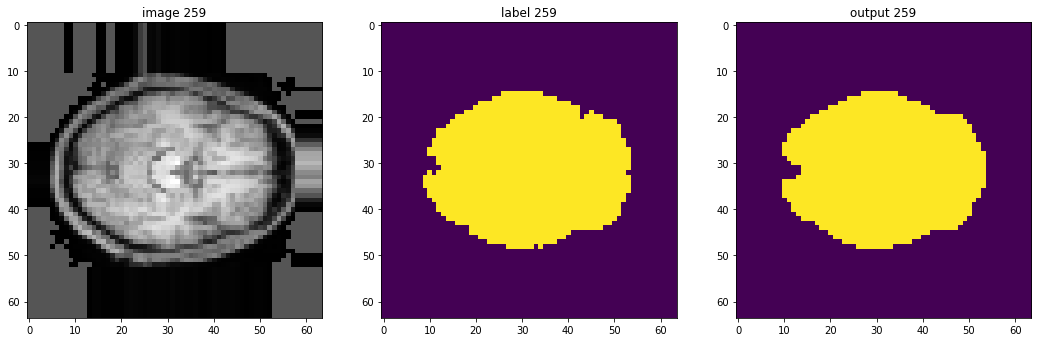

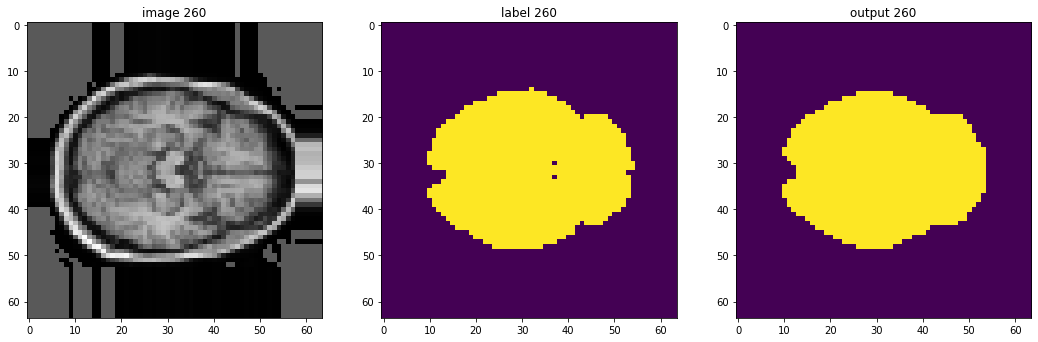

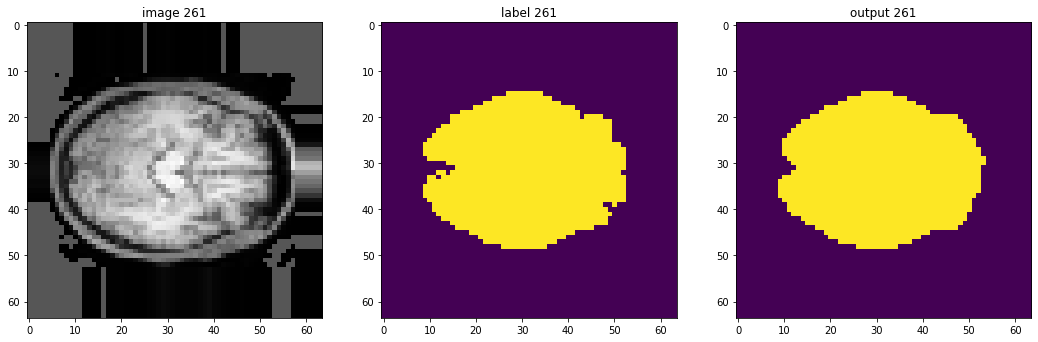

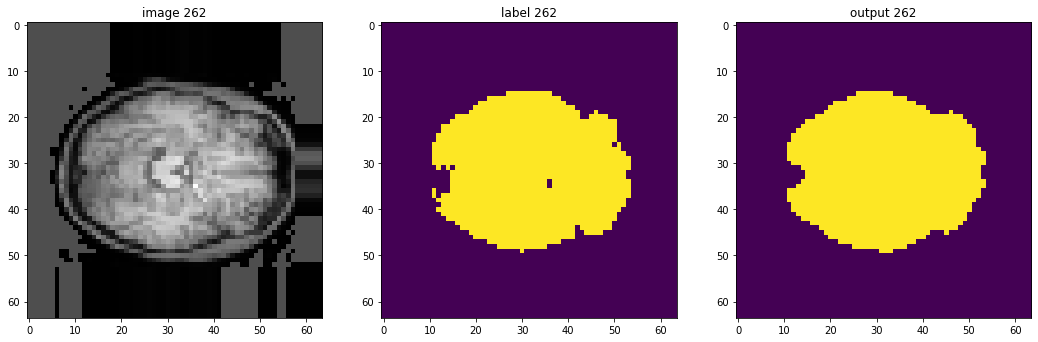

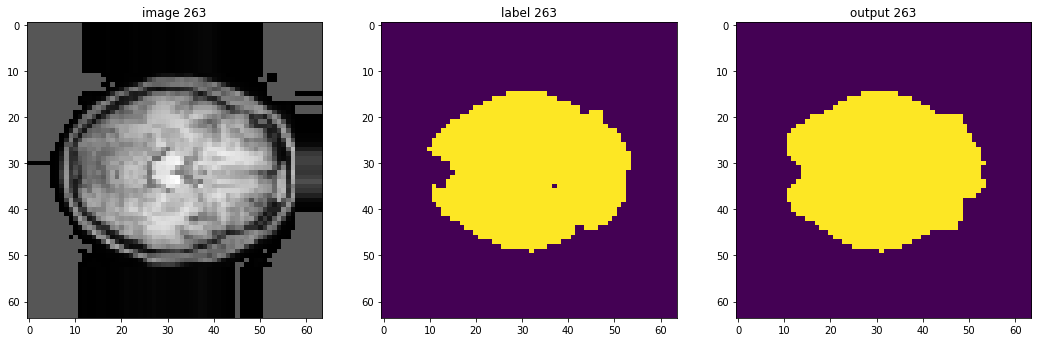

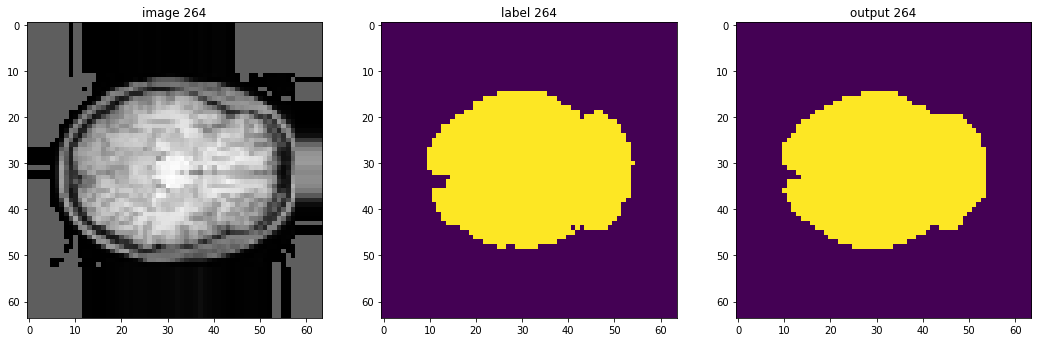

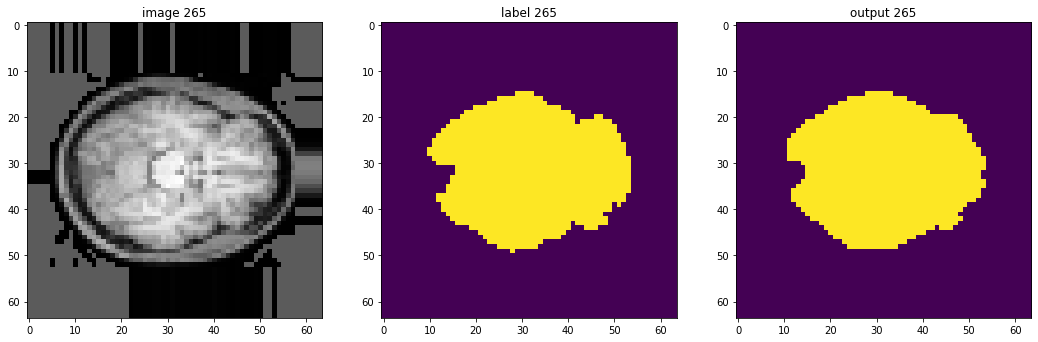

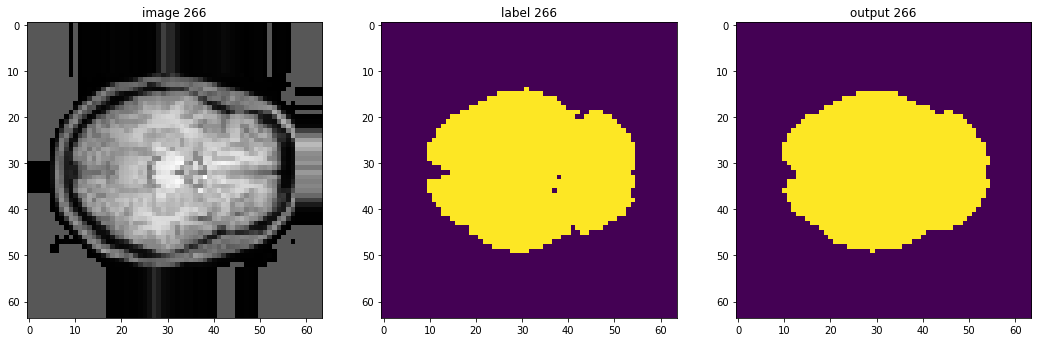

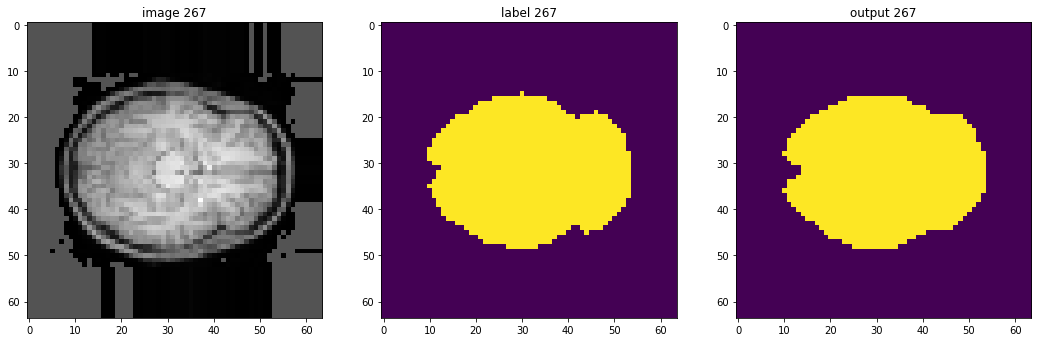

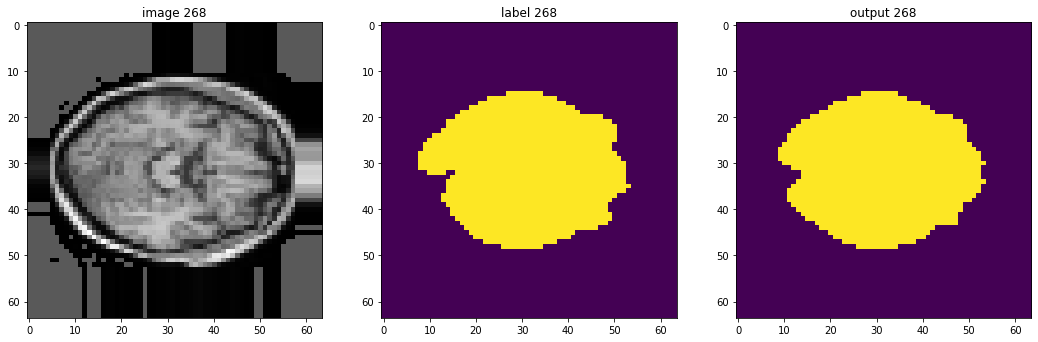

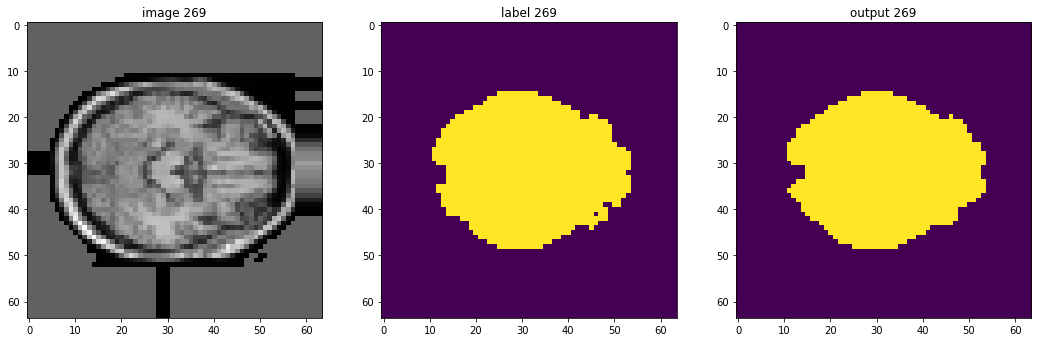

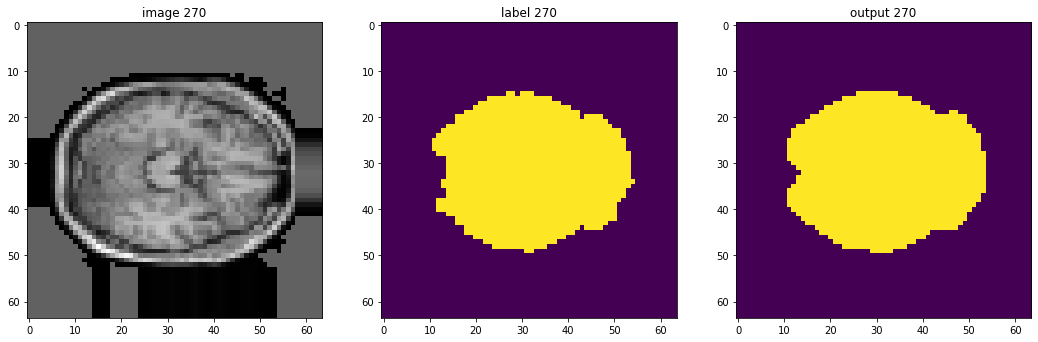

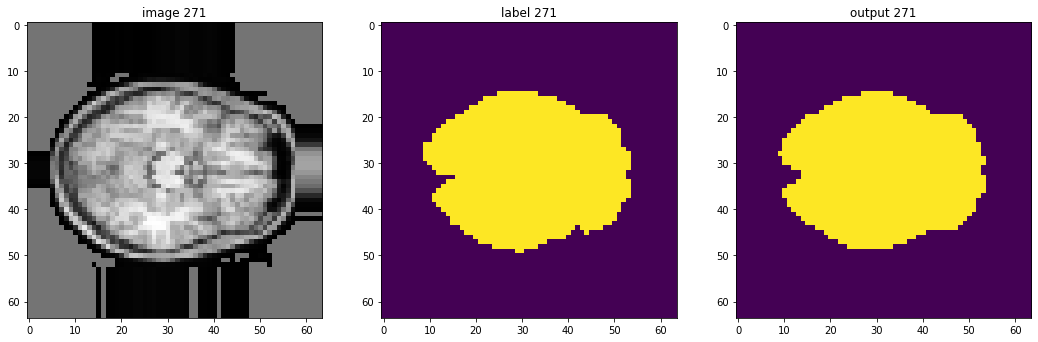

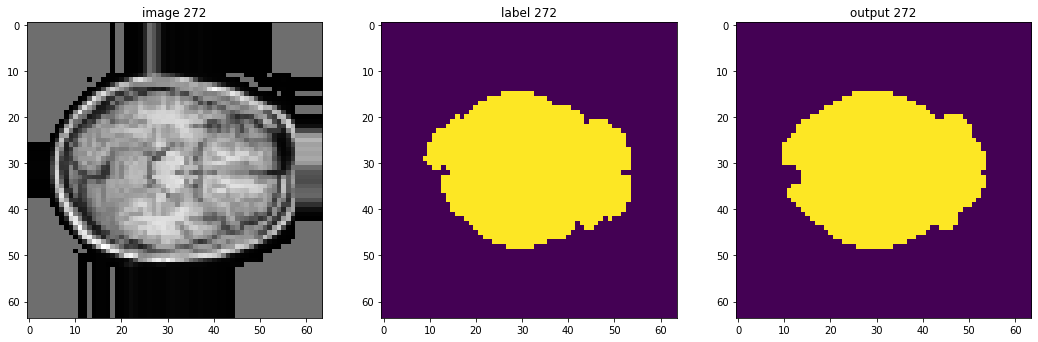

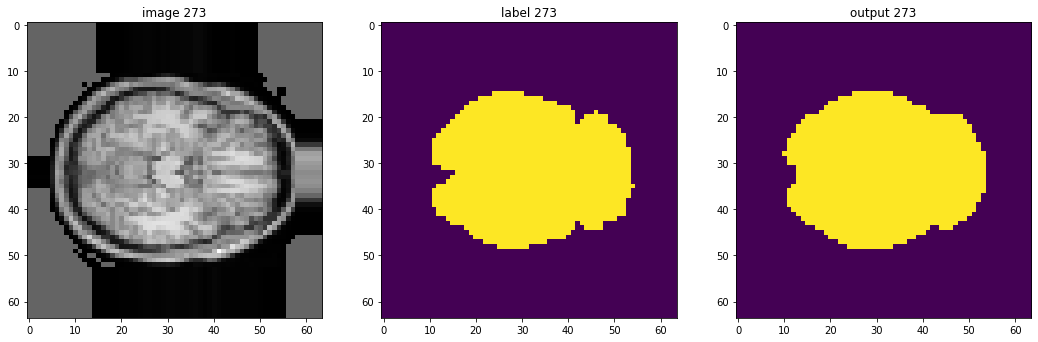

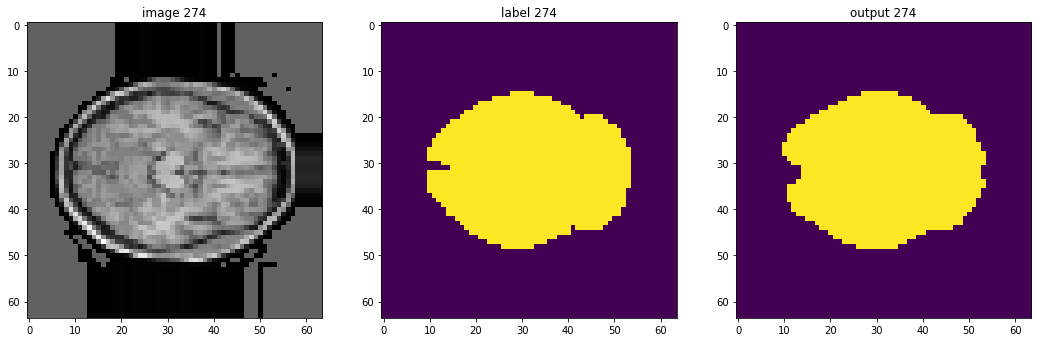

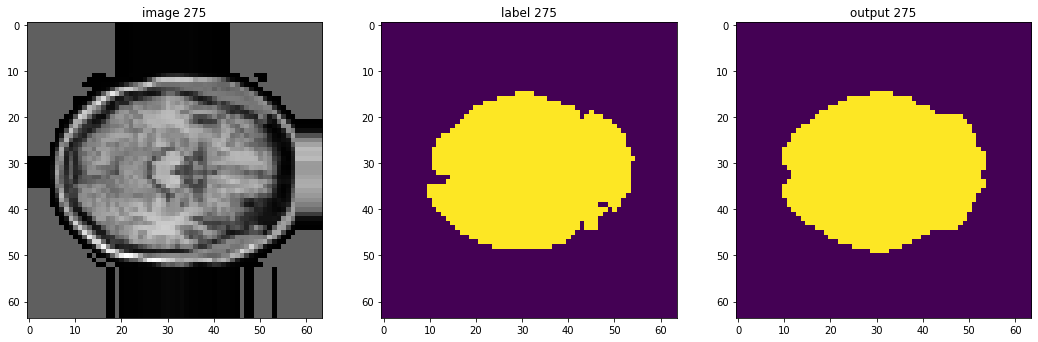

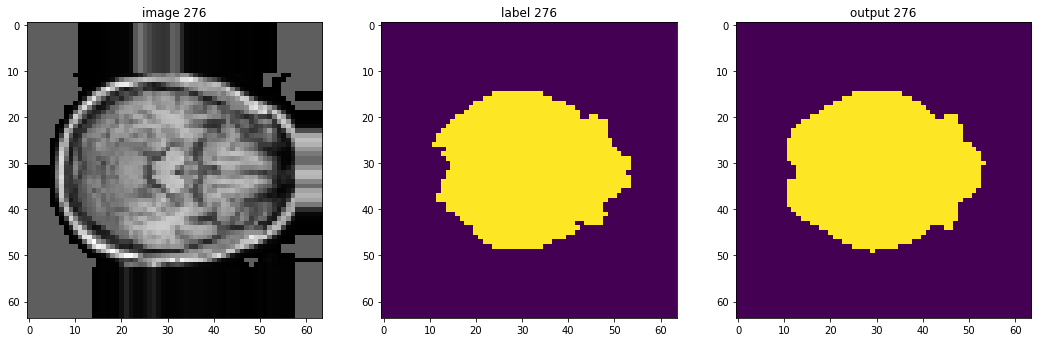

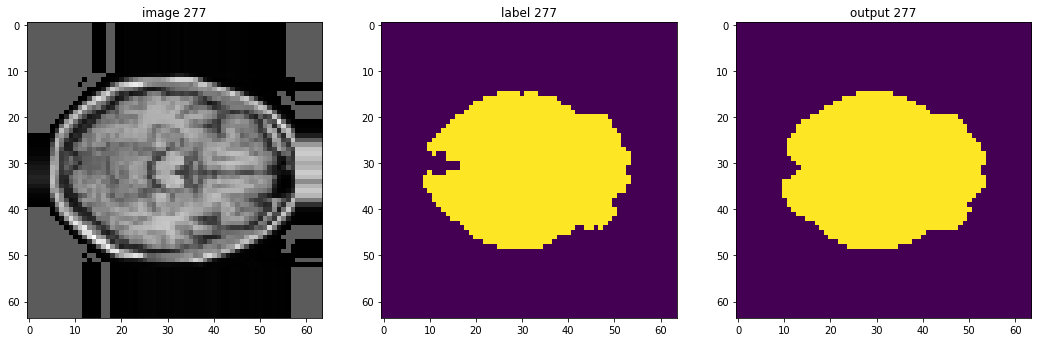

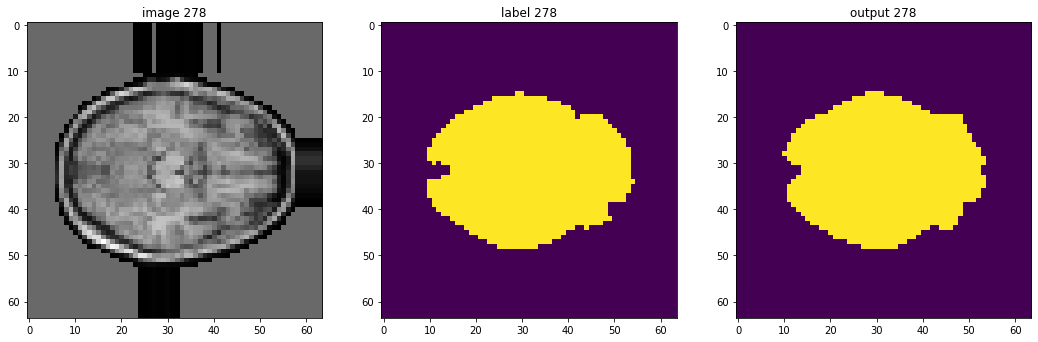

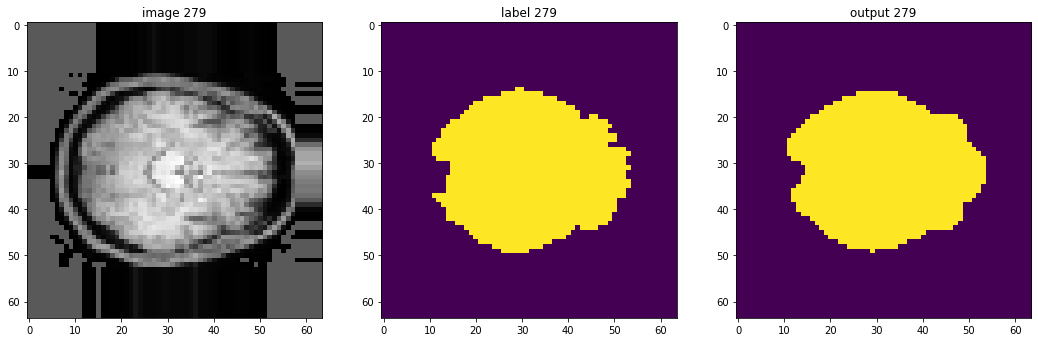

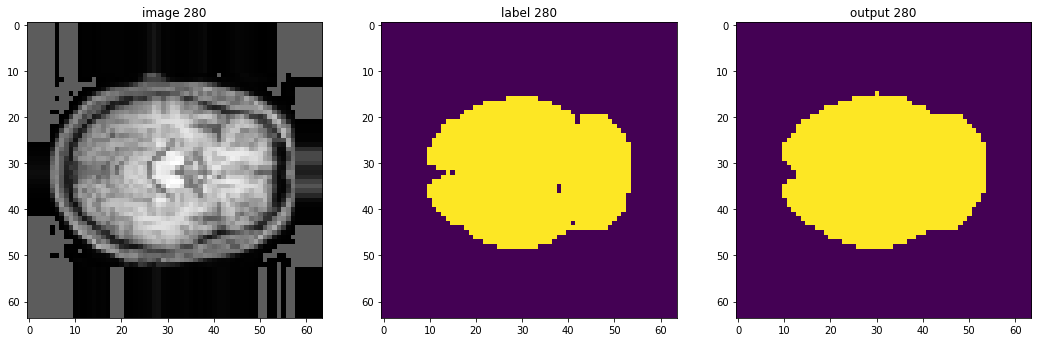

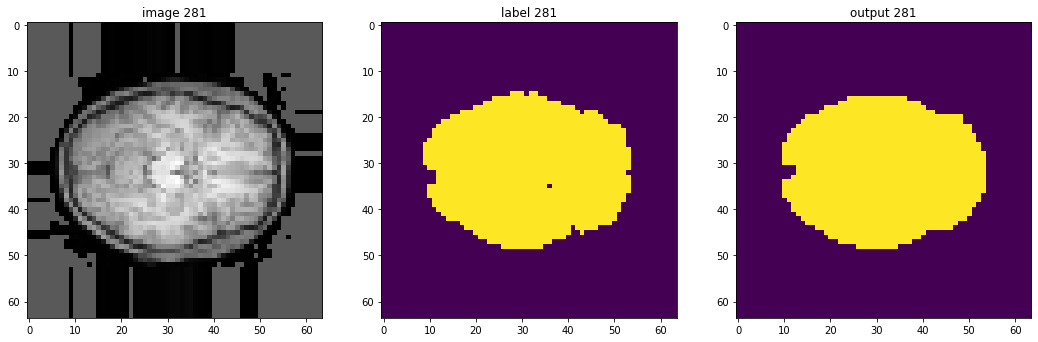

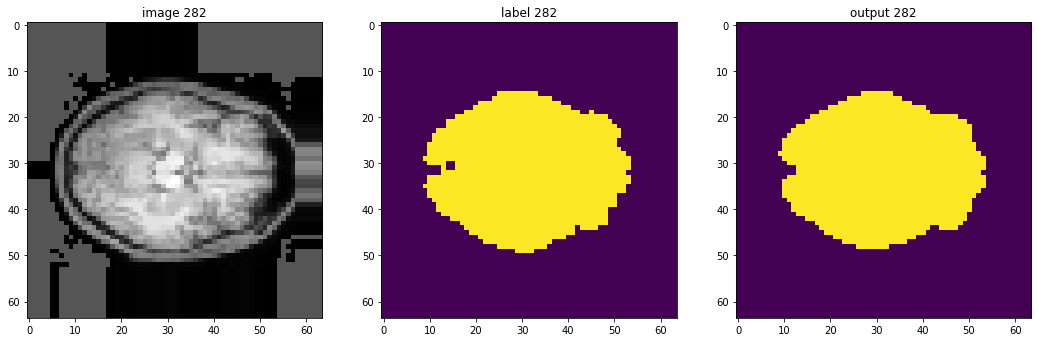

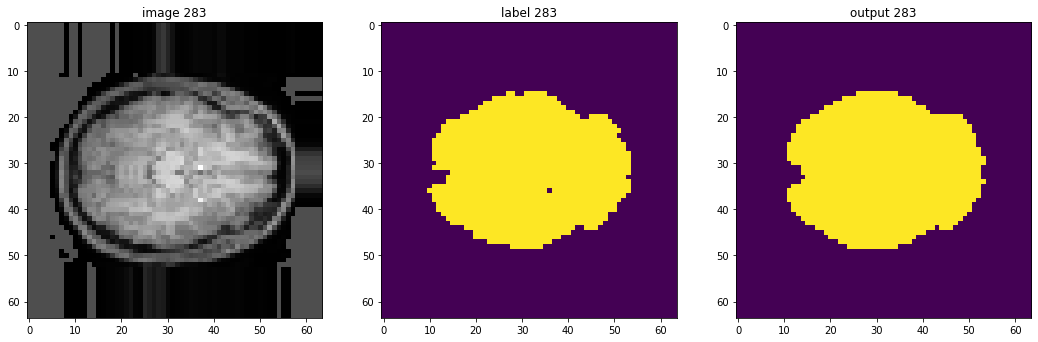

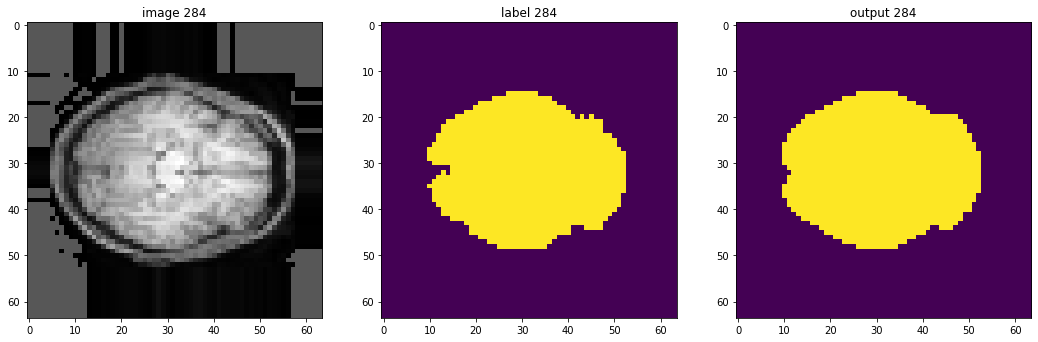

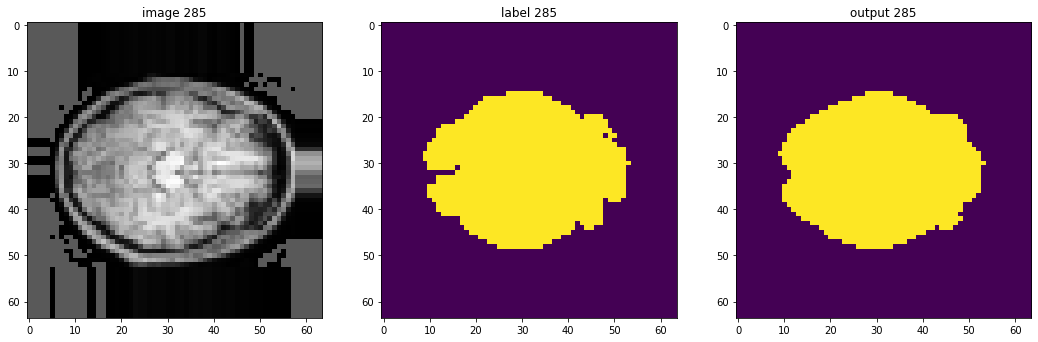

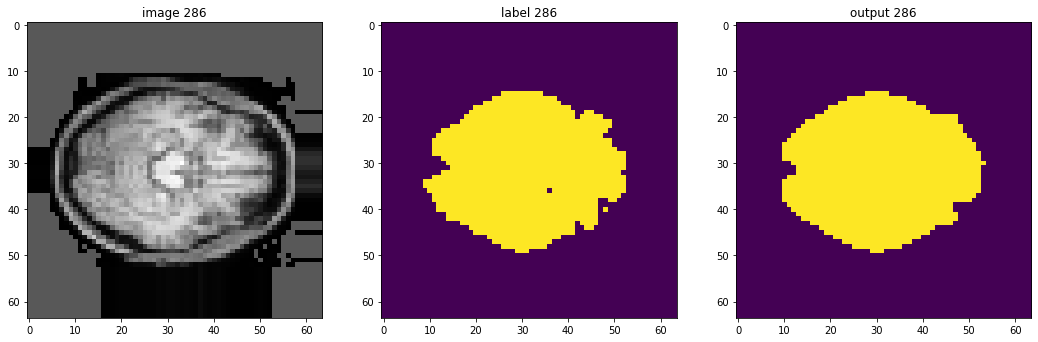

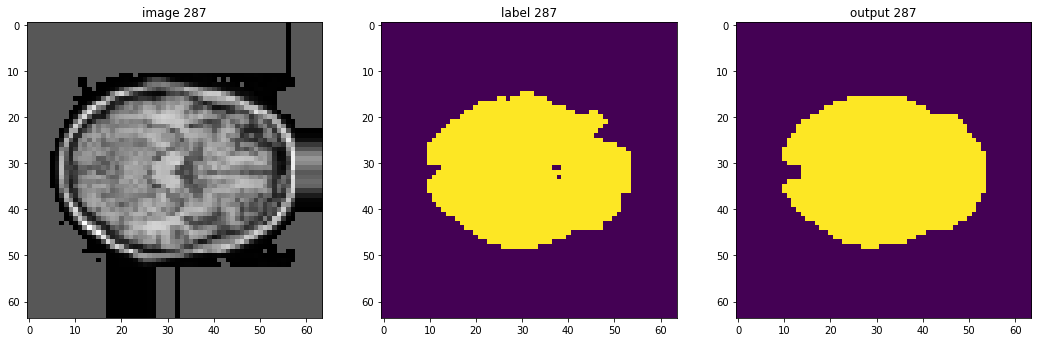

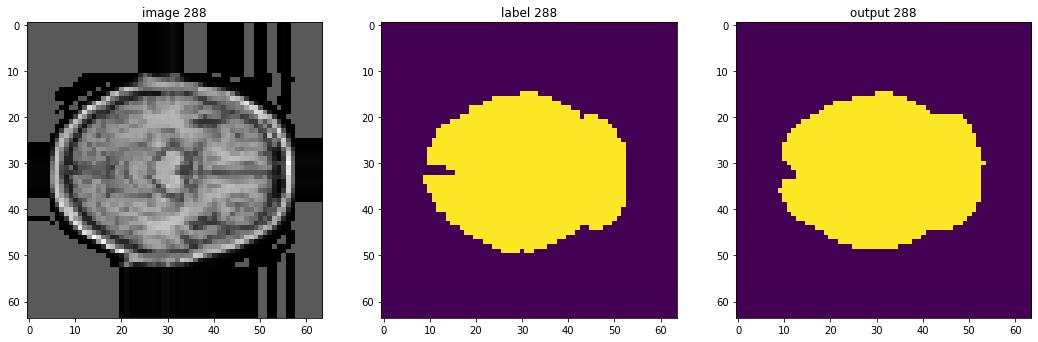

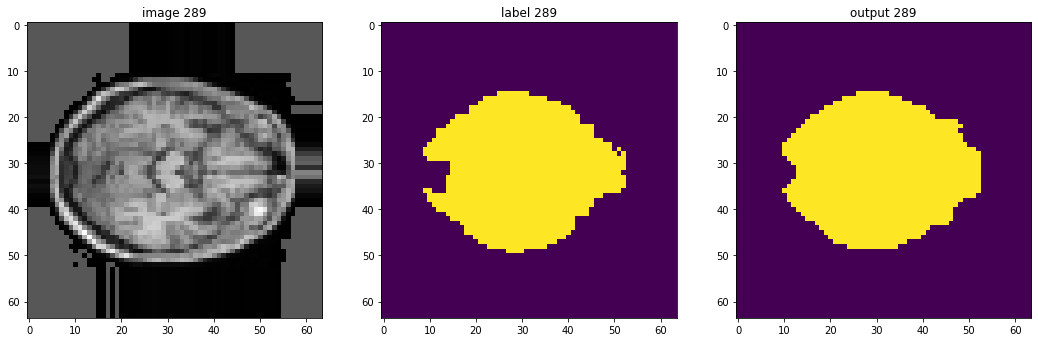

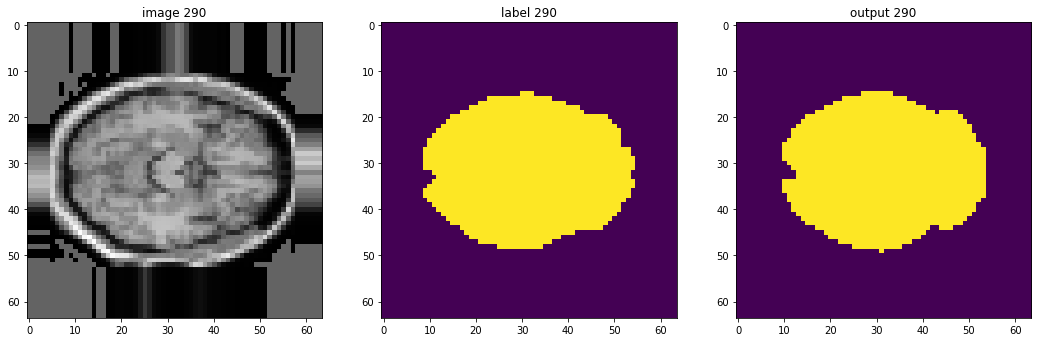

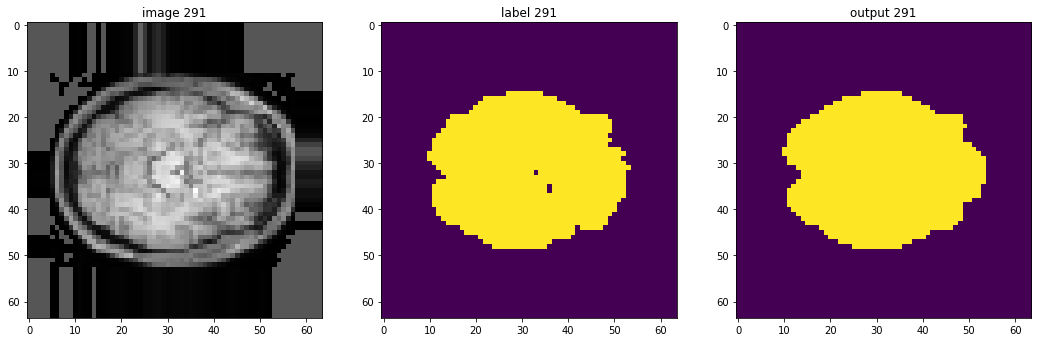

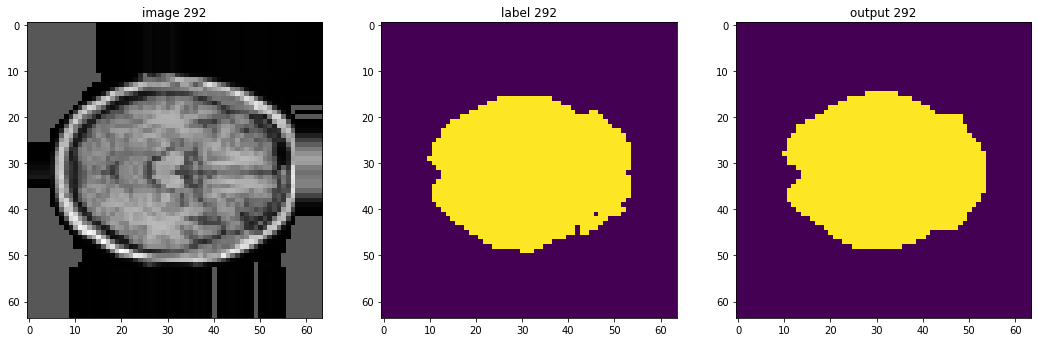

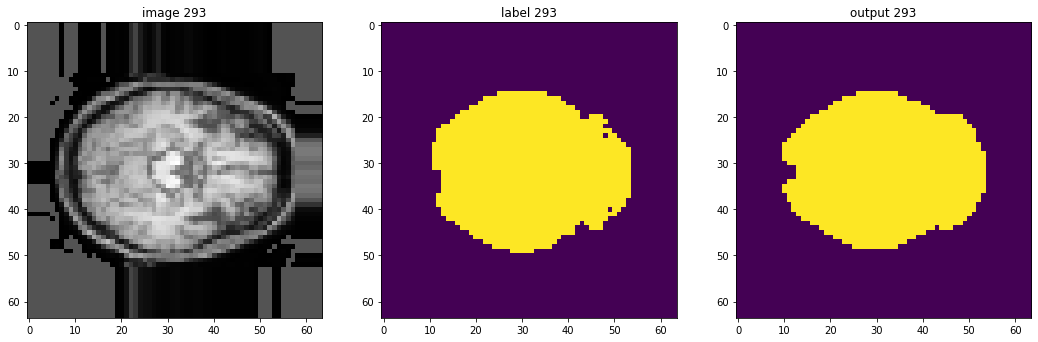

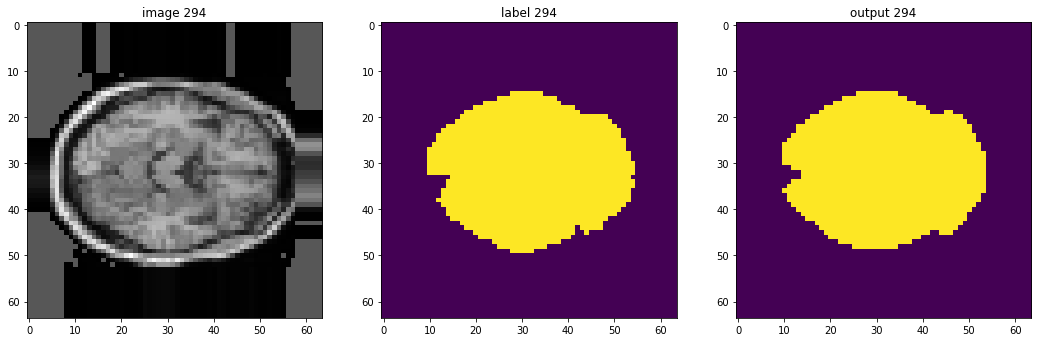

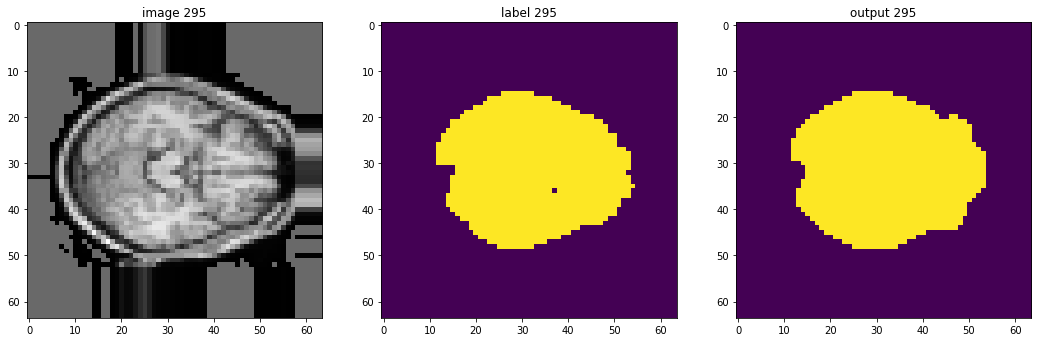

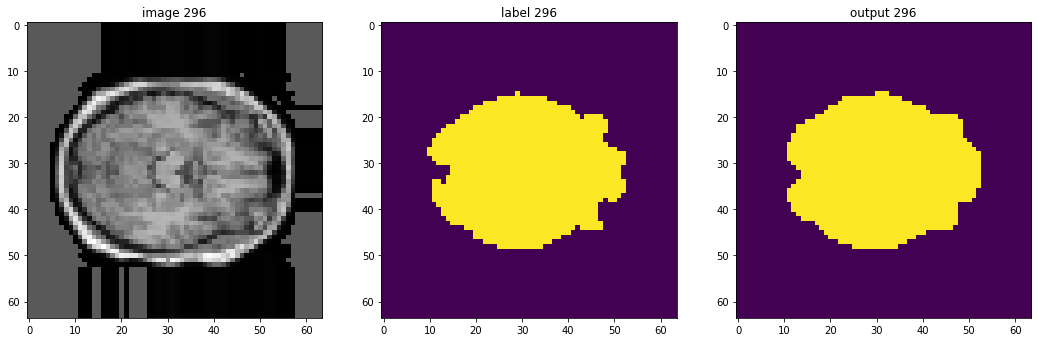

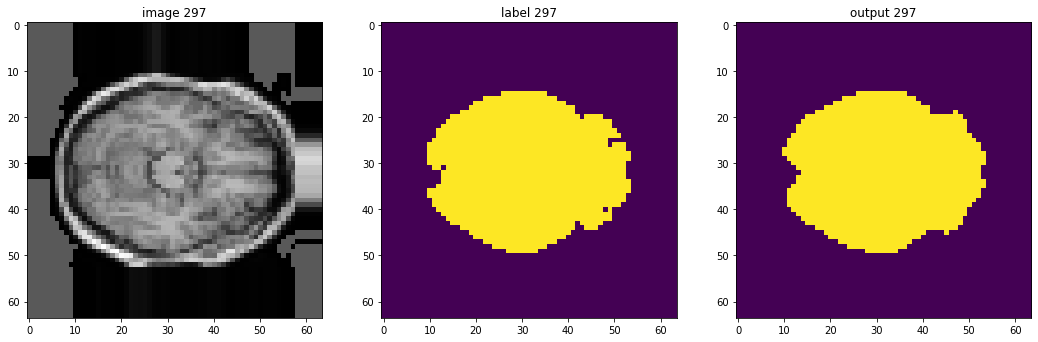

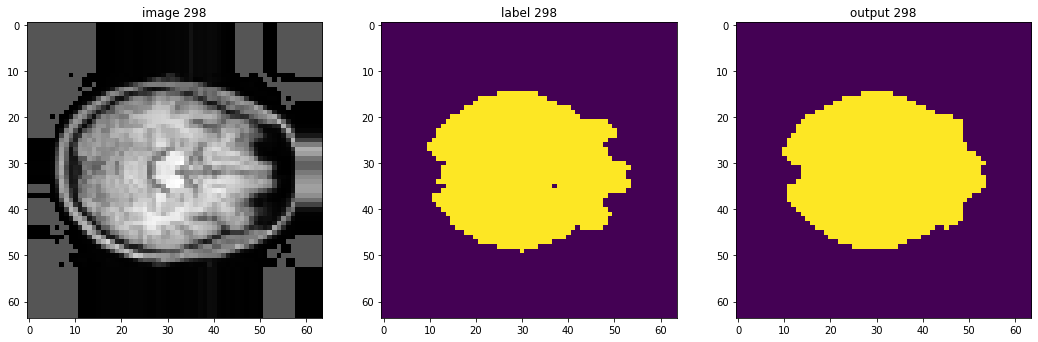

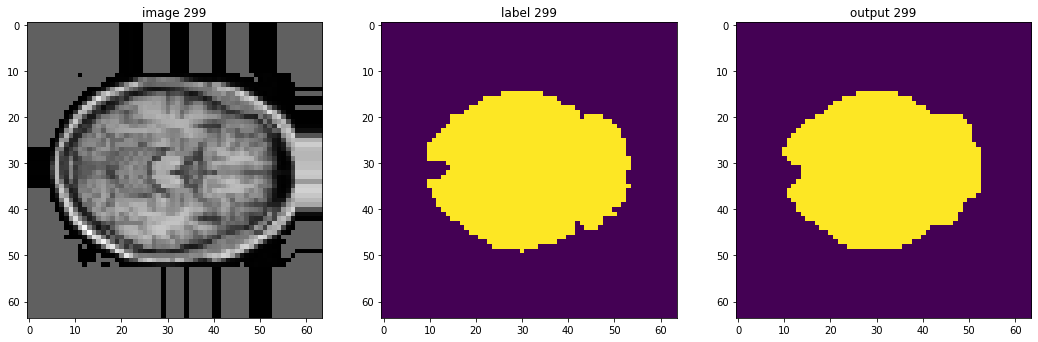

In [31]:
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (-1, -1, -1)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 32]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 32], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 32])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 32])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [25]:
if directory is None:
    shutil.rmtree(root_dir)